In [186]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, pearsonr, spearmanr
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder,  StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from fuzzywuzzy import fuzz, process
import re

# Lectura de datos

In [187]:
# Disclaimer: Estoy usando VS Code con Copilot, por lo que el automcomplete aniade lineas de codigo que no neesariamente he escrito. En caso de que alguna celda tenga mayoritariamente codigo generado por IA lo aclarare
# Disclaimer 2: Personamlmente uso los modelos de anthropic, para consultas y discuciones de codigo. En caso de que alguna celda tenga mayoritariamente codigo generado por IA lo aclarare

In [188]:
# Read data
path = 'data/archive'
pesticides = pd.read_csv(f'{path}/pesticides.csv')
#rainfall = pd.read_csv(f'{path}/rainfall.csv')
temp = pd.read_csv(f'{path}/temp.csv')
yield_df = pd.read_csv(f'{path}/yield.csv')
yield_df2 = pd.read_csv(f'{path}/yield_df.csv')  


In [189]:
# La lectura de rainfall no es directa, parece que el archivo tiene un error.
# De Inspeccionarlo, se ve que hay valores faltantes en la ultima fila. Puede que esto este rompiendo la lectura.

In [190]:
rainfall = pd.read_csv(f'{path}/rainfall.csv', na_values=['..'])
rainfall.describe()

Year  average_rain_fall_mm_per_year
count  6727.000000                    5947.000000
mean   2001.354839                    1124.743232
std       9.530114                     786.257365
min    1985.000000                      51.000000
25%    1993.000000                     534.000000
50%    2001.000000                    1010.000000
75%    2010.000000                    1651.000000
max    2017.000000                    3240.000000

In [191]:
# Se tiene muchisimos valores faltantes en 'average_rain_fall_mm_per_year', pero la lectura funciona

# Analisis basico de los datos

## Pesticides

In [192]:
pesticides.head()

Domain     Area Element                Item  Year  \
0  Pesticides Use  Albania     Use  Pesticides (total)  1990   
1  Pesticides Use  Albania     Use  Pesticides (total)  1991   
2  Pesticides Use  Albania     Use  Pesticides (total)  1992   
3  Pesticides Use  Albania     Use  Pesticides (total)  1993   
4  Pesticides Use  Albania     Use  Pesticides (total)  1994   

                           Unit  Value  
0  tonnes of active ingredients  121.0  
1  tonnes of active ingredients  121.0  
2  tonnes of active ingredients  121.0  
3  tonnes of active ingredients  121.0  
4  tonnes of active ingredients  201.0

In [193]:
pesticides.describe(include='all')

Domain     Area Element                Item         Year  \
count             4349     4349    4349                4349  4349.000000   
unique               1      168       1                   1          NaN   
top     Pesticides Use  Albania     Use  Pesticides (total)          NaN   
freq              4349       27    4349                4349          NaN   
mean               NaN      NaN     NaN                 NaN  2003.138883   
std                NaN      NaN     NaN                 NaN     7.728044   
min                NaN      NaN     NaN                 NaN  1990.000000   
25%                NaN      NaN     NaN                 NaN  1996.000000   
50%                NaN      NaN     NaN                 NaN  2003.000000   
75%                NaN      NaN     NaN                 NaN  2010.000000   
max                NaN      NaN     NaN                 NaN  2016.000000   

                                Unit         Value  
count                           4349  4.349000e+03  
unique                             1           NaN  
top     tonnes of active ingredients           NaN  
freq                            4349           NaN  
mean                             NaN  2.030334e+04  
std                              NaN  1.177362e+05  
min                              NaN  0.000000e+00  
25%                              NaN  9.300000e+01  
50%                              NaN  1.137560e+03  
75%                              NaN  7.869000e+03  
max                              NaN  1.807000e+06

Tenemos los datos de pesticidas por Pais (Area), y por año (Year). No parece que hayan valores nulos.


Me interesa hacer un value count de algunas columnas. Parece que no hay informacion

In [194]:
pesticides[['Domain','Element','Item','Unit']].value_counts().sort_values( ascending=True)

Domain          Element  Item                Unit                        
Pesticides Use  Use      Pesticides (total)  tonnes of active ingredients    4349
Name: count, dtype: int64

Efectivamente, esta tabla solo contiene informacion de la cantidad en toneladas de pesticidas aplicados por pais y anio.

In [195]:
pesticides = pesticides[['Area', 'Year', 'Value']]

In [196]:
pesticides.describe(include='all')

Area         Year         Value
count      4349  4349.000000  4.349000e+03
unique      168          NaN           NaN
top     Albania          NaN           NaN
freq         27          NaN           NaN
mean        NaN  2003.138883  2.030334e+04
std         NaN     7.728044  1.177362e+05
min         NaN  1990.000000  0.000000e+00
25%         NaN  1996.000000  9.300000e+01
50%         NaN  2003.000000  1.137560e+03
75%         NaN  2010.000000  7.869000e+03
max         NaN  2016.000000  1.807000e+06

In [197]:
#Veamos la cantidad de datos por area
pesticides.Area.value_counts().sort_index()

Area
Albania                27
Algeria                27
Angola                 27
Antigua and Barbuda    27
Argentina              27
                       ..
Viet Nam               27
Yemen                  27
Yugoslav SFR            2
Zambia                 27
Zimbabwe               27
Name: count, Length: 168, dtype: int64

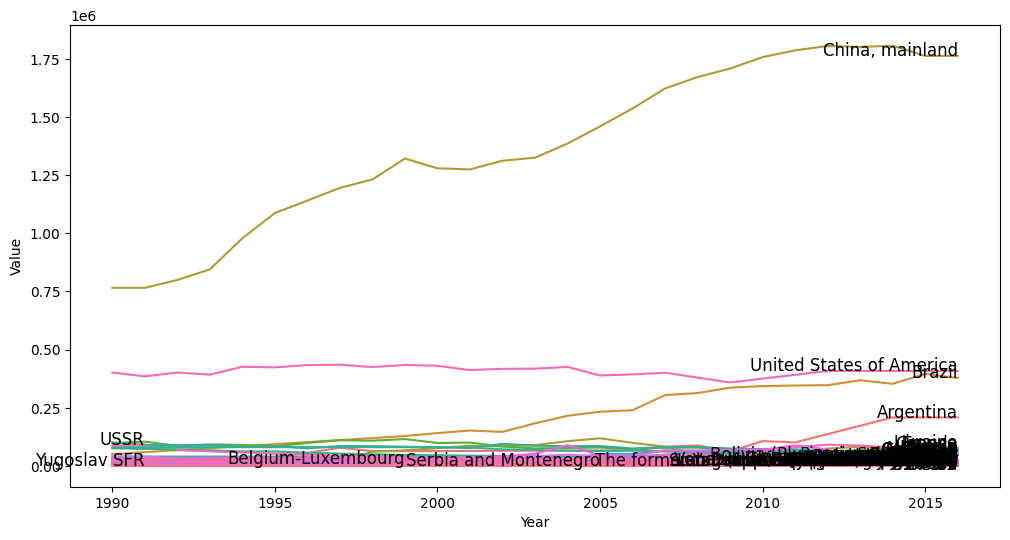

In [198]:
# podemos hacer un plot del valor de pesticidas por area y anio.
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=pesticides, x='Year', y='Value', hue='Area')

for area in pesticides.Area.unique():
    area_df = pesticides[pesticides['Area'] == area]
    lastx = area_df['Year'].iloc[-1]
    lasty = area_df['Value'].iloc[-1]
    plt.text(lastx, lasty, area, fontsize=12, ha='right')

ax.legend().remove()

Interesantemente, en las ultimas decadas, el uso de pesticidas ha ido en gran aumento para 4 Paises. China Estados Unidos, Brasil y Argentina.
## Rainfall
Iniciaremos ahora un trabajo mas exhaustivo sobre el dataframe de Rainfall

In [199]:
rainfall.describe(include='all')

Area         Year  average_rain_fall_mm_per_year
count          6727  6727.000000                    5947.000000
unique          217          NaN                            NaN
top     Afghanistan          NaN                            NaN
freq             31          NaN                            NaN
mean            NaN  2001.354839                    1124.743232
std             NaN     9.530114                     786.257365
min             NaN  1985.000000                      51.000000
25%             NaN  1993.000000                     534.000000
50%             NaN  2001.000000                    1010.000000
75%             NaN  2010.000000                    1651.000000
max             NaN  2017.000000                    3240.000000

En principio, tenemos datos de 217 paises desde 1985 hasta 2017.

In [200]:
rainfall.rename(columns={' Area': 'Area'}, inplace=True)

Veamos la distribucion de estos datos. 

c:\Users\legutierrezf\OneDrive - Indra\Documentos\Crop Yield Prediction\.venv\Lib\site-packages\seaborn\distributions.py:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  baselines[cols] = curves[cols].shift(1, axis=1).fillna(0)
C:\Users\legutierrezf\AppData\Local\Temp\ipykernel_30652\1241711.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


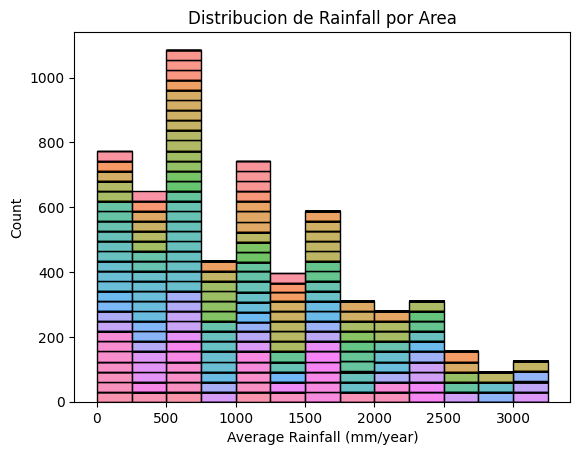

In [201]:
ax = sns.histplot(data=rainfall, x='average_rain_fall_mm_per_year', hue='Area', multiple='stack', bins=np.arange(0, 3500, 250))
plt.title('Distribucion de Rainfall por Area')
plt.xlabel('Average Rainfall (mm/year)')
plt.legend().remove()

In [202]:
#Tenemos varios valores faltantes en 'average_rain_fall_mm_per_year'
rainfall[rainfall.average_rain_fall_mm_per_year.isna()]

Area  Year  average_rain_fall_mm_per_year
93           American Samoa  1985                            NaN
94           American Samoa  1986                            NaN
95           American Samoa  1987                            NaN
96           American Samoa  1989                            NaN
97           American Samoa  1990                            NaN
...                     ...   ...                            ...
6598  Virgin Islands (U.S.)  2013                            NaN
6599  Virgin Islands (U.S.)  2014                            NaN
6600  Virgin Islands (U.S.)  2015                            NaN
6601  Virgin Islands (U.S.)  2016                            NaN
6602  Virgin Islands (U.S.)  2017                            NaN

[780 rows x 3 columns]

In [203]:
rainfall.groupby('Area')['average_rain_fall_mm_per_year'].apply(lambda x: x.isnull().mean()).sort_values(ascending=False)

Area
American Samoa        1.0
Bermuda               1.0
Aruba                 1.0
Greenland             1.0
Gibraltar             1.0
                     ... 
Vietnam               0.0
West Bank and Gaza    0.0
Yemen                 0.0
Zambia                0.0
Zimbabwe              0.0
Name: average_rain_fall_mm_per_year, Length: 217, dtype: float64

Con Excepcion de bahamas, hay paises que tienen un 100% de valores faltantes. Sin embargo, sospecho que son paises pequenos, o con poca poblacion.

No me parece mala idea completar con la media global. Mi suposicion es que para estos paises pequenios, una media global es lo suficientemente representativa. No uso un promedio porque los datos son claramente no gaussianos

In [204]:
rainfall['average_rain_fall_mm_per_year_fillna_mean'] = rainfall.groupby('Year')['average_rain_fall_mm_per_year'].transform(lambda x: x.fillna(x.median()))

In [205]:
rainfall

Area  Year  average_rain_fall_mm_per_year  \
0     Afghanistan  1985                          327.0   
1     Afghanistan  1986                          327.0   
2     Afghanistan  1987                          327.0   
3     Afghanistan  1989                          327.0   
4     Afghanistan  1990                          327.0   
...           ...   ...                            ...   
6722     Zimbabwe  2013                          657.0   
6723     Zimbabwe  2014                          657.0   
6724     Zimbabwe  2015                          657.0   
6725     Zimbabwe  2016                          657.0   
6726     Zimbabwe  2017                          657.0   

      average_rain_fall_mm_per_year_fillna_mean  
0                                         327.0  
1                                         327.0  
2                                         327.0  
3                                         327.0  
4                                         327.0  
...                                         ...  
6722                                      657.0  
6723                                      657.0  
6724                                      657.0  
6725                                      657.0  
6726                                      657.0  

[6727 rows x 4 columns]

## Temperatura
Iniciamos la exploracion del dataset de temperaturas

In [206]:
temp = pd.read_csv(f'{path}/temp.csv')

temp.head()

year        country  avg_temp
0  1849  Côte D'Ivoire     25.58
1  1850  Côte D'Ivoire     25.52
2  1851  Côte D'Ivoire     25.67
3  1852  Côte D'Ivoire       NaN
4  1853  Côte D'Ivoire       NaN

In [207]:
temp.describe(include='all')

year        country      avg_temp
count   71311.000000          71311  68764.000000
unique           NaN            137           NaN
top              NaN  United States           NaN
freq             NaN          11973           NaN
mean     1905.799007            NaN     16.183876
std        67.102099            NaN      7.592960
min      1743.000000            NaN    -14.350000
25%      1858.000000            NaN      9.750000
50%      1910.000000            NaN     16.140000
75%      1962.000000            NaN     23.762500
max      2013.000000            NaN     30.730000

Esta tabla contiene informacion de la temperatura media por anio y pais. Hay algunos valores faltantes. El periodo abarca desde 1743 hasta 2013. Hay que tener en cuenta esto ya que por ejemplo, los datos derainfall abarcan hasta 2017. Ademas vemos 137 countries, difiriendo de los 217 en rainfall o 168 en Pesticides.

In [208]:
avg_temp = temp.groupby('year').avg_temp.mean()
med_temp = temp.groupby('year').avg_temp.median()
#ax = sns.lineplot(data= avg_temp, color='black', linewidth = 2 , label='Media Global')


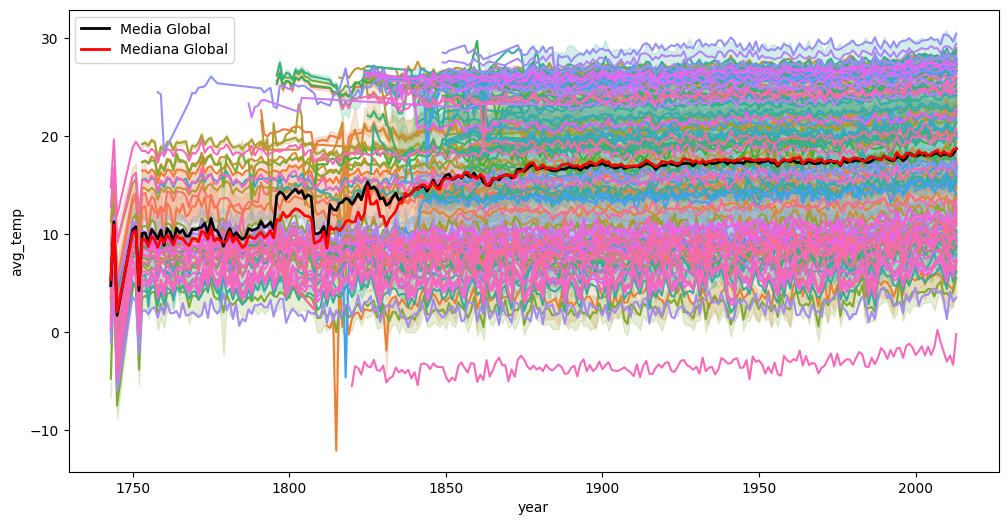

In [209]:
# Ploteemos la media de temperatura por anio. La media tambien
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=temp, x = 'year', y = 'avg_temp', hue='country', label = None, legend=False)
ax = sns.lineplot(data= avg_temp, color='black', linewidth = 2 , label='Media Global')
ax = sns.lineplot(data= med_temp, color='red', linewidth = 2 , label='Mediana Global')
plt.legend()

Puede apreciarse un aumento de la temperatura media global , Si bien hay mas registros de temperatura desde el 1800, la tendencia es clara.

Hay valores nulos, analicemoslos

In [210]:
nulls_temp_mean = temp.groupby(['country', 'year'])['avg_temp'].apply(lambda x: x.isnull().mean()).sort_values(ascending=False).reset_index()
nulls_temp_mean[(nulls_temp_mean['avg_temp'] > 0) & (nulls_temp_mean.year > 1891)].sort_values(by='year', ascending=False)

Empty DataFrame
Columns: [country, year, avg_temp]
Index: []

Una inspeccion revela que a partir del 1891 no hay datos faltantes para los paises en los que tenemos datos. Por lo tanto, no es necesario hacer un fillna. SImplemente podemos eliminar los datos faltantes.

## Yield
Exploremos lo que llamamos yield y yield2

In [211]:
yield_df.head()

Domain Code Domain  Area Code         Area  Element Code Element  Item Code  \
0          QC  Crops          2  Afghanistan          5419   Yield         56   
1          QC  Crops          2  Afghanistan          5419   Yield         56   
2          QC  Crops          2  Afghanistan          5419   Yield         56   
3          QC  Crops          2  Afghanistan          5419   Yield         56   
4          QC  Crops          2  Afghanistan          5419   Yield         56   

    Item  Year Code  Year   Unit  Value  
0  Maize       1961  1961  hg/ha  14000  
1  Maize       1962  1962  hg/ha  14000  
2  Maize       1963  1963  hg/ha  14260  
3  Maize       1964  1964  hg/ha  14257  
4  Maize       1965  1965  hg/ha  14400

In [212]:
yield_df.describe(include='all')

Domain Code Domain     Area Code                              Area  \
count        56717  56717  56717.000000                             56717   
unique           1      1           NaN                               212   
top             QC  Crops           NaN  Democratic Republic of the Congo   
freq         56717  56717           NaN                               560   
mean           NaN    NaN    125.650422                               NaN   
std            NaN    NaN     75.120195                               NaN   
min            NaN    NaN      1.000000                               NaN   
25%            NaN    NaN     58.000000                               NaN   
50%            NaN    NaN    122.000000                               NaN   
75%            NaN    NaN    184.000000                               NaN   
max            NaN    NaN    351.000000                               NaN   

        Element Code Element     Item Code   Item     Year Code          Year  \
count        56717.0   56717  56717.000000  56717  56717.000000  56717.000000   
unique           NaN       1           NaN     10           NaN           NaN   
top              NaN   Yield           NaN  Maize           NaN           NaN   
freq             NaN   56717           NaN   8631           NaN           NaN   
mean          5419.0     NaN    111.611651    NaN   1989.669570   1989.669570   
std              0.0     NaN    101.278435    NaN     16.133198     16.133198   
min           5419.0     NaN     15.000000    NaN   1961.000000   1961.000000   
25%           5419.0     NaN     56.000000    NaN   1976.000000   1976.000000   
50%           5419.0     NaN    116.000000    NaN   1991.000000   1991.000000   
75%           5419.0     NaN    125.000000    NaN   2004.000000   2004.000000   
max           5419.0     NaN    489.000000    NaN   2016.000000   2016.000000   

         Unit           Value  
count   56717    56717.000000  
unique      1             NaN  
top     hg/ha             NaN  
freq    56717             NaN  
mean      NaN    62094.660084  
std       NaN    67835.932856  
min       NaN        0.000000  
25%       NaN    15680.000000  
50%       NaN    36744.000000  
75%       NaN    86213.000000  
max       NaN  1000000.000000

Una primera inspeccion revela que Domain, Domain Code, Element, y Unit No tienen sentido para el analisis, ya que no aportan informacion relevante. Siempre tienen el mismo valor. Sin embargo hay que apreciar que el valor de produccion se mide en hg/ha

Ademas, no se encuentran valores nulos. El periodo de datos abara desde 1061 hasta 2016. Se poseen 10 items en 212 areas.

In [213]:
yield_df = yield_df[["Area", "Area Code", "Year", "Year Code", "Item", "Item Code", "Value"]]
yield_df.head()

Area  Area Code  Year  Year Code   Item  Item Code  Value
0  Afghanistan          2  1961       1961  Maize         56  14000
1  Afghanistan          2  1962       1962  Maize         56  14000
2  Afghanistan          2  1963       1963  Maize         56  14260
3  Afghanistan          2  1964       1964  Maize         56  14257
4  Afghanistan          2  1965       1965  Maize         56  14400

In [214]:
# Ademas, Year y Year Code son iguales, por lo que podemos eliminar uno de ellos
(yield_df.Year == yield_df['Year Code']).mean()
yield_df = yield_df.drop(columns=['Year Code'])

In [215]:
yield_df.groupby(["Item Code", "Item"]).count().sort_values(by='Value', ascending=False)

Area  Area Code  Year  Value
Item Code Item                                              
56        Maize                 8631       8631  8631   8631
116       Potatoes              7876       7876  7876   7876
27        Rice, paddy           6469       6469  6469   6469
122       Sweet potatoes        6356       6356  6356   6356
15        Wheat                 6160       6160  6160   6160
125       Cassava               5718       5718  5718   5718
83        Sorghum               5511       5511  5511   5511
236       Soybeans              4192       4192  4192   4192
137       Yams                  3150       3150  3150   3150
489       Plantains and others  2654       2654  2654   2654

Tenemos ademas que item code y item son equivalentes. Con maize y potatos como los mas comunes.


In [216]:
yield_df = yield_df.drop(columns=['Item Code'])

In [217]:
# lo mismo sucede para Area y Area Code
yield_df.groupby(["Area", "Area Code"]).count().sort_values(by='Value', ascending=False)

Year  Item  Value
Area                               Area Code                   
Democratic Republic of the Congo   250         560   560    560
Nigeria                            159         560   560    560
United Republic of Tanzania        215         560   560    560
Venezuela (Bolivarian Republic of) 236         532   532    532
Cameroon                           32          528   528    528
...                                            ...   ...    ...
Estonia                            63           50    50     50
Djibouti                           72           36    36     36
Sudan                              276          35    35     35
Montenegro                         273          33    33     33
South Sudan                        277          20    20     20

[212 rows x 3 columns]

In [218]:
yield_df = yield_df.drop(columns=['Area Code'])

In [219]:
yield_df.head()

Area  Year   Item  Value
0  Afghanistan  1961  Maize  14000
1  Afghanistan  1962  Maize  14000
2  Afghanistan  1963  Maize  14260
3  Afghanistan  1964  Maize  14257
4  Afghanistan  1965  Maize  14400

Tenemos entonces la produccion por area, anio y cultivo. Nos interesa entender la produccion de cada cultivo por año

### Analisis por cultivo

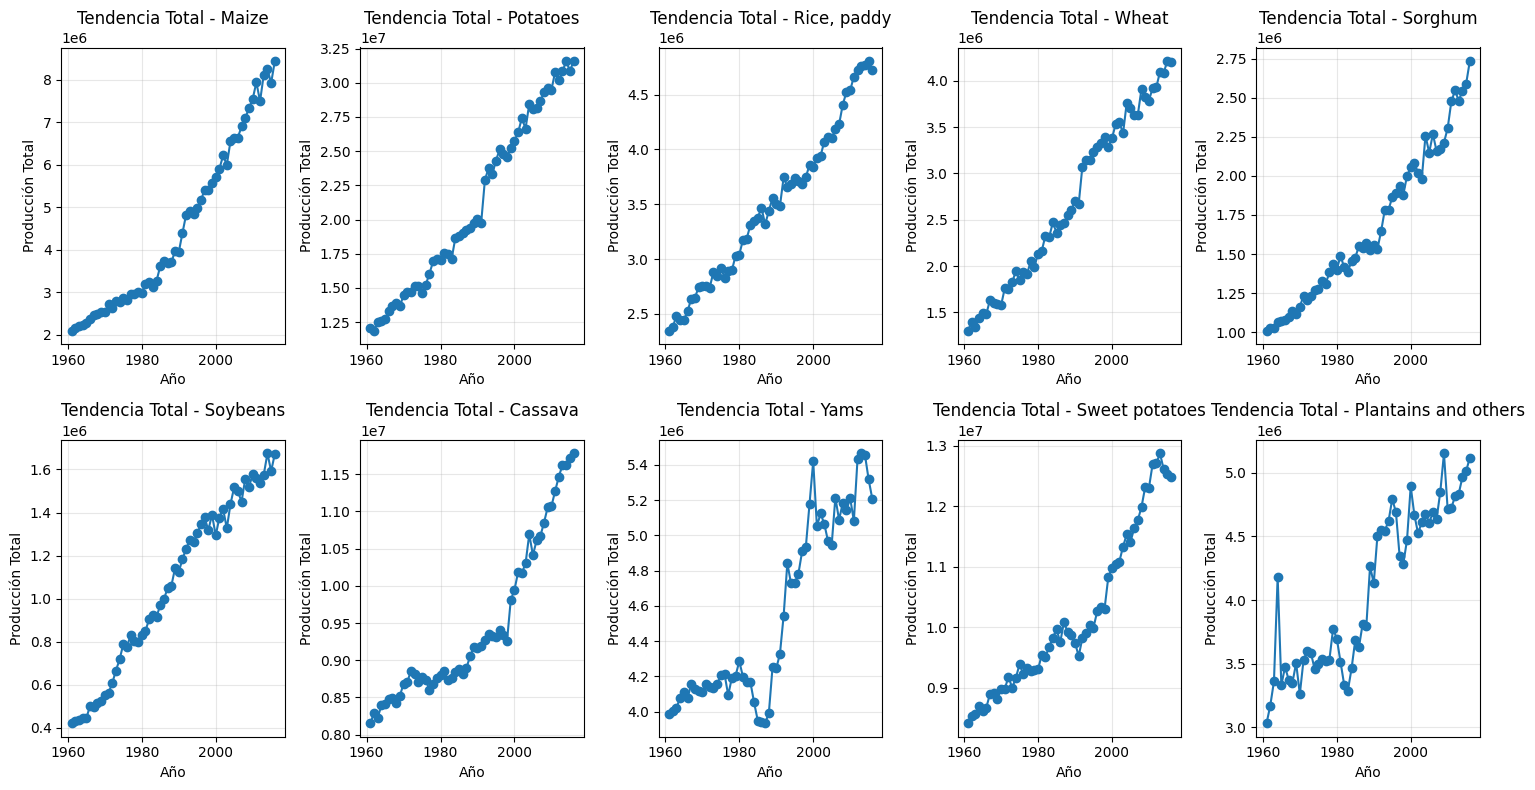

In [220]:
plt.figure(figsize=(15, 8))
    
for i, cultivo in enumerate(yield_df['Item'].unique()):
    plt.subplot(2, 5, i+1)
    data_cultivo = yield_df[yield_df['Item'] == cultivo]
    tendencia_anual = data_cultivo.groupby('Year')['Value'].sum()
    
    plt.plot(tendencia_anual.index, tendencia_anual.values, marker='o')
    plt.title(f'Tendencia Total - {cultivo}')
    plt.xlabel('Año')
    plt.ylabel('Producción Total')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

Vemos una tendencia creciente en todos los casos, aunque con algun que otro declive. Potatos y casava se encuentran dentr de lo que mas se produce actualmente


In [221]:
stats_crecimiento = []
for cultivo in yield_df['Item'].unique():
    for area in yield_df['Area'].unique():
        yield_por_anio_cultivo = yield_df[(yield_df['Item'] == cultivo) & (yield_df['Area'] == area)].sort_values('Year')
        if len(yield_por_anio_cultivo) > 1:
        # Calcular tasa de crecimiento promedio
            valores = yield_por_anio_cultivo['Value'].values
            años = len(valores)
            if valores[0] > 0 and valores[-1] > 0:
                tasa_crecimiento = ((valores[-1] - valores[0]) / valores[0]) * 100
                stats_crecimiento.append({
                'item': cultivo,
                'area': area,
                'tasa_crecimiento': tasa_crecimiento,
                'volatilidad': np.std(valores) / np.mean(valores) * 100
            })
stats_crecimiento_df = pd.DataFrame(stats_crecimiento)


In [222]:
stats_crecimiento_df.nlargest(10, 'tasa_crecimiento')

item                            area  tasa_crecimiento  \
819         Soybeans                      Tajikistan       6350.000000   
609          Sorghum                         Algeria       5551.789660   
614          Sorghum                      Azerbaijan       3403.460208   
84             Maize                          Jordan       3377.258647   
661          Sorghum                          Jordan       2850.791158   
155            Maize            Syrian Arab Republic       2035.982093   
534            Wheat                          Kuwait       1855.280000   
767         Soybeans                         Georgia       1685.843230   
10             Maize                         Bahamas       1300.719964   
1087  Sweet potatoes  Occupied Palestinian Territory       1259.745000   

      volatilidad  
819    111.616845  
609    125.106731  
614    110.704599  
84      92.323233  
661     97.506941  
155     78.633721  
534     39.144492  
767     62.121850  
10      91.986881  
1087    21.658058

Estos son los paises con mayor tasa de crecimiento en produccion por cultivo. Vemos que hay paises que tienen una tasa de crecimiento muy alta, como por ejemplo Jordan y Occupied Palestine. 
### Analisis por cultivo anio y region


 Nos interesa entender la produccion de cada cultivo por año y region

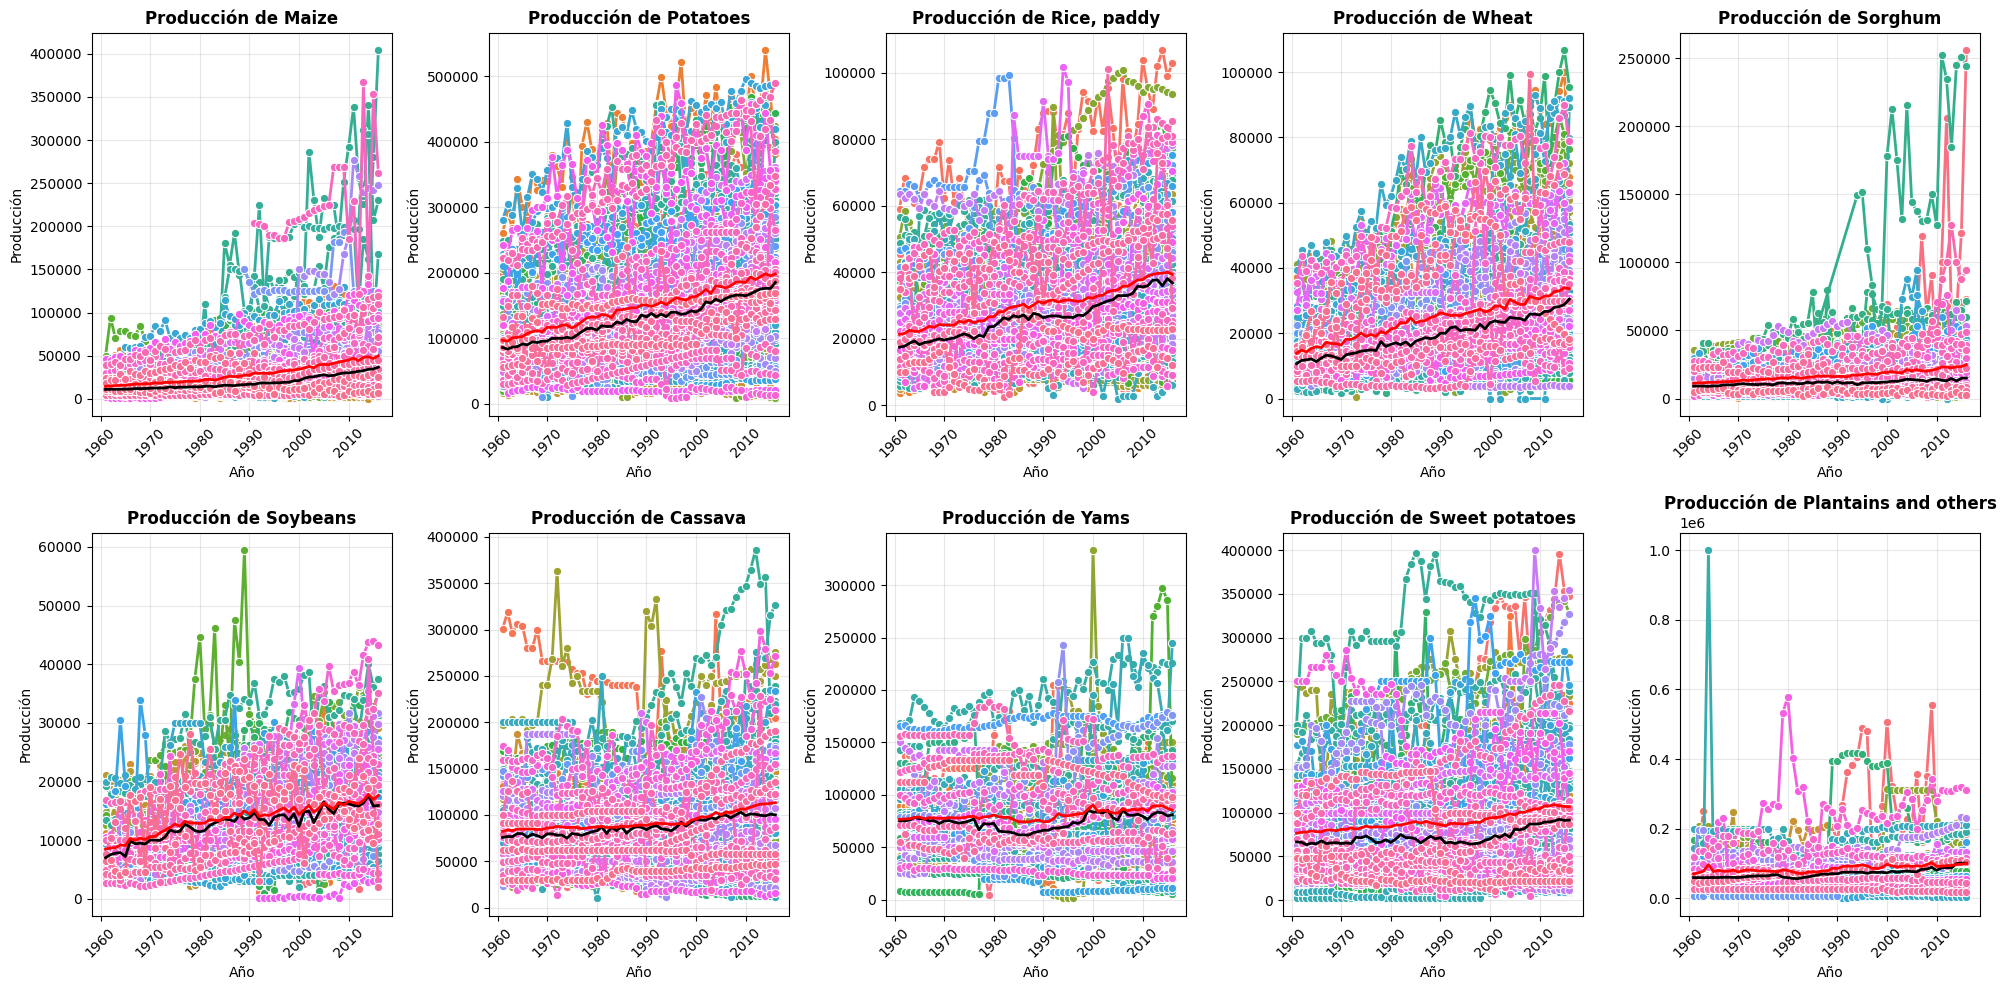

In [223]:
# CODIGO USANDO IA

# Configurar el estilo
plt.style.use('default')
sns.set_palette("husl")

# Obtener la lista de cultivos únicos
cultivos = yield_df['Item'].unique()

# Crear figura con subplots (2 filas, 5 columnas para 10 gráficos)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()  # Convertir matriz 2D en array 1D

# Crear un gráfico para cada cultivo
for i, cultivo in enumerate(cultivos):
    # Filtrar datos para el cultivo actual
    data_cultivo = yield_df[yield_df['Item'] == cultivo]
    median_value = data_cultivo.groupby("Year")['Value'].median().reset_index()
    mean_value = data_cultivo.groupby("Year")['Value'].mean().reset_index()
    
    # Crear gráfico de líneas
    sns.lineplot(data=data_cultivo, 
                x='Year', 
                y='Value', 
                hue='Area',
                ax=axes[i],
                marker='o',
                linewidth=2)
    sns.lineplot(data=median_value, 
                x='Year', 
                y='Value', 
                color='black', 
                linewidth=2, 
                label='Mediana Global', 
                ax=axes[i])
    sns.lineplot(data=mean_value, 
                x='Year',
                y='Value',
                color='red',
                linewidth=2,
                label='Media Global',
                ax=axes[i])
    
    # Personalizar cada subplot
    axes[i].set_title(f'Producción de {cultivo}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Año')
    axes[i].set_ylabel('Producción')
    axes[i].grid(True, alpha=0.3)
    
    # Rotar etiquetas del eje x si es necesario
    axes[i].tick_params(axis='x', rotation=45)
    
    # Ajustar leyenda
    axes[i].legend().remove()

# Ajustar layout´
plt.legend().remove()
plt.tight_layout()
plt.show()

Para Algunos cultivos  se aprecia una clara tendencia creciente de aumento en la produccion media, Por ejemplo Potatoes y Maize. Otros en cambio no. TAl es el caso de Yams o Sweet Potatoes. Ademas, se ve que hay paises que claramente tiene una produccion mayor que otros. Veamos cuales son.

In [224]:
total_production_df = yield_df.groupby(["Area", "Year"])["Value"].sum().reset_index()

top10_df = total_production_df.groupby("Year").apply(lambda x: x.nlargest(10, 'Value')).reset_index(drop=True)
top10_df

C:\Users\legutierrezf\AppData\Local\Temp\ipykernel_30652\2943172809.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top10_df = total_production_df.groupby("Year").apply(lambda x: x.nlargest(10, 'Value')).reset_index(drop=True)


Area  Year   Value
0                        Japan  1961  668065
1                   Guadeloupe  1961  626079
2                   Martinique  1961  555556
3                      Jamaica  1961  523666
4                     Barbados  1961  520225
..                         ...   ...     ...
555                       Mali  2016  931932
556  China, Taiwan Province of  2016  916437
557                      Egypt  2016  913253
558                      Japan  2016  910430
559                     Brazil  2016  862765

[560 rows x 3 columns]

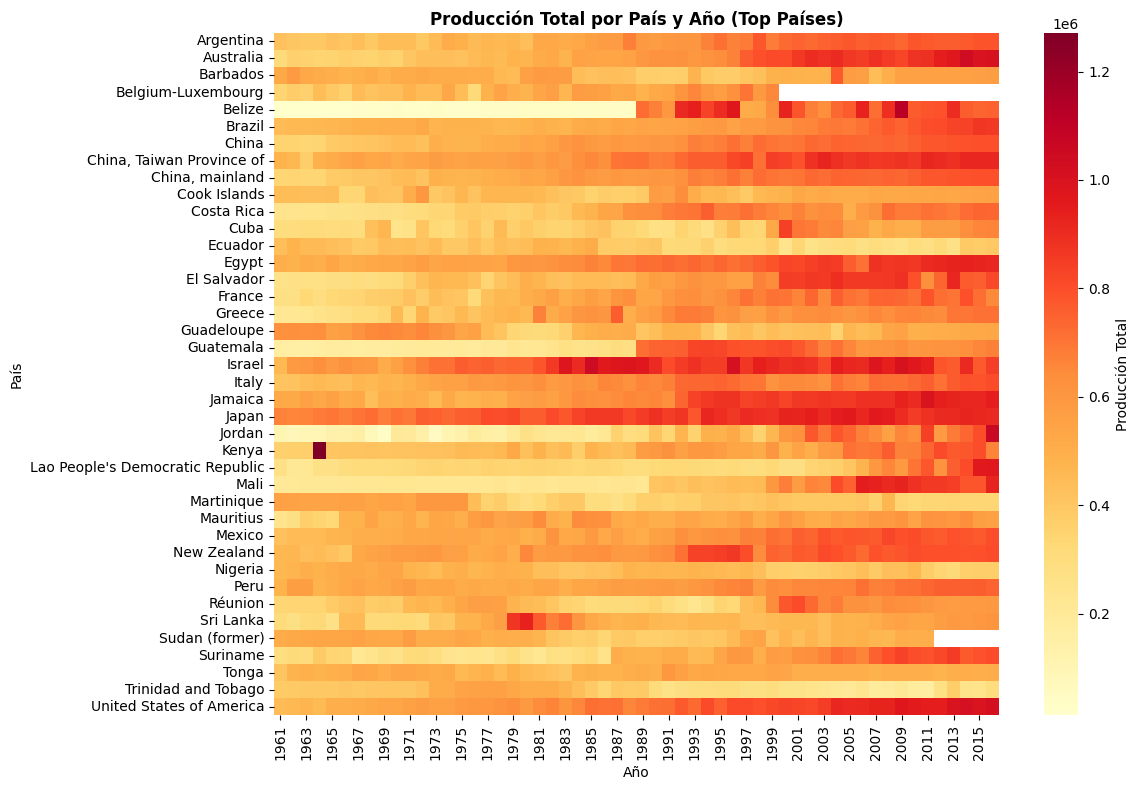

In [225]:
# Graficamos la produccion total
# Grafico hecho con IA

# Obtener países que aparecen frecuentemente en el top 10
top_paises = (top10_df.groupby('Area').size()
              .sort_values(ascending=False)
              .head(40).index)  # Top 50 países más frecuentes

# Filtrar datos solo para estos países
datos_heatmap = total_production_df[total_production_df['Area'].isin(top_paises)]
heatmap_data = datos_heatmap.pivot(index='Area', columns='Year', values='Value')

# Crear heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, cmap='YlOrRd', cbar_kws={'label': 'Producción Total'})
plt.title('Producción Total por País y Año (Top Países)', fontweight='bold')
plt.xlabel('Año')
plt.ylabel('País')
plt.tight_layout()

Estos son los paises que aparecen mayoritariamente en el top 10 de produccion por año. Destacan USA, China, Japon y Austrailia.
INtentemos ver la produccion de cada cultivo por año y area

In [226]:
top5_por_cultivo = yield_df.groupby(['Item', 'Year', "Area"])['Value'].sum().reset_index()
top5_por_cultivo = top5_por_cultivo.groupby(['Item', 'Year']).apply(lambda x: x.nlargest(5, 'Value')).reset_index(drop=True)
top5_por_cultivo

C:\Users\legutierrezf\AppData\Local\Temp\ipykernel_30652\2163478607.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5_por_cultivo = top5_por_cultivo.groupby(['Item', 'Year']).apply(lambda x: x.nlargest(5, 'Value')).reset_index(drop=True)


Item  Year              Area   Value
0     Cassava  1961          Barbados  300667
1     Cassava  1961            Mexico  200000
2     Cassava  1961      Cook Islands  196970
3     Cassava  1961          Thailand  173942
4     Cassava  1961  French Polynesia  168750
...       ...   ...               ...     ...
2795     Yams  2016              Mali  244423
2796     Yams  2016             Japan  225917
2797     Yams  2016          Portugal  176307
2798     Yams  2016  Papua New Guinea  175404
2799     Yams  2016           Jamaica  170549

[2800 rows x 4 columns]

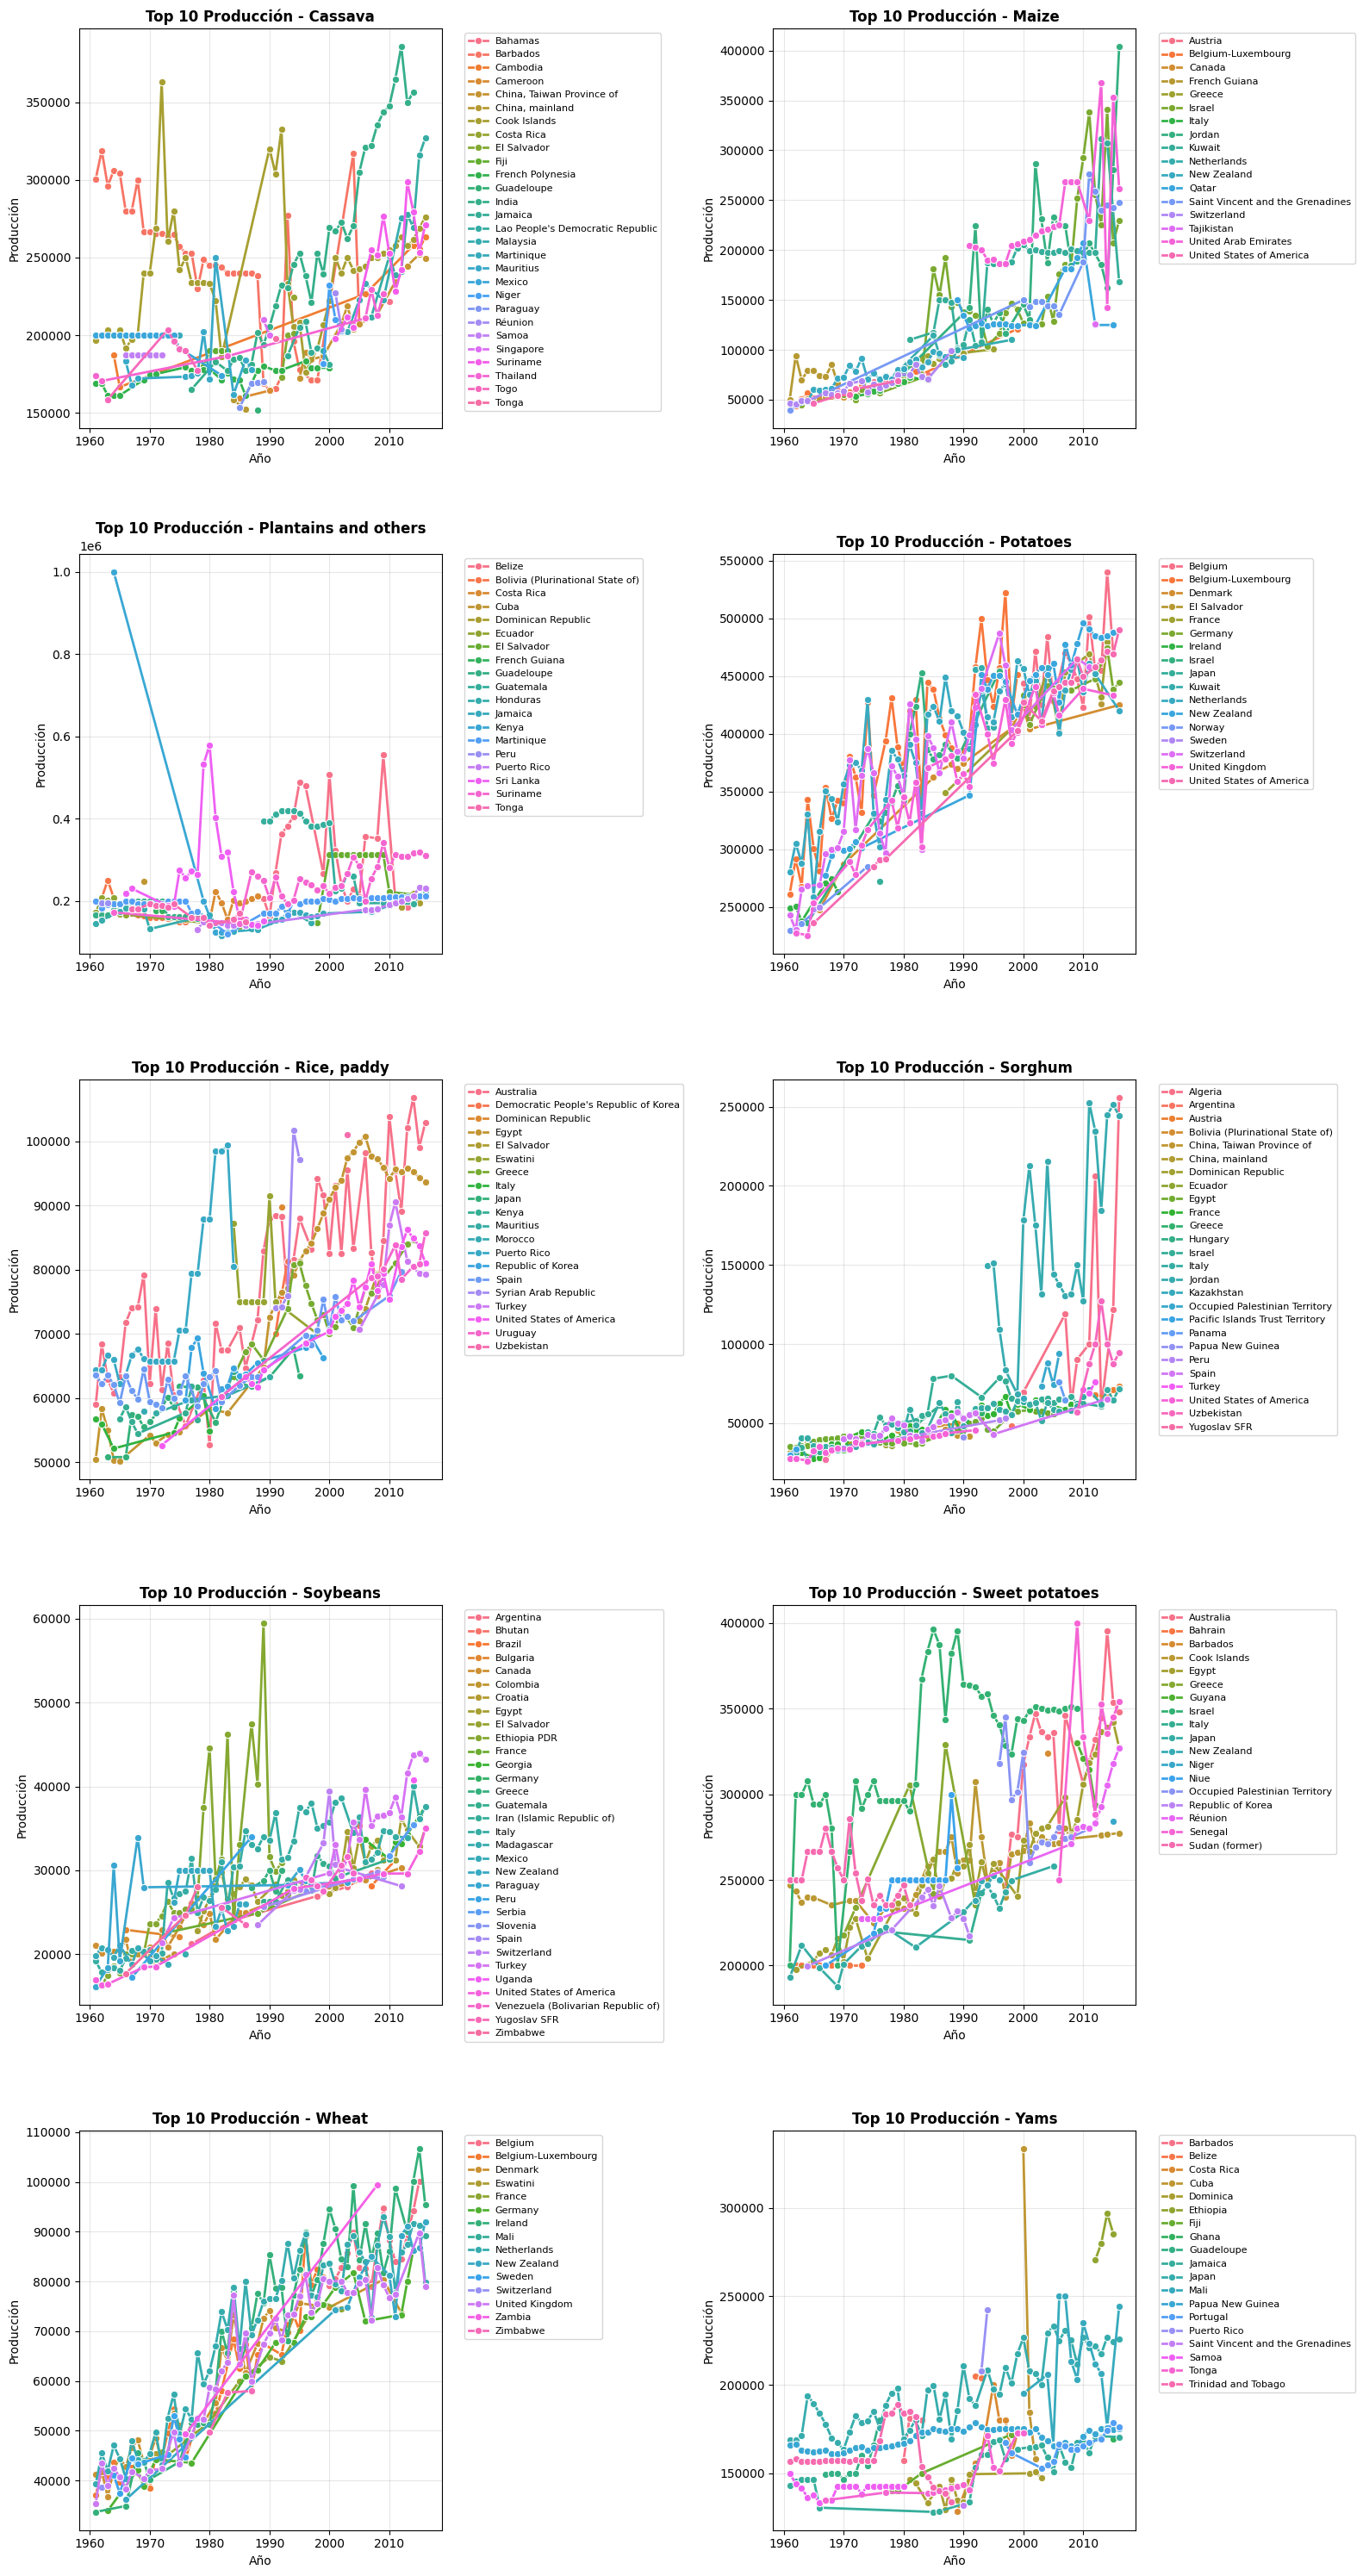

In [227]:
# Grafico hecho con IA
# Para cada cultivo, crear heatmap de top países
# Crear gráficos para cada cultivo
cultivos = top5_por_cultivo['Item'].unique()

# Configurar subplots
ncols = 2
nrows = (len(cultivos) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 6*nrows))
axes = axes.flatten() if nrows > 1 else [axes]

for i, cultivo in enumerate(cultivos):
    
    # Filtrar datos
    data_cultivo = top5_por_cultivo[
        (top5_por_cultivo['Item'] == cultivo)]
    paises_ordenados = sorted(data_cultivo['Area'].unique())

    # Crear gráfico de líneas
    sns.lineplot(data=data_cultivo, 
                x='Year', 
                y='Value', 
                hue='Area',
                hue_order=paises_ordenados,
                ax=axes[i],
                marker='o',
                linewidth=2)
    
    axes[i].set_title(f'Top 10 Producción - {cultivo}', fontweight='bold')
    axes[i].set_xlabel('Año')
    axes[i].set_ylabel('Producción')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Ocultar subplots vacíos
for j in range(len(cultivos), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()

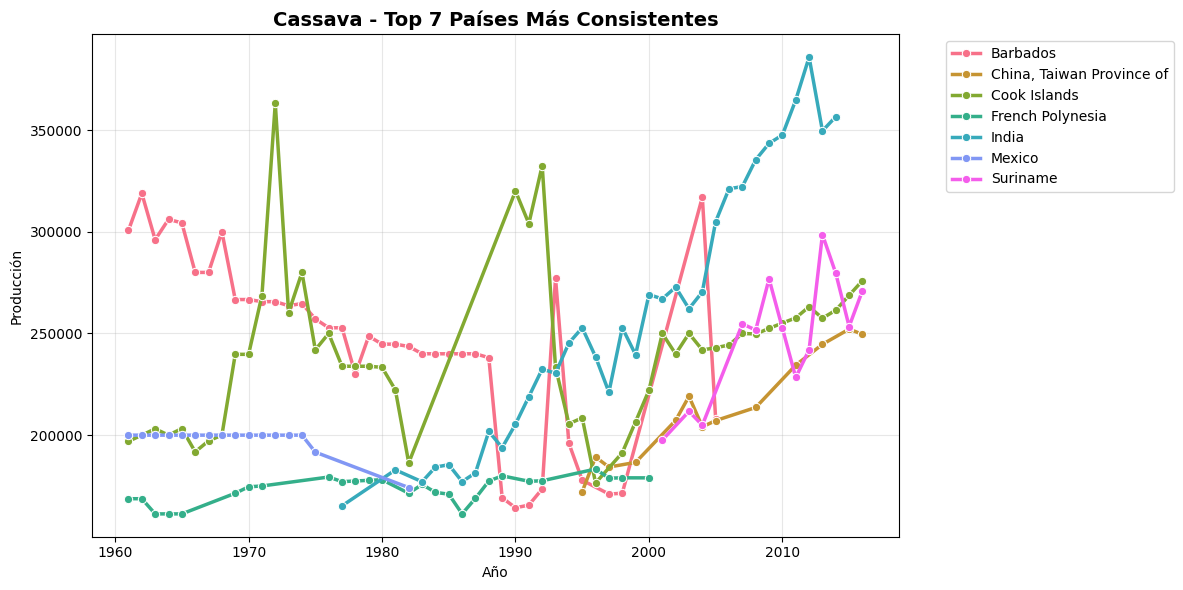

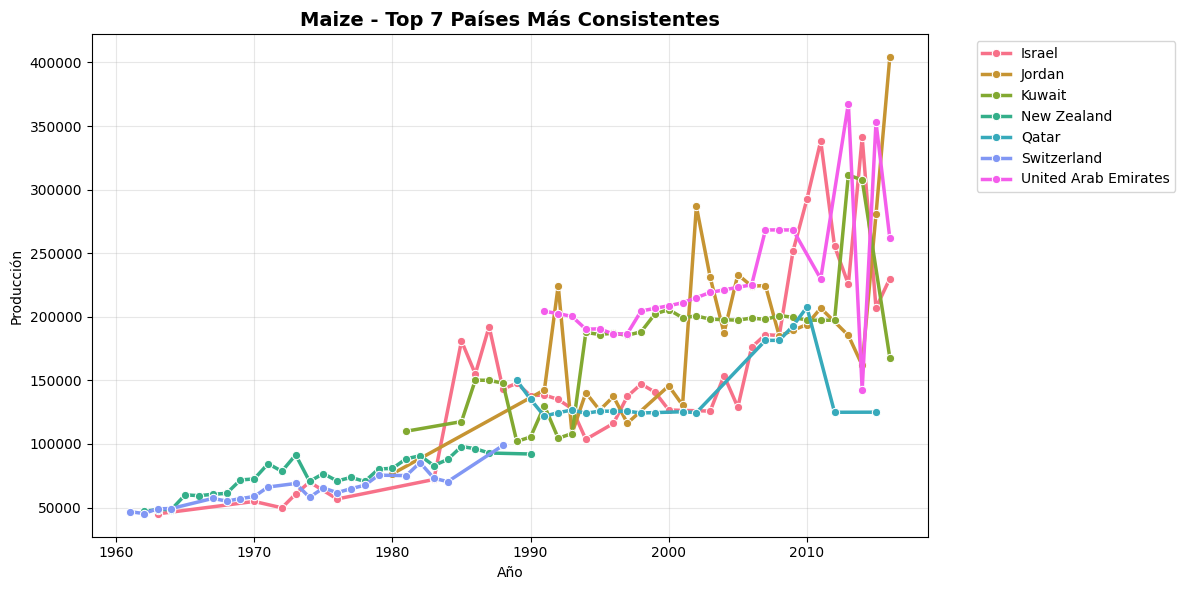

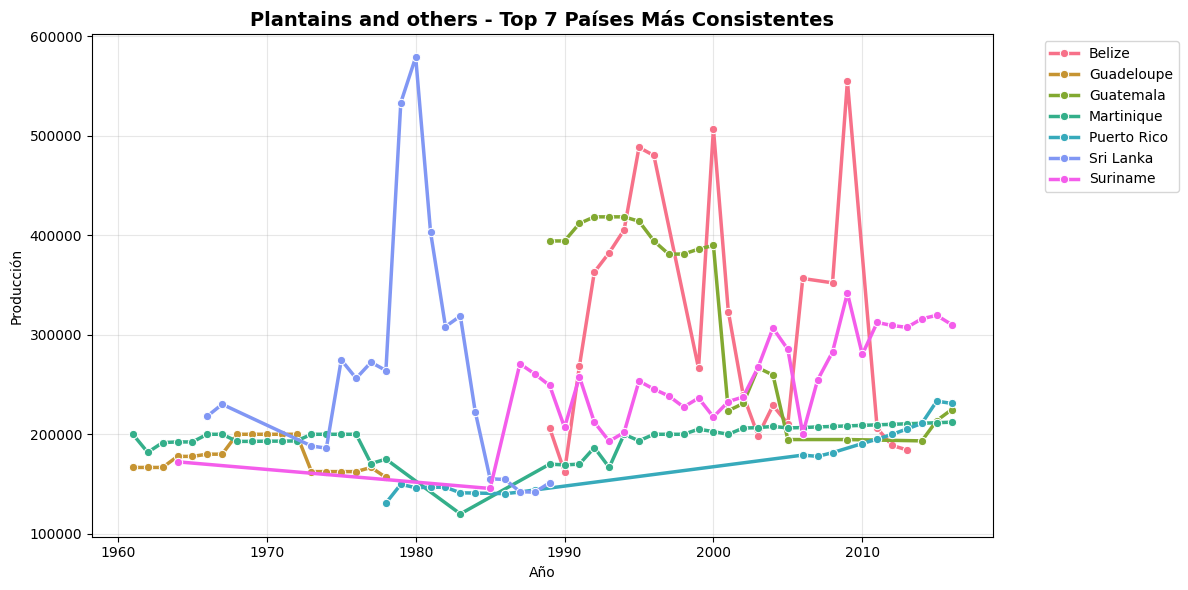

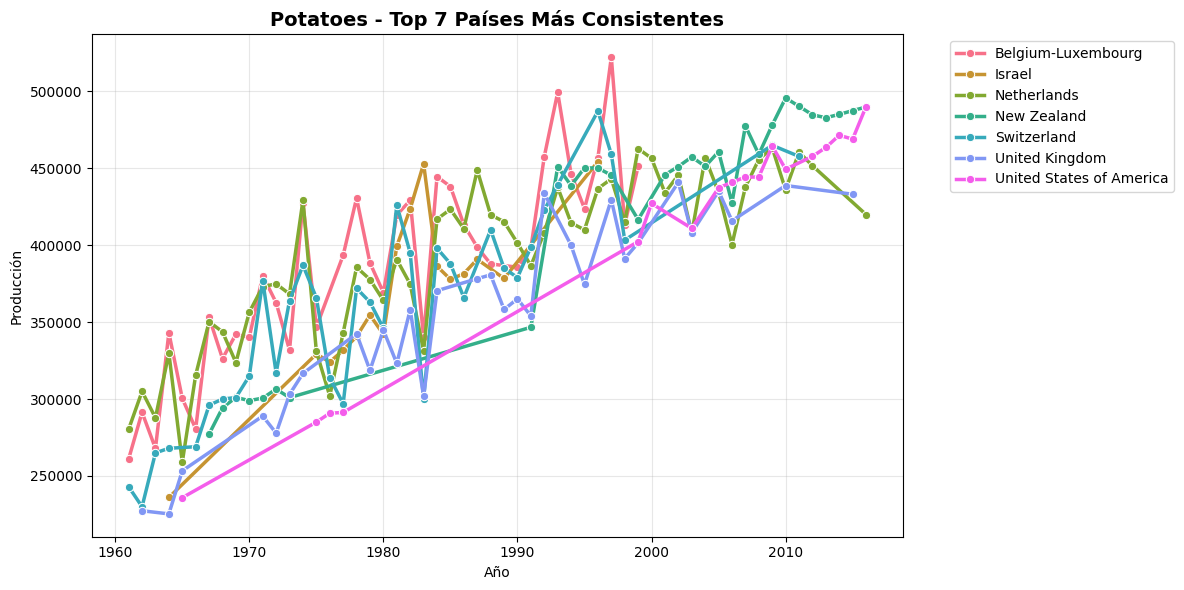

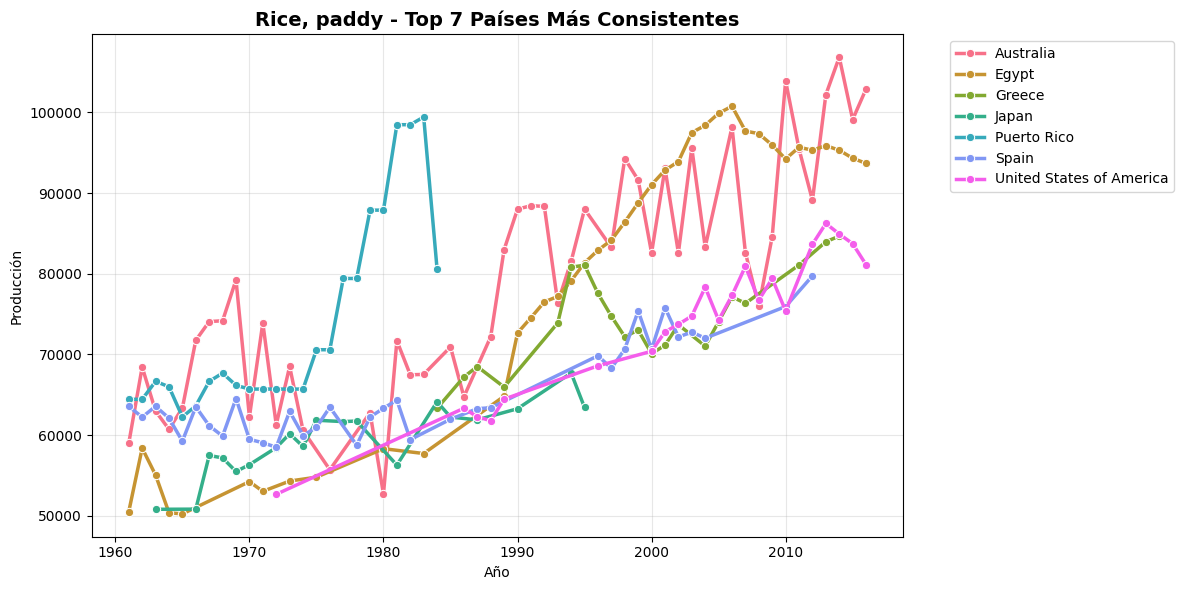

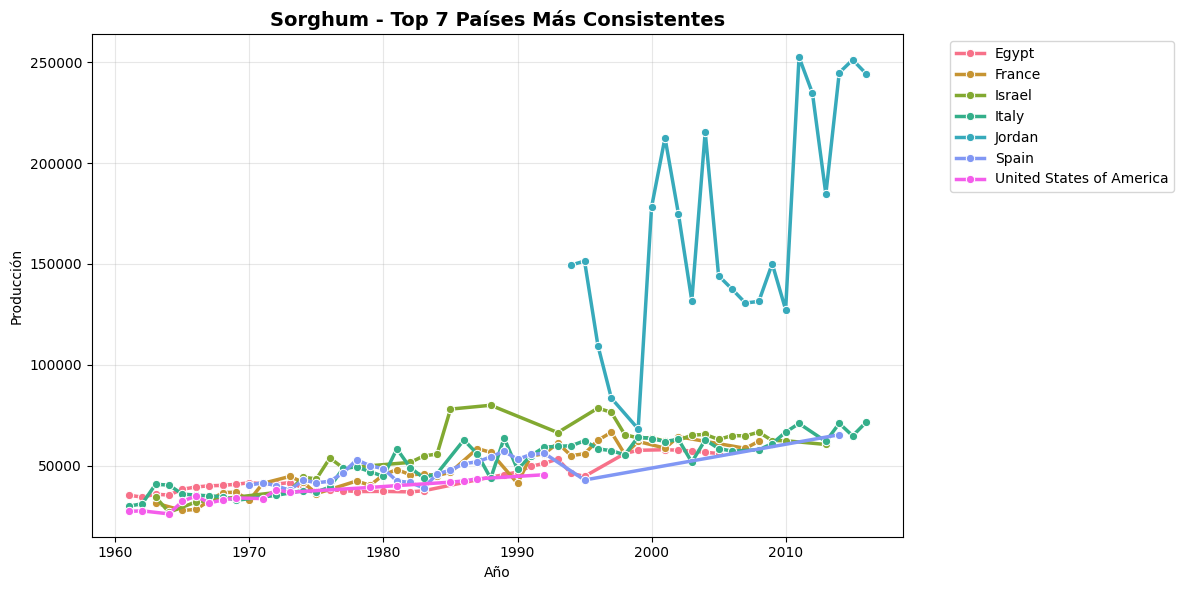

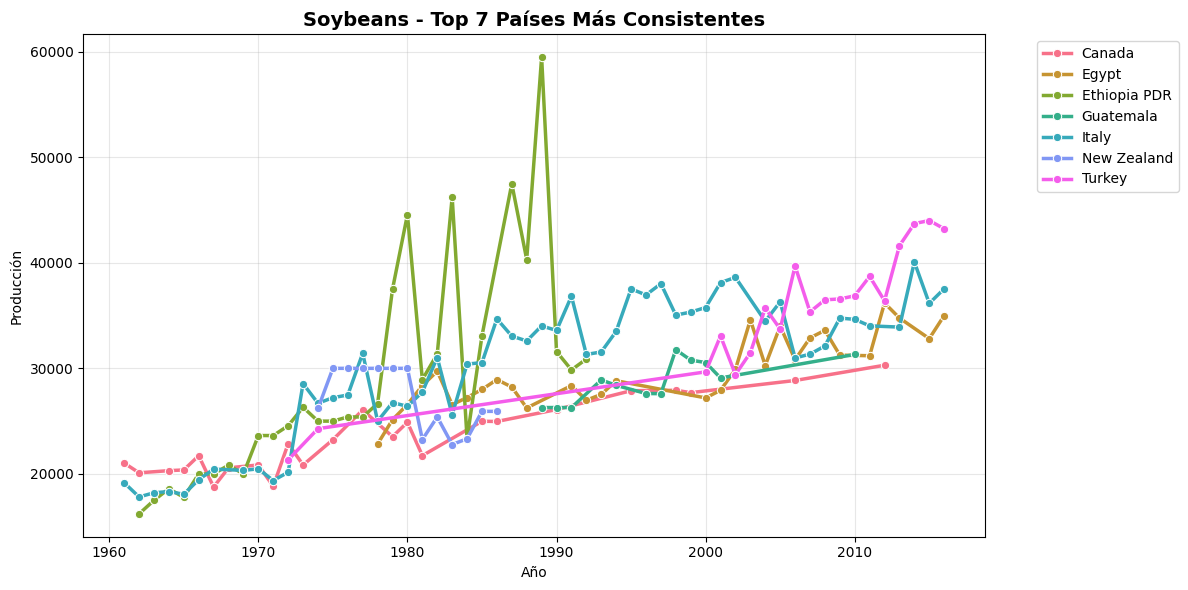

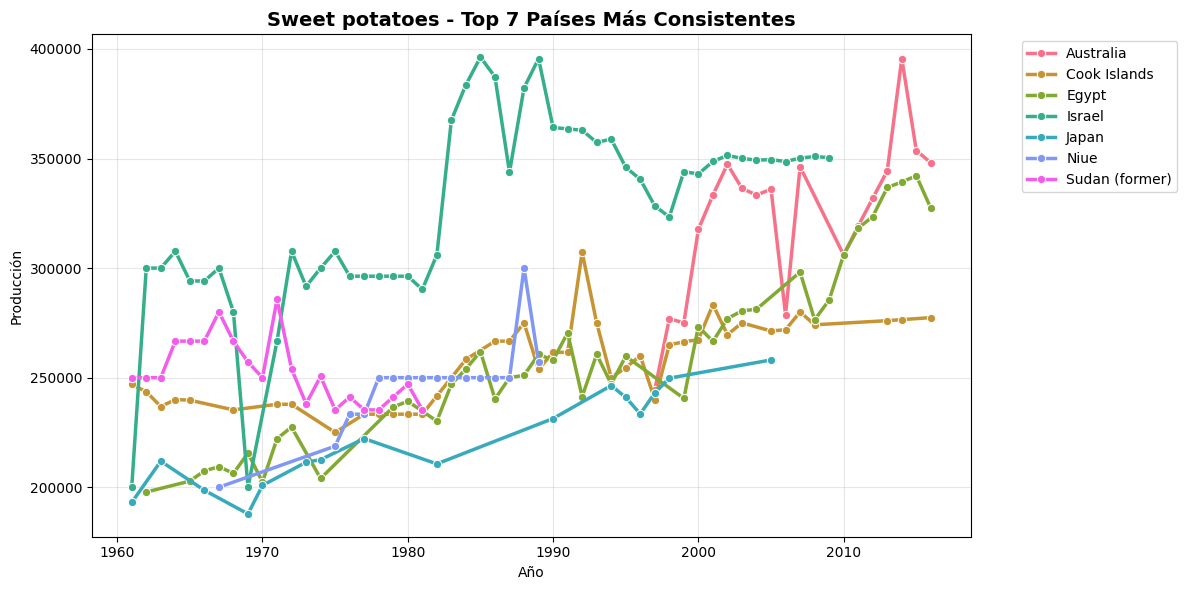

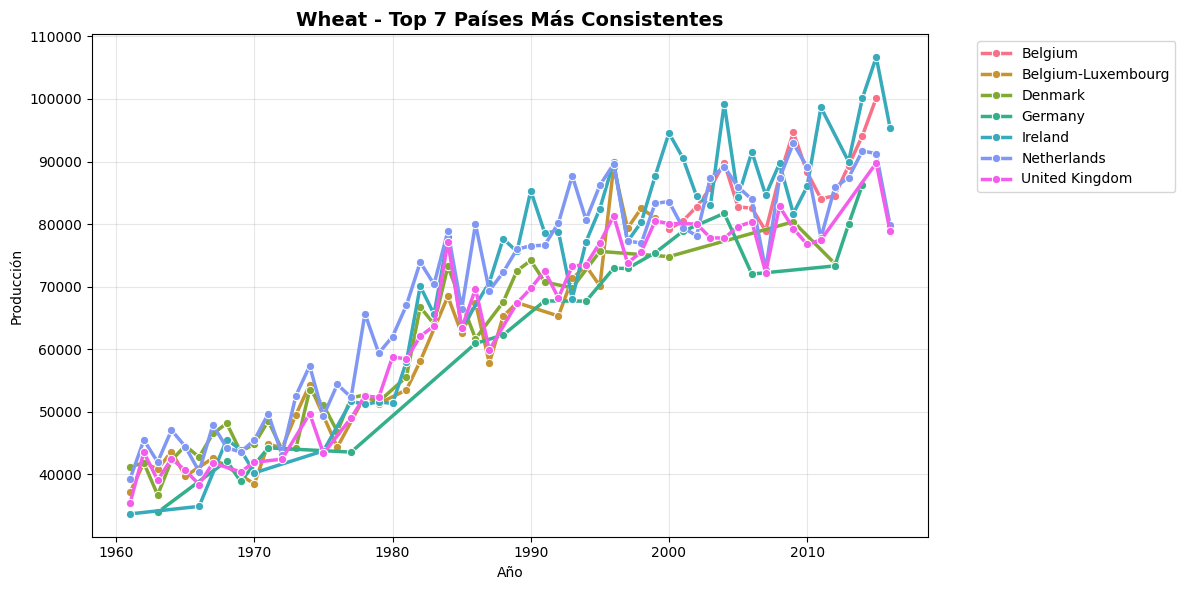

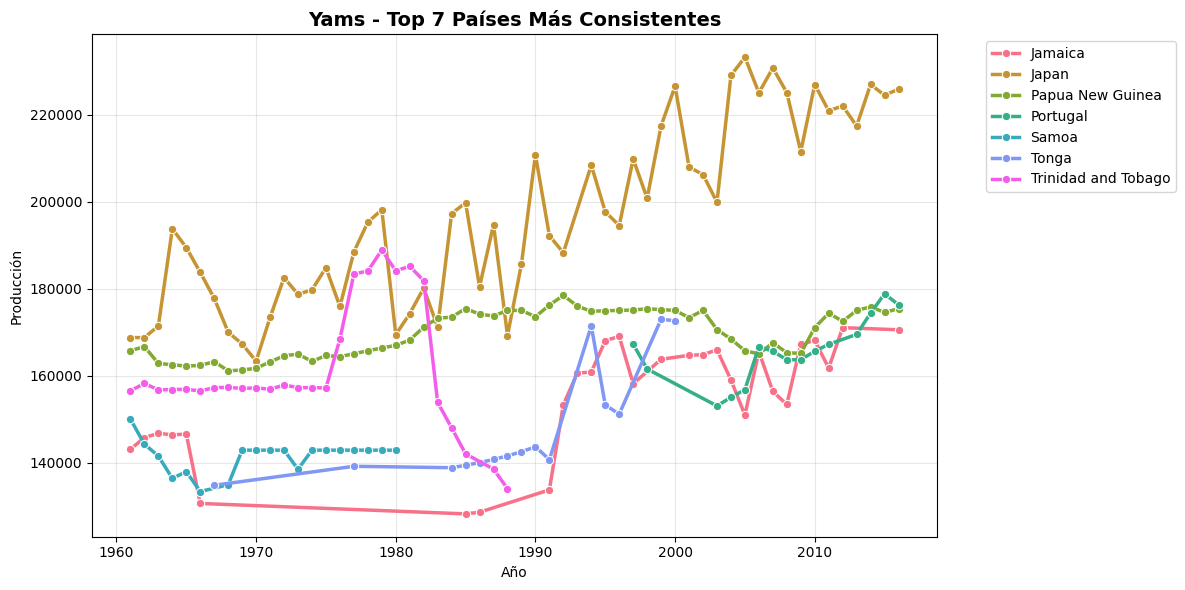

In [228]:
#Me interesa ahora saber que paises se encuentran mayoritariamente en el top 10 de produccion de cada cultivo.
# Grafico hecho con IA
def get_top_n_consistentes(df, cultivo, n=7):
    """
    Obtiene los N países que más frecuentemente aparecen en el top 10
    """
    data_cultivo = df[df['Item'] == cultivo]
    
    # Contar frecuencia de aparición
    frecuencia_paises = data_cultivo['Area'].value_counts().head(n)
    
    return sorted(frecuencia_paises.index.tolist())

# Graficar top 7 países más consistentes por cultivo
for cultivo in cultivos:
    plt.figure(figsize=(12, 6))
    
    # Obtener top 7 países más consistentes
    top_consistentes = get_top_n_consistentes(top5_por_cultivo, cultivo, 7)
    
    # Filtrar datos
    data_cultivo = top5_por_cultivo[
        (top5_por_cultivo['Item'] == cultivo) & 
        (top5_por_cultivo['Area'].isin(top_consistentes))
    ]
    
    # Crear gráfico
    sns.lineplot(data=data_cultivo, 
                x='Year', 
                y='Value', 
                hue='Area',
                hue_order=top_consistentes,
                marker='o',
                linewidth=2.5)
    
    plt.title(f'{cultivo} - Top 7 Países Más Consistentes', 
              fontweight='bold', fontsize=14)
    plt.xlabel('Año')
    plt.ylabel('Producción')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()

Parece que hay nichos por cultivos. Cada cultivo suele tener sus propiospaises lideres en produccion. AUnque hay paises como USA y Egipto que aparecen en varios cultivos.
Esto puede ser interesante para ver si hay correlaciones entre cultivos y paises.

# Analisis avanzados
## Matrices de correlacion de cultivos


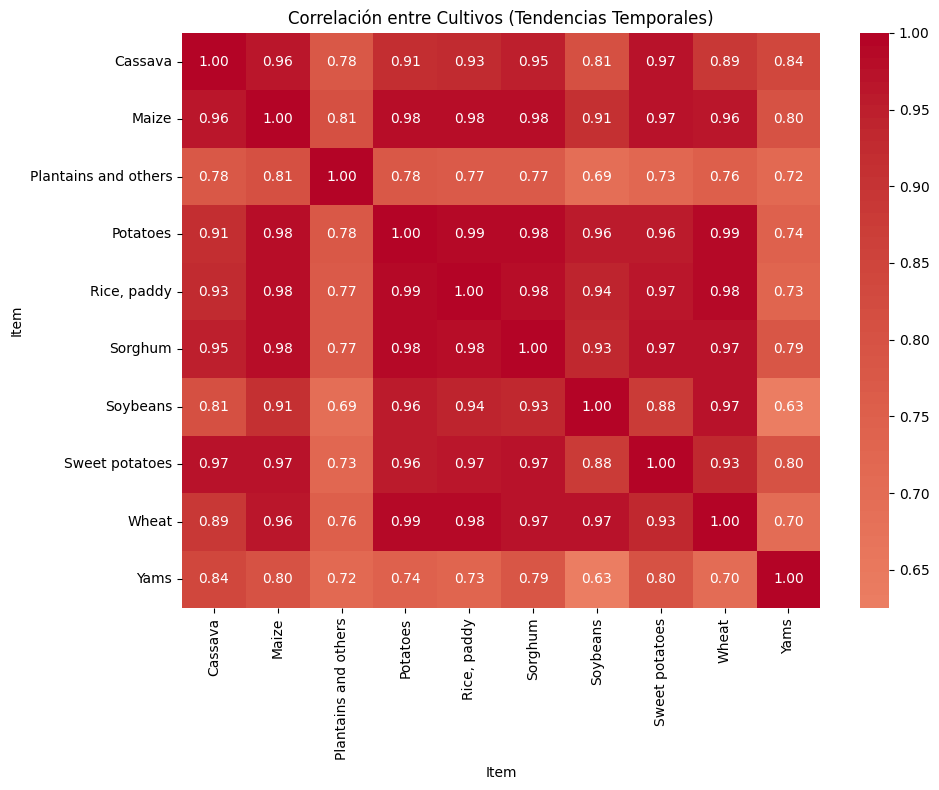

In [229]:
tabla_cultivos = yield_df.groupby(['Year', 'Item'])['Value'].mean().unstack(fill_value=0)
tabla_cultivos_corr = tabla_cultivos.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(tabla_cultivos_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlación entre Cultivos (Tendencias Temporales)')
plt.tight_layout()


La produccion de cultivos parece tener una enorme correlacion positiva entre si. Esto sugiere la implementacion de un modelo de prediccion comun para todos los cultivos, o al menos un modelo por grupo de cultivos que tengan una correlacion alta entre si.

## Analisis de patrones temporales por cultivo

In [230]:
tendencias_temporales = []
for cultivo in yield_df['Item'].unique():
        df_cultivo = yield_df[yield_df['Item'] == cultivo].groupby('Year').Value.mean()
        slope, intercept, r_value, p_value, std_err = linregress(df_cultivo.index, df_cultivo.values)

        volatilidad = np.std(df_cultivo.values) / np.mean(df_cultivo.values) * 100

        tendencias_temporales.append({
            'cultivo': cultivo,
            'slope': slope,
            'intercept': intercept,
            'r_value': r_value,
            'p_value': p_value,
            'std_err': std_err,
            'volatilidad': volatilidad
        })
tendencias_temporales_df = pd.DataFrame(tendencias_temporales)
tendencias_temporales_df

cultivo        slope     intercept   r_value       p_value  \
0                 Maize   640.315557 -1.244593e+06  0.980976  3.966530e-40   
1              Potatoes  1836.682166 -3.505060e+06  0.995243  2.654340e-56   
2           Rice, paddy   330.788989 -6.276717e+05  0.987596  4.169929e-45   
3                 Wheat   342.668235 -6.573838e+05  0.990102  9.724550e-48   
4               Sorghum   218.886997 -4.184239e+05  0.981889  1.064779e-40   
5              Soybeans   145.705670 -2.760960e+05  0.960368  1.233518e-31   
6               Cassava   500.640935 -9.028734e+05  0.907202  5.869069e-22   
7                  Yams   204.940317 -3.268368e+05  0.756811  1.503755e-11   
8        Sweet potatoes   543.419846 -9.909177e+05  0.947533  2.037863e-28   
9  Plantains and others   422.146712 -7.535637e+05  0.789299  4.935860e-13   

     std_err  volatilidad  
0  17.243465    36.793016  
1  24.466899    20.266354  
2   7.156860    17.984624  
3   6.610266    23.296717  
4   5.747476    21.405639  
5   5.754884    17.978824  
6  31.593067     9.627191  
7  24.086680     5.424553  
8  24.947537    10.337340  
9  44.688944    10.066611

Este resultado es muy bueno. Haciendo una regresion temporal del estilo $y = mt + b$ vemos que podemos explicar ampliamente la tendencia de produccion de cada cultivo. Esto se ve en los altos valores de r_value y bajos de p_value. Hay qye destacar sin embargo la alta volatilidad.


Esto ademas, plantea un escenario base y algo que tiene un gran potencial de ser un modelo predictivo

## Analisis Yield vs Pesticides
Iniciaremos ahora un analisis de la relacion entre el uso de pesticidas y el rendimiento de los cultivos. Para esto, primero, unamos los dataframes


In [104]:
yield_pesticides = yield_df.merge(pesticides, on=['Area', 'Year'], how='left', suffixes=('', '_pesticides')) 

In [105]:
yield_pesticides.describe(include='all')

Area          Year   Item           Value  \
count                              56717  56717.000000  56717    56717.000000   
unique                               212           NaN     10             NaN   
top     Democratic Republic of the Congo           NaN  Maize             NaN   
freq                                 560           NaN   8631             NaN   
mean                                 NaN   1989.669570    NaN    62094.660084   
std                                  NaN     16.133198    NaN    67835.932856   
min                                  NaN   1961.000000    NaN        0.000000   
25%                                  NaN   1976.000000    NaN    15680.000000   
50%                                  NaN   1991.000000    NaN    36744.000000   
75%                                  NaN   2004.000000    NaN    86213.000000   
max                                  NaN   2016.000000    NaN  1000000.000000   

        Value_pesticides  
count       2.415300e+04  
unique               NaN  
top                  NaN  
freq                 NaN  
mean        2.677197e+04  
std         1.401406e+05  
min         0.000000e+00  
25%         1.310000e+02  
50%         1.594500e+03  
75%         9.830720e+03  
max         1.807000e+06

Muchos nulos, seguramente debidos a que no todos los paises tienen datos de pesticidas para todos los anios y cultivos.

In [106]:
yield_pesticides_post1990 = yield_pesticides[yield_pesticides.Year > 1990] #  1990 anio minimo en pesticides
yield_pesticides_post1990.describe(include='all')

Area          Year   Item          Value  Value_pesticides
count      28378  28378.000000  28378   28378.000000      2.334800e+04
unique       211           NaN     10            NaN               NaN
top     Cameroon           NaN  Maize            NaN               NaN
freq         260           NaN   4309            NaN               NaN
mean         NaN   2003.620586    NaN   69945.032314      2.700065e+04
std          NaN      7.472551    NaN   75581.348214      1.416493e+05
min          NaN   1991.000000    NaN       0.000000      0.000000e+00
25%          NaN   1997.000000    NaN   18430.250000      1.328400e+02
50%          NaN   2004.000000    NaN   40557.500000      1.597000e+03
75%          NaN   2010.000000    NaN   96508.250000      9.830720e+03
max          NaN   2016.000000    NaN  554855.000000      1.807000e+06

Efectivamente, se reduce ampliamente la cantidad de datos faltantes al filtrar por anios mayores a 1990. 

In [107]:
yield_pesticides_post1990[yield_pesticides_post1990['Value_pesticides'].isna()].Area.value_counts()

Area
Democratic Republic of the Congo         260
Nigeria                                  260
Philippines                              234
China                                    208
Cuba                                     207
Benin                                    202
Democratic People's Republic of Korea    182
Gabon                                    182
Liberia                                  156
Sierra Leone                             156
Eswatini                                 156
Somalia                                  156
Dominica                                 156
Puerto Rico                              146
Micronesia (Federated States of)         136
Réunion                                  130
Grenada                                  130
Saint Vincent and the Grenadines         130
Cambodia                                 130
Uzbekistan                               125
Solomon Islands                          104
Afghanistan                              104
Guade

De una inspeccion rapida, observo que por ejemplo China no aparece porque en pesticides ese nombre se encuentra como 'China, mainland'. QUizas haciendo fuzzy matvhing logremos corregir algunos casos

In [108]:

lista_no_found_in_pesticides = list(yield_pesticides_post1990[yield_pesticides_post1990['Value_pesticides'].isna()].Area.unique())
list_pesticides = list(pesticides.Area.unique())

def normalizar_nombre_pais(nombre):
    nombre = nombre.strip().lower()
    nombre = re.sub(r'[^\w\s]', ' ', nombre)
    nombre = ' '.join(nombre.split())

    reemplazos = {
        'united states of america': 'united states',
        'united states': 'usa',
        'united kingdom': 'uk',
        'republic of korea': 'south korea',
        'korea, republic of': 'south korea',
        'china mainland': 'china',

        ' republic': '',
        ' federation': '',
        ' democratic': '',
        ' peoples': '',
        ' socialist': '',
        'republic of ': '',
        'democratic republic of ': '',
        ' rep ': ' republic ',
        ' dem ': ' democratic ',
        ' fed ': ' federation '}
    
    for buscar, reemplazar in reemplazos.items():
            nombre = nombre.replace(buscar, reemplazar)
    nombre = ' '.join(nombre.split())
    return nombre
lista1_norm = {pais: normalizar_nombre_pais(pais) for pais in list_pesticides}
lista2_norm = {pais: normalizar_nombre_pais(pais) for pais in lista_no_found_in_pesticides}

asignaciones = {}
no_encontrados  = []

for pais_orig, pais_norm in lista1_norm.items():
    mejor_match = process.extractOne(pais_norm, list(lista2_norm.values()), scorer=fuzz.ratio)

    if mejor_match and mejor_match[1] >= 80:
            # Encontrar el país original correspondiente
            pais_destino_orig = [k for k, v in lista2_norm.items() if v == mejor_match[0]][0]
            asignaciones[pais_orig] = pais_destino_orig
    else:
        no_encontrados.append(pais_orig)
asignaciones

{'China, mainland': 'China',
 'Dominican Republic': 'Dominica',
 'Ethiopia': 'Ethiopia PDR',
 'Niger': 'Nigeria'}

In [109]:
no_encontrados

['Albania',
 'Algeria',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belgium-Luxembourg',
 'Belize',
 'Bermuda',
 'Bhutan',
 'Bolivia (Plurinational State of)',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China, Hong Kong SAR',
 'China, Macao SAR',
 'China, Taiwan Province of',
 'Colombia',
 'Comoros',
 'Congo',
 'Cook Islands',
 'Costa Rica',
 "Côte d'Ivoire",
 'Croatia',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Eritrea',
 'Estonia',
 'Fiji',
 'Finland',
 'France',
 'French Polynesia',
 'Gambia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Iran (Islamic Republic of)',
 'Iraq

Esto permite asignar a algunos paises los datos de pesticidas correspondientes. Aunque no se encuentran muchos, es algo. Y se identifica China. QUe era un pais importante

In [110]:
pesticides.Area = pesticides.Area.apply(lambda x: asignaciones.get(x, x))

In [111]:
yield_pesticides = yield_df.merge(pesticides, on=['Area', 'Year'], how='left', suffixes=('', '_pesticides'))
yield_pesticides_post1990 = yield_pesticides[yield_pesticides.Year > 1990] #  1990 anio minimo en pesticides
yield_pesticides_post1990.describe(include='all')

Area          Year   Item          Value  Value_pesticides
count      28378  28378.000000  28378   28378.000000      2.318200e+04
unique       211           NaN     10            NaN               NaN
top     Cameroon           NaN  Maize            NaN               NaN
freq         260           NaN   4309            NaN               NaN
mean         NaN   2003.620586    NaN   69945.032314      2.716627e+04
std          NaN      7.472551    NaN   75581.348214      1.421419e+05
min          NaN   1991.000000    NaN       0.000000      0.000000e+00
25%          NaN   1997.000000    NaN   18430.250000      1.225100e+02
50%          NaN   2004.000000    NaN   40557.500000      1.578000e+03
75%          NaN   2010.000000    NaN   96508.250000      9.855465e+03
max          NaN   2016.000000    NaN  554855.000000      1.807000e+06

Se reduce el numero de valores faltantes en 'Value_pesticides' al aplicar las asignaciones. Al resto les asignaremos la media. Pero luego, me interesa analizar si existe alguna relacion entre el valor de pesticidas aplicado por pais y cultivo y la produccion.

In [112]:
yield_pesticides_post1990_nona = yield_pesticides_post1990.dropna(subset=['Value_pesticides']).sort_values(by=['Area', 'Item', 'Year'])
yield_pesticides_post1990_nona['pesticides_lag1'] = yield_pesticides_post1990_nona.groupby(['Area', 'Item'])['Value_pesticides'].shift(1)
yield_pesticides_post1990_nona['pesticides_lag2'] = yield_pesticides_post1990_nona.groupby(['Area', 'Item'])['Value_pesticides'].shift(2)

In [113]:
yield_pesticides_post1990_nona

Area  Year   Item  Value  Value_pesticides  pesticides_lag1  \
254     Albania  1991  Maize  29068            121.00              NaN   
255     Albania  1992  Maize  24876            121.00           121.00   
256     Albania  1993  Maize  24185            121.00           121.00   
257     Albania  1994  Maize  25848            201.00           121.00   
258     Albania  1995  Maize  31300            251.00           201.00   
...         ...   ...    ...    ...               ...              ...   
56712  Zimbabwe  2012  Wheat  24420           3375.53          3340.35   
56713  Zimbabwe  2013  Wheat  22888           2550.07          3375.53   
56714  Zimbabwe  2014  Wheat  21357           2185.07          2550.07   
56715  Zimbabwe  2015  Wheat  19826           2185.07          2185.07   
56716  Zimbabwe  2016  Wheat  18294           2185.07          2185.07   

       pesticides_lag2  
254                NaN  
255                NaN  
256             121.00  
257             121.00  
258             121.00  
...                ...  
56712          3305.17  
56713          3340.35  
56714          3375.53  
56715          2550.07  
56716          2185.07  

[23182 rows x 7 columns]

In [114]:
resultados_grupos = []
for area in yield_pesticides_post1990_nona.Area.unique():
    for item in yield_pesticides_post1990_nona.Item.unique():
        data_cultivo = yield_pesticides_post1990_nona[(yield_pesticides_post1990_nona['Area'] == area) & (yield_pesticides_post1990_nona['Item'] == item)].dropna()
        if len(data_cultivo) > 2:
            corr_mismo, p_mismo = pearsonr(data_cultivo['Value'], data_cultivo['Value_pesticides'])
            corr_lag1, p_lag1 = pearsonr(data_cultivo['Value'], data_cultivo['pesticides_lag1'])
            corr_lag2, p_lag2 = pearsonr(data_cultivo['Value'], data_cultivo['pesticides_lag2'])

            resultados_grupos.append({
                'area': area,
                'item': item,
                'corr_mismo': corr_mismo,
                'p_mismo': p_mismo,
                'corr_lag1': corr_lag1,
                'p_lag1': p_lag1,
                'corr_lag2': corr_lag2,
                'p_lag2': p_lag2
            })

corr_resultados_df = pd.DataFrame(resultados_grupos)


C:\Users\legutierrezf\AppData\Local\Temp\ipykernel_26244\740259219.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_mismo, p_mismo = pearsonr(data_cultivo['Value'], data_cultivo['Value_pesticides'])
C:\Users\legutierrezf\AppData\Local\Temp\ipykernel_26244\740259219.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_lag1, p_lag1 = pearsonr(data_cultivo['Value'], data_cultivo['pesticides_lag1'])
C:\Users\legutierrezf\AppData\Local\Temp\ipykernel_26244\740259219.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_lag2, p_lag2 = pearsonr(data_cultivo['Value'], data_cultivo['pesticides_lag2'])


In [115]:
corr_resultados_df

area            item  corr_mismo       p_mismo  corr_lag1  \
0     Albania           Maize    0.899269  2.327787e-09   0.905016   
1     Albania        Potatoes    0.903231  1.525818e-09   0.917322   
2     Albania        Soybeans    0.666933  3.717867e-04   0.650464   
3     Albania           Wheat    0.834004  4.125738e-07   0.861007   
4     Algeria           Maize    0.231044  2.773745e-01   0.202101   
..        ...             ...         ...           ...        ...   
919  Zimbabwe         Sorghum   -0.256422  2.264718e-01   0.083439   
920  Zimbabwe        Soybeans   -0.055939  7.951592e-01  -0.074897   
921  Zimbabwe           Wheat   -0.208467  3.282966e-01  -0.232054   
922  Zimbabwe         Cassava    0.266598  2.079299e-01   0.293814   
923  Zimbabwe  Sweet potatoes    0.047483  8.256171e-01   0.269739   

           p_lag1  corr_lag2        p_lag2  
0    1.253861e-09   0.919760  2.103335e-10  
1    2.889797e-10   0.942602  5.878578e-12  
2    5.788760e-04   0.483178  1.676635e-02  
3    6.680737e-08   0.880007  1.454268e-08  
4    3.436110e-01   0.190447  3.727206e-01  
..            ...        ...           ...  
919  6.982953e-01   0.391234  5.869382e-02  
920  7.279741e-01   0.058851  7.847341e-01  
921  2.752210e-01   0.053182  8.050621e-01  
922  1.634595e-01  -0.111250  6.047882e-01  
923  2.024198e-01   0.195609  3.596552e-01  

[924 rows x 8 columns]

C:\Users\legutierrezf\AppData\Local\Temp\ipykernel_26244\1326282041.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


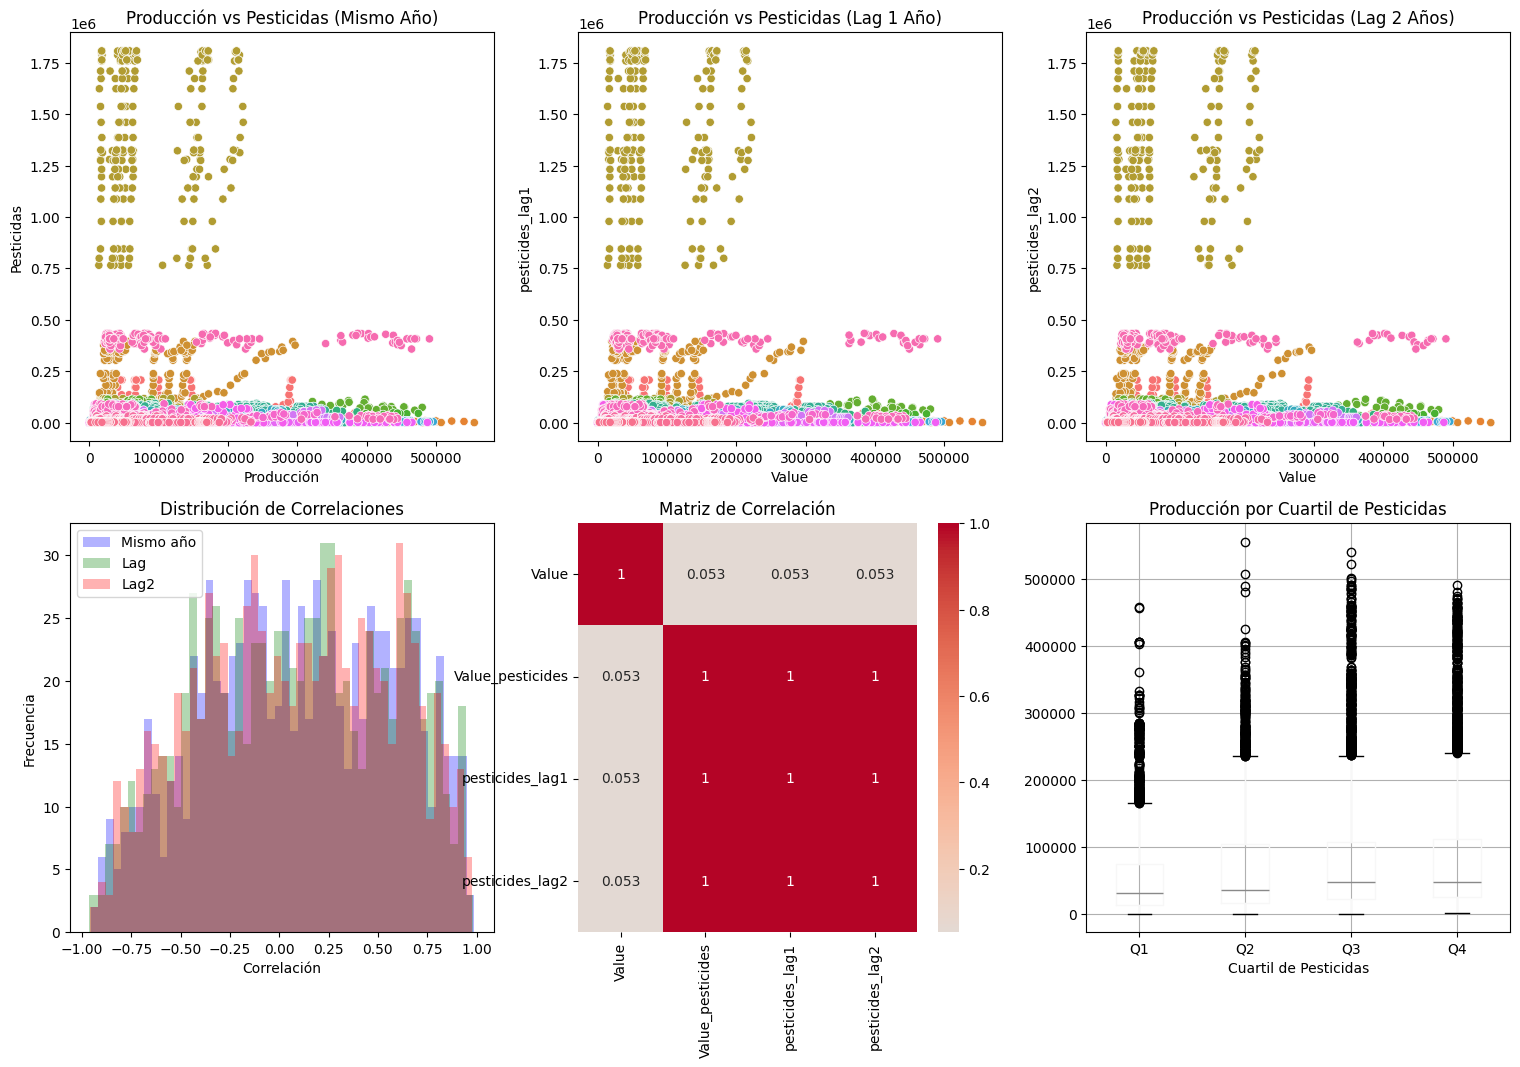

In [116]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
sns.scatterplot(data=yield_pesticides_post1990_nona, x='Value', y='Value_pesticides', hue='Area', ax=axes[0, 0], legend=False)
sns.scatterplot(data=yield_pesticides_post1990_nona, x='Value', y='pesticides_lag1', hue='Area', ax=axes[0, 1], legend=False)
sns.scatterplot(data=yield_pesticides_post1990_nona, x='Value', y='pesticides_lag2', hue='Area', ax=axes[0, 2], legend=False)
axes[0, 0].set_title('Producción vs Pesticidas (Mismo Año)')
axes[0, 1].set_title('Producción vs Pesticidas (Lag 1 Año)')
axes[0, 2].set_title('Producción vs Pesticidas (Lag 2 Años)')
axes[0, 0].set_xlabel('Producción')
axes[0, 0].set_ylabel('Pesticidas')

# A partir de aqui, el codigo es generado por IA

axes[1,0].hist(corr_resultados_df['corr_mismo'], bins=50, alpha=0.3, color='blue', 
                label='Mismo año')
axes[1,0].hist(corr_resultados_df['corr_lag1'], bins=50, alpha=0.3, color='green', 
                label='Lag')
axes[1,0].hist(corr_resultados_df['corr_lag2'], bins=50, alpha=0.3, color='red', 
                label='Lag2')
axes[1,0].set_xlabel('Correlación')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución de Correlaciones')
axes[1,0].legend()

corr_matrix = yield_pesticides_post1990_nona[['Value', 'Value_pesticides', 'pesticides_lag1', 'pesticides_lag2']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Matriz de Correlación')

yield_pesticides_post1990_nona['Pesticides_quartile'] = pd.qcut(yield_pesticides_post1990_nona['Value_pesticides'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
yield_pesticides_post1990_nona.boxplot(column='Value', by='Pesticides_quartile', ax=axes[1,2])
axes[1,2].set_title('Producción por Cuartil de Pesticidas')
axes[1,2].set_xlabel('Cuartil de Pesticidas')
plt.suptitle('')  # Remover título automático

plt.legend().remove()

Si bien hay casos donde existe correlacion positica, sucede tambien lo contrario. Ademas, puede apreciarse que a nivel global el valor de pesticida arrojado no implica un aumento en la produccion.  Notese sin embargo que la distribucion de correlaciones esta inclinada hacia la derecha, esto indica que mayoritariamente existe correlacion positiva.

## Analisis Yield Temperatura

In [117]:
temp.rename(columns={'country': 'Area', 'year': 'Year', 'avg_temp': 'Value'}, inplace=True)
yield_temp = yield_df.merge(temp, on=['Area', 'Year'], how='left', suffixes=('', '_temp'))

In [118]:
yield_temp.describe(include='all')

Area           Year    Item           Value    Value_temp
count   109366  109366.000000  109366   109366.000000  84859.000000
unique     212            NaN      10             NaN           NaN
top      China            NaN   Maize             NaN           NaN
freq     14440            NaN   15650             NaN           NaN
mean       NaN    1988.437046     NaN    65054.711099     19.692466
std        NaN      15.795916     NaN    69140.637005      6.737137
min        NaN    1961.000000     NaN        0.000000     -4.240000
25%        NaN    1975.000000     NaN    16270.250000     15.470000
50%        NaN    1989.000000     NaN    37015.500000     20.680000
75%        NaN    2002.000000     NaN    94200.000000     25.930000
max        NaN    2016.000000     NaN  1000000.000000     30.650000

In [119]:
yield_temp = yield_temp[yield_temp.Year < 2014]
yield_temp = yield_temp[yield_temp.Year > 1960]  # Aseguramos que los datos sean consistentes
yield_temp[yield_temp['Value_temp'].isna()].Area.value_counts()


Area
Democratic Republic of the Congo      530
United Republic of Tanzania           530
Venezuela (Bolivarian Republic of)    502
Bolivia (Plurinational State of)      456
Myanmar                               441
                                     ... 
Iceland                                53
Seychelles                             53
Luxembourg                             42
Djibouti                               33
South Sudan                             8
Name: count, Length: 94, dtype: int64

In [120]:
lista_no_found_in_temp = list(yield_temp[yield_temp['Value_temp'].isna()].Area.unique())
list_temp = list(temp.Area.unique())

def normalizar_nombre_pais(nombre):
    nombre = nombre.strip().lower()
    nombre = re.sub(r'[^\w\s]', ' ', nombre)
    nombre = ' '.join(nombre.split())

    reemplazos = {
        'united states of america': 'united states',
        'united states': 'usa',
        'united kingdom': 'uk',
        'republic of korea': 'south korea',
        'korea, republic of': 'south korea',
        'china mainland': 'china',
        "venezuela bolivarian republic of": "venezuela",
        "bolivia plurinational state of": "bolivia",
        "democratic people's republic of korea": "korea",
        "united republic of tanzania": "tanzania",
        ' republic': '',
        ' federation': '',
        ' democratic': '',
        ' peoples': '',
        ' socialist': '',
        'republic of ': '',
        'democratic republic of ': '',
        ' rep ': ' republic ',
        ' dem ': ' democratic ',
        ' fed ': ' federation '}
    
    for buscar, reemplazar in reemplazos.items():
            nombre = nombre.replace(buscar, reemplazar)
    nombre = ' '.join(nombre.split())
    return nombre
lista1_norm = {pais: normalizar_nombre_pais(pais) for pais in list_temp}
lista2_norm = {pais: normalizar_nombre_pais(pais) for pais in lista_no_found_in_temp}

asignaciones = {}
no_encontrados  = []

for pais_orig, pais_norm in lista1_norm.items():
    mejor_match = process.extractOne(pais_norm, list(lista2_norm.values()), scorer=fuzz.ratio)

    if mejor_match and mejor_match[1] >= 80:
            # Encontrar el país original correspondiente
            pais_destino_orig = [k for k, v in lista2_norm.items() if v == mejor_match[0]][0]
            asignaciones[pais_orig] = pais_destino_orig
    else:
        no_encontrados.append(pais_orig)
asignaciones

{"Côte D'Ivoire": "Côte d'Ivoire",
 'United States': 'United States of America',
 'China': 'China, mainland',
 'Venezuela': 'Venezuela (Bolivarian Republic of)',
 'Guinea Bissau': 'Guinea-Bissau',
 'Russia': 'Russian Federation',
 'Moldova': 'Republic of Moldova',
 'Tanzania': 'United Republic of Tanzania',
 'Ireland': 'Iceland',
 'Vietnam': 'Viet Nam',
 'Bolivia': 'Bolivia (Plurinational State of)',
 'Zambia': 'Gambia',
 'Czech Republic': 'Czechia',
 'Dominican Republic': 'Dominica',
 'Bosnia And Herzegovina': 'Bosnia and Herzegovina',
 'South Korea': 'Republic of Korea'}

In [121]:
# Removemos algunos paises que no son correctos. Sacamos China porque en temp esta China y CHina mainland a la vez
to_drop = ["Iceland", "Gambia", "Czechia", "Dominican Republic", "China"] 
for pais in to_drop:
    asignaciones.pop(pais, None)

In [122]:
temp["Area_fuzzy"] = temp.Area.apply(lambda x: asignaciones.get(x, x))
temp.rename(columns={'Area': 'Area_raw', "Area_fuzzy": "Area"}, inplace=True)

In [123]:
yield_temp = yield_df.merge(temp, on=['Area', 'Year'], how='left', suffixes=('', '_temp'))
yield_temp = yield_temp[yield_temp.Year < 2014]
yield_temp = yield_temp[yield_temp.Year > 1960]  # Aseguramos que los datos sean consistentes


In [124]:
yield_temp.describe(include="all")

Area           Year    Item           Value  \
count                     128752  128752.000000  128752   128752.000000   
unique                       212            NaN      10             NaN   
top     United States of America            NaN   Maize             NaN   
freq                       19292            NaN   18340             NaN   
mean                         NaN    1987.639672     NaN    69429.106391   
std                          NaN      15.316816     NaN    76799.525327   
min                          NaN    1961.000000     NaN        0.000000   
25%                          NaN    1974.000000     NaN    17870.250000   
50%                          NaN    1988.000000     NaN    39306.000000   
75%                          NaN    2001.000000     NaN    95268.750000   
max                          NaN    2013.000000     NaN  1000000.000000   

             Area_raw     Value_temp  
count          110940  110940.000000  
unique            130            NaN  
top     United States            NaN  
freq            19292            NaN  
mean              NaN      18.857782  
std               NaN       6.812156  
min               NaN      -4.240000  
25%               NaN      14.210000  
50%               NaN      19.170000  
75%               NaN      25.560000  
max               NaN      30.650000

El resto sera completado con la media, pero luego. Ahora me interesa ver la correlacion entre la temperatura y el rendimiento de los cultivos


In [125]:
yield_temp = yield_temp.dropna(subset=['Value_temp']).sort_values(by=['Area', 'Item', 'Year'])

In [126]:
yield_temp = yield_temp[['Area', 'Item', 'Year', 'Value', 'Value_temp']]
yield_temp

Area   Item  Year  Value  Value_temp
0       Afghanistan  Maize  1961  14000       14.23
1       Afghanistan  Maize  1962  14000       14.10
2       Afghanistan  Maize  1963  14260       15.01
3       Afghanistan  Maize  1964  14257       13.73
4       Afghanistan  Maize  1965  14400       13.90
...             ...    ...   ...    ...         ...
132071     Zimbabwe  Wheat  2009  30000       20.52
132072     Zimbabwe  Wheat  2010  27681       21.17
132073     Zimbabwe  Wheat  2011  26274       20.78
132074     Zimbabwe  Wheat  2012  24420       20.52
132075     Zimbabwe  Wheat  2013  22888       19.76

[110940 rows x 5 columns]

In [127]:
# Correlacion GLobal
pearson_r, p_value_pearson = pearsonr(yield_temp['Value'], yield_temp['Value_temp'])
spearman_r, p_value_spearman = spearmanr(yield_temp['Value'], yield_temp['Value_temp'])
print(f"Pearson r: {pearson_r}, p-value: {p_value_pearson}")
print(f"Spearman r: {spearman_r}, p-value: {p_value_spearman}")

# Correlacion por Area
correlations = []
areas = yield_temp['Area'].unique()
for area in areas:
    data_area = yield_temp[yield_temp['Area'] == area]
    if len(data_area) > 2:
        corr, p_value = pearsonr(data_area['Value'], data_area['Value_temp'])
        correlations.append({'Area': area, 'Correlation': corr, 'p-value': p_value})
correlations_df = pd.DataFrame(correlations)
correlations_df.sort_values(by='Correlation', ascending=False, inplace=True)

# Correlacion por Item
correlations = []
items = yield_temp['Item'].unique()
for item in items:
    data_item = yield_temp[yield_temp['Item'] == item]
    if len(data_item) > 2:
        corr, p_value = pearsonr(data_item['Value'], data_item['Value_temp'])
        correlations.append({'Item': item, 'Correlation': corr, 'p-value': p_value})
correlations_item_df = pd.DataFrame(correlations)
correlations_item_df.sort_values(by='Correlation', ascending=False, inplace=True)

Pearson r: -0.13888176881555078, p-value: 0.0
Spearman r: -0.1644619708675492, p-value: 0.0


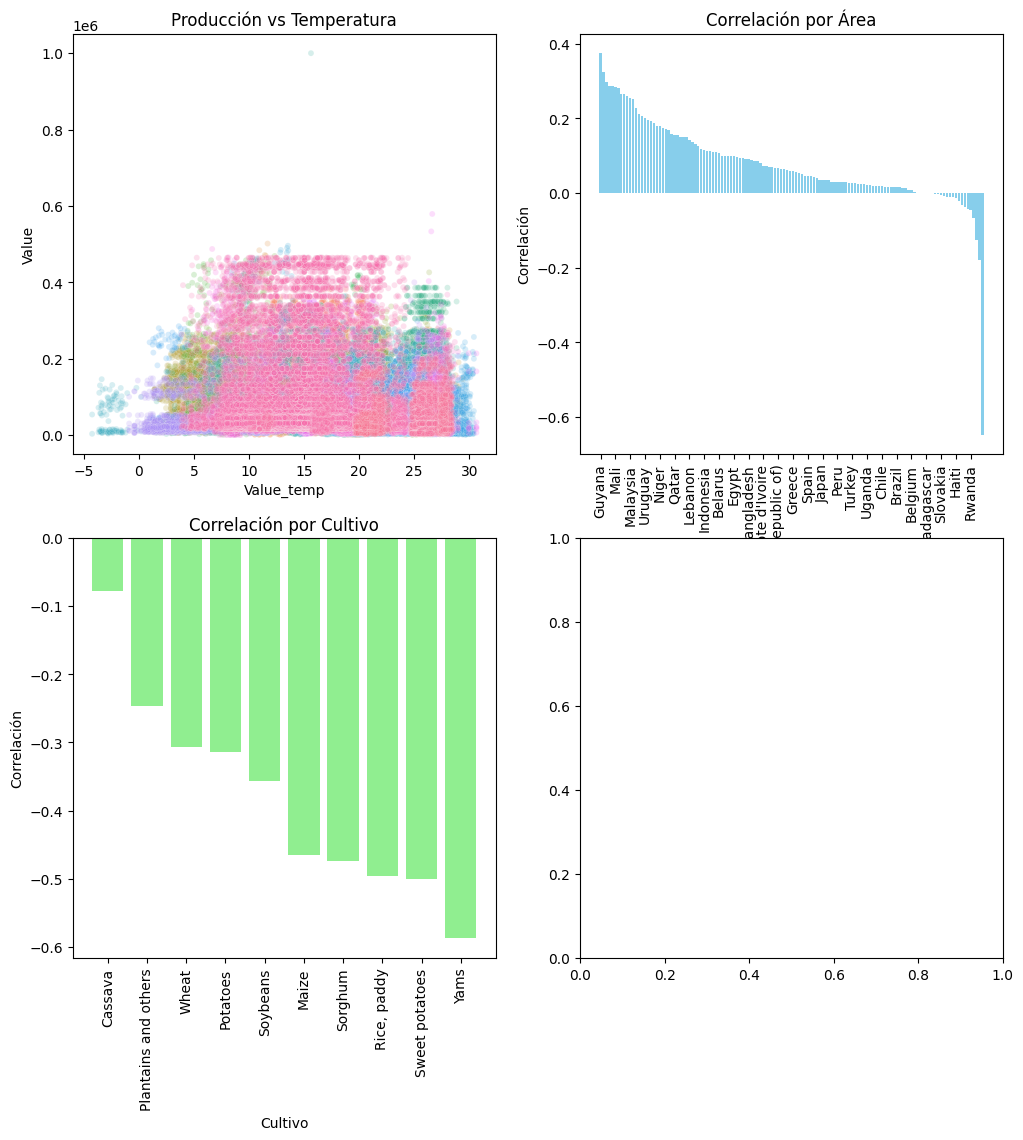

In [128]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.scatterplot(data=yield_temp, x='Value_temp', y='Value', hue='Area', ax=axes[0, 0], alpha = .2, size = .1, legend=False)
axes[0, 0].set_title('Producción vs Temperatura')


axes[0, 1].bar(correlations_df['Area'], correlations_df['Correlation'], color='skyblue')
axes[0, 1].set_title('Correlación por Área')
axes[0, 1].set_xlabel('Área')
axes[0, 1].set_ylabel('Correlación')
xticks = axes[0, 1].get_xticks()
axes[0, 1].set_xticks(xticks[::5])
axes[0, 1].tick_params(axis='x', rotation=90)

axes[1, 0].bar(correlations_item_df['Item'], correlations_item_df['Correlation'], color='lightgreen')
axes[1, 0].set_title('Correlación por Cultivo')
axes[1, 0].set_xlabel('Cultivo')
axes[1, 0].set_ylabel('Correlación')
axes[1, 0].tick_params(axis='x', rotation=90)

#sns.lineplot(data=yield_temp, x='Value_temp', y='Value', ax=axes[0, 0], color='black', linewidth=2)

A nivel global, tenemos correlacion negativa. Esto no tiene mucho sentido, y debe deberse a que los paises con mayor produccion son los que menos temperatura tienen. Lo mismo sucede cuando realizamos la correlacion por cultivo. Esto indica que no es viable realizar un feature asociado a la temperatura que sea global y o por cultivo. Sin embargo, si tiene sentido hacerlo por pais.

En post de obtener un feature que relacione el cultivo con la temperatura, le pedi a la IA que me entregue las temperaturas optimas de produccion para los cultivos considerados.

In [129]:
crop_profiles = {
            'Maize': {'optimal_temp': 25, 'temp_tolerance': 5, 'water_intensive': True, 'tech_responsive': True},
            'Wheat': {'optimal_temp': 18, 'temp_tolerance': 7, 'water_intensive': False, 'tech_responsive': True},
            'Rice': {'optimal_temp': 28, 'temp_tolerance': 4, 'water_intensive': True, 'tech_responsive': True},
            'Soybeans': {'optimal_temp': 23, 'temp_tolerance': 6, 'water_intensive': False, 'tech_responsive': True},
            'Barley': {'optimal_temp': 16, 'temp_tolerance': 8, 'water_intensive': False, 'tech_responsive': False},
            'Cassava': {'optimal_temp': 30, 'temp_tolerance': 3, 'water_intensive': False, 'tech_responsive': False},
            'Potatoes': {'optimal_temp': 20, 'temp_tolerance': 5, 'water_intensive': True, 'tech_responsive': True},
            'Sugar cane': {'optimal_temp': 32, 'temp_tolerance': 4, 'water_intensive': True, 'tech_responsive': False},
        }

In [130]:
def get_crop_profile(crop_name, attribute, default=25):
    for crop, profile in crop_profiles.items():
        if crop.lower() in crop_name.lower():
            return profile.get(attribute, default)
    return default

yield_temp["optimal_temp"] = yield_temp.Item.apply(lambda x: get_crop_profile(x, "optimal_temp", 25))
yield_temp["temp_tolerance"] = yield_temp.Item.apply(lambda x: get_crop_profile(x, "temp_tolerance", 4))

yield_temp["temp_stress"] = (yield_temp["Value_temp"] - yield_temp["optimal_temp"])**2
yield_temp["temp_dentro_optimo"] = np.abs((yield_temp["Value_temp"] - yield_temp["optimal_temp"]) <= yield_temp["temp_tolerance"]).astype(int)

for lag in [1,2]:
    yield_temp[f"temp_lag{lag}"] = yield_temp.Value_temp.shift(lag)



In [131]:
columns = ["temp_stress", "temp_dentro_optimo", "temp_lag1", "temp_lag2"]
correlations = []
for var in columns:
    data_clean = yield_temp[["Value", var]].dropna()

    if len(data_clean) > 5:
        r, p = pearsonr(data_clean["Value"], data_clean[var])
        correlations.append({
            "Var": var,
            "Corr":r,
            "P": p,
            "significativa": p < 0.05
        }
        )

corr_df = pd.DataFrame(correlations)



In [132]:
corr_df

Var      Corr             P  significativa
0         temp_stress -0.005241  8.089188e-02          False
1  temp_dentro_optimo -0.029395  1.207245e-22           True
2           temp_lag1 -0.139213  0.000000e+00           True
3           temp_lag2 -0.139428  0.000000e+00           True

No parece haber una relacion linear fuerte entre estas variables y la produccion. Aunqeu puede que se encuentre en mascarado por el comportamiento global.

In [133]:
# Categorizacion del stress
yield_temp['stress_category'] = pd.cut(yield_temp['temp_stress'], 
                                           bins=[0, 1, 5, 10, float('inf')],
                                           labels=['Bajo', 'Moderado', 'Alto', 'Extremo'],
                                           include_lowest=True)
yield_temp.groupby("stress_category").Value.agg(["mean","std", "median"])


C:\Users\legutierrezf\AppData\Local\Temp\ipykernel_26244\3689496884.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yield_temp.groupby("stress_category").Value.agg(["mean","std", "median"])


mean           std   median
stress_category                                     
Bajo             53662.229502  72327.077655  22513.0
Moderado         56189.378506  73384.159701  24765.0
Alto             67485.146480  78944.983828  29897.0
Extremo          75537.261670  79343.012364  45971.0

In [134]:
# Test de anova para ver relacion entre la categoria de stress y la produccion (Hecho con IA)
from scipy.stats import f_oneway

groups = [yield_temp['Value'].dropna() for name, yield_temp in yield_temp.groupby('stress_category')]
groups = [g for g in groups if len(g) > 0]

if len(groups) > 1:
    f_stat, p_value = f_oneway(*groups)
    print(f"\nANOVA - F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")


ANOVA - F-statistic: 436.4282, p-value: 0.0000


C:\Users\legutierrezf\AppData\Local\Temp\ipykernel_26244\3864906520.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [yield_temp['Value'].dropna() for name, yield_temp in yield_temp.groupby('stress_category')]


EL F statistic dio alto. Esto implica un gran poder predictivo.

Text(0.5, 1.0, 'Distribución de Producción por Nivel de Estrés Térmico\n(Violin)')

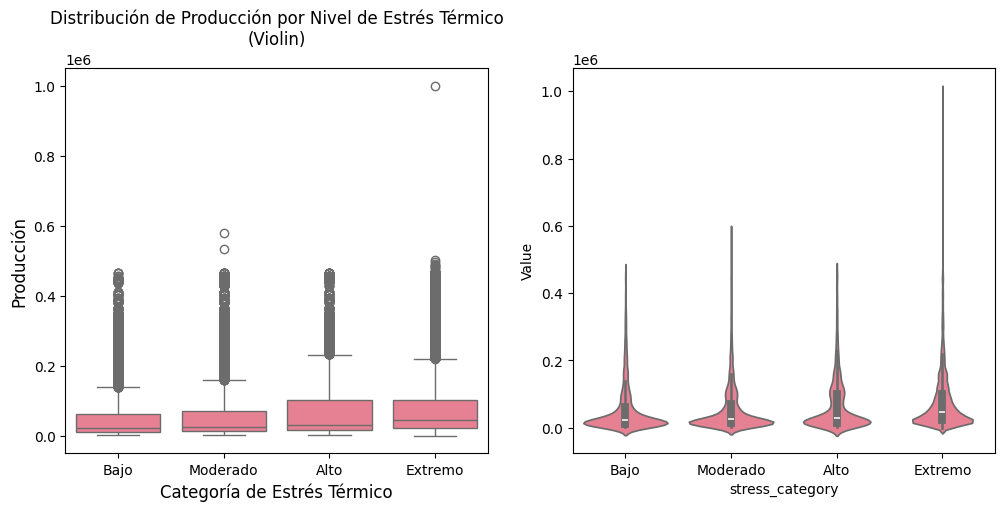

In [135]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
sns.boxplot(data = yield_temp, x = "stress_category", y = "Value", ax = axes[0])
axes[0].set_title('Distribución de Producción por Nivel de Estrés Térmico\n(Box Plot)', 
              fontsize=14, fontweight='bold')
axes[0].set_xlabel('Categoría de Estrés Térmico', fontsize=12)
axes[0].set_ylabel('Producción', fontsize=12)

sns.violinplot(data = yield_temp, x = "stress_category", y = "Value", ax = axes[1])
axes[0].set_title('Distribución de Producción por Nivel de Estrés Térmico\n(Violin)')


## Analisis Yield Rainfall

Haremos ahora un analisis del dataframe de rainfall.

In [136]:
yield_rain = yield_df.merge(rainfall, on = ["Area", "Year"], suffixes= ["", "_rain"], how = "left")

In [137]:
yield_rain = yield_rain[yield_rain.Year > 1984] # Datos desde 1985 de rainfall
yield_rain = yield_rain[yield_rain.Year < 2014]

In [138]:
yield_rain.describe(include= "all")

Area          Year   Item          Value  \
count                              30905  30905.000000  30905   30905.000000   
unique                               212           NaN     10            NaN   
top     Democratic Republic of the Congo           NaN  Maize            NaN   
freq                                 290           NaN   4662            NaN   
mean                                 NaN   1999.344637    NaN   67108.452483   
std                                  NaN      8.286519    NaN   72558.524129   
min                                  NaN   1985.000000    NaN       0.000000   
25%                                  NaN   1992.000000    NaN   17678.000000   
50%                                  NaN   1999.000000    NaN   39403.000000   
75%                                  NaN   2007.000000    NaN   92599.000000   
max                                  NaN   2013.000000    NaN  554855.000000   

        average_rain_fall_mm_per_year  \
count                    22716.000000   
unique                            NaN   
top                               NaN   
freq                              NaN   
mean                      1256.466323   
std                        805.385796   
min                         51.000000   
25%                        630.000000   
50%                       1150.000000   
75%                       1761.000000   
max                       3240.000000   

        average_rain_fall_mm_per_year_fillna_mean  
count                                23365.000000  
unique                                        NaN  
top                                           NaN  
freq                                          NaN  
mean                                  1249.620330  
std                                    795.153342  
min                                     51.000000  
25%                                    630.000000  
50%                                   1130.000000  
75%                                   1761.000000  
max                                   3240.000000

Estoy viendo que 2003 y 1988 no tienen datos de lluvia. Dado que son aislados, podemos reemplazar con el promedio.

In [139]:
yield_rain["average_rain_fall_mm_per_year_fillna_median_area"] = yield_rain.groupby('Area')['average_rain_fall_mm_per_year'].transform(lambda x: x.fillna(x.median()))

c:\Users\legutierrezf\OneDrive - Indra\Documentos\Crop Yield Prediction\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\legutierrezf\OneDrive - Indra\Documentos\Crop Yield Prediction\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\legutierrezf\OneDrive - Indra\Documentos\Crop Yield Prediction\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\legutierrezf\OneDrive - Indra\Documentos\Crop Yield Prediction\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\legutierrezf\OneDrive - Indra\Documentos\Crop Yield Prediction\.venv\Lib\site-packa

In [140]:
yield_rain[yield_rain.average_rain_fall_mm_per_year_fillna_median_area.isna()].Year.value_counts()


Year
1997    235
1995    234
1996    234
1999    234
1998    234
2001    231
2005    231
2004    231
2002    231
2000    231
2003    230
1994    230
1992    228
2011    227
2007    226
2009    226
2008    226
2010    226
1993    226
2006    225
1988    220
2012    220
2013    220
1989    219
1990    219
1986    217
1987    217
1985    214
1991    212
Name: count, dtype: int64

In [141]:
lista_no_found_in_rain= list(yield_rain[yield_rain['average_rain_fall_mm_per_year_fillna_median_area'].isna()].Area.unique())
list_rain = list(rainfall.Area.unique())

def normalizar_nombre_pais(nombre):
    nombre = nombre.strip().lower()
    nombre = re.sub(r'[^\w\s]', ' ', nombre)
    nombre = ' '.join(nombre.split())

    reemplazos = {
        'united states of america': 'united states',
        'united states': 'usa',
        'united kingdom': 'uk',
        'republic of korea': 'south korea',
        'korea, republic of': 'south korea',
        'china mainland': 'china',
        "venezuela bolivarian republic of": "venezuela",
        "bolivia plurinational state of": "bolivia",
        "democratic people's republic of korea": "korea",
        "united republic of tanzania": "tanzania",
        ' republic': '',
        ' federation': '',
        ' democratic': '',
        ' peoples': '',
        ' socialist': '',
        'republic of ': '',
        'democratic republic of ': '',
        ' rep ': ' republic ',
        ' dem ': ' democratic ',
        ' fed ': ' federation '}
    
    for buscar, reemplazar in reemplazos.items():
            nombre = nombre.replace(buscar, reemplazar)
    nombre = ' '.join(nombre.split())
    return nombre
lista1_norm = {pais: normalizar_nombre_pais(pais) for pais in list_rain}
lista2_norm = {pais: normalizar_nombre_pais(pais) for pais in lista_no_found_in_rain}

asignaciones = {}
no_encontrados  = []

for pais_orig, pais_norm in lista1_norm.items():
    mejor_match = process.extractOne(pais_norm, list(lista2_norm.values()), scorer=fuzz.ratio)

    if mejor_match and mejor_match[1] >= 80:
            # Encontrar el país original correspondiente
            pais_destino_orig = [k for k, v in lista2_norm.items() if v == mejor_match[0]][0]
            asignaciones[pais_orig] = pais_destino_orig
    else:
        no_encontrados.append(pais_orig)
asignaciones

{'American Samoa': 'American Samoa',
 'Bermuda': 'Bermuda',
 'Bolivia': 'Bolivia (Plurinational State of)',
 'Cayman Islands': 'Cayman Islands',
 'China': 'China, mainland',
 "Cote d'Ivoire": "Côte d'Ivoire",
 'Czech Republic': 'Czechia',
 'Ethiopia': 'Ethiopia PDR',
 'Faroe Islands': 'Faroe Islands',
 'French Polynesia': 'French Polynesia',
 'Guam': 'Guam',
 'North Korea': 'Republic of Korea',
 'South Korea ': 'Republic of Korea',
 'Moldova': 'Republic of Moldova',
 'New Caledonia': 'New Caledonia',
 'Russia': 'Russian Federation',
 'Slovak Republic': 'Slovakia',
 'St. Kitts and Nevis': 'Saint Kitts and Nevis',
 'St. Lucia': 'Saint Lucia',
 'St. Vincent and the Grenadines': 'Saint Vincent and the Grenadines',
 'Tanzania': 'United Republic of Tanzania',
 'Tonga': 'Tonga',
 'United States': 'United States of America',
 'Venezuela, RB': 'Venezuela (Bolivarian Republic of)',
 'Vietnam': 'Viet Nam'}

In [142]:
# Removemos algunos paises que no son correctos. Sacamos China porque en temp esta China y CHina mainland a la vez
to_drop = ["Iceland", "Gambia", "Czechia", "Dominican Republic", "China"] 
for pais in to_drop:
    asignaciones.pop(pais, None)

In [143]:
rainfall["Area_fuzzy"] = rainfall.Area.apply(lambda x: asignaciones.get(x, x))
rainfall.rename(columns={'Area': 'Area_raw', "Area_fuzzy": "Area"}, inplace=True)

In [144]:
yield_rain = yield_df.merge(rainfall, on=['Area', 'Year'], how='left', suffixes=('', '_temp'))
yield_rain = yield_rain[yield_rain.Year < 2014]
yield_rain = yield_rain[yield_rain.Year > 1984]  # Aseguramos que los datos sean consistentes
yield_rain["average_rain_fall_mm_per_year_fillna_median_area"] = yield_rain.groupby('Area')['average_rain_fall_mm_per_year'].transform(lambda x: x.fillna(x.median()))

c:\Users\legutierrezf\OneDrive - Indra\Documentos\Crop Yield Prediction\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\legutierrezf\OneDrive - Indra\Documentos\Crop Yield Prediction\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\legutierrezf\OneDrive - Indra\Documentos\Crop Yield Prediction\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\legutierrezf\OneDrive - Indra\Documentos\Crop Yield Prediction\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\legutierrezf\OneDrive - Indra\Documentos\Crop Yield Prediction\.venv\Lib\site-packa

In [145]:
yield_rain.describe(include="all")

Area          Year   Item          Value  Area_raw  \
count               31094  31094.000000  31094   31094.000000     25718   
unique                212           NaN     10            NaN       184   
top     Republic of Korea           NaN  Maize            NaN  Cameroon   
freq                  392           NaN   4689            NaN       270   
mean                  NaN   1999.344118    NaN   67227.411012       NaN   
std                   NaN      8.287027    NaN   72664.252249       NaN   
min                   NaN   1985.000000    NaN       0.000000       NaN   
25%                   NaN   1992.000000    NaN   17670.000000       NaN   
50%                   NaN   1999.000000    NaN   39472.500000       NaN   
75%                   NaN   2007.000000    NaN   92727.000000       NaN   
max                   NaN   2013.000000    NaN  554855.000000       NaN   

        average_rain_fall_mm_per_year  \
count                    25069.000000   
unique                            NaN   
top                               NaN   
freq                              NaN   
mean                      1258.497666   
std                        782.255550   
min                         51.000000   
25%                        636.000000   
50%                       1150.000000   
75%                       1761.000000   
max                       3240.000000   

        average_rain_fall_mm_per_year_fillna_mean  \
count                                25718.000000   
unique                                        NaN   
top                                           NaN   
freq                                          NaN   
mean                                  1252.226767   
std                                    773.304687   
min                                     51.000000   
25%                                    637.000000   
50%                                   1146.000000   
75%                                   1761.000000   
max                                   3240.000000   

        average_rain_fall_mm_per_year_fillna_median_area  
count                                       26863.000000  
unique                                               NaN  
top                                                  NaN  
freq                                                 NaN  
mean                                         1259.706325  
std                                           782.183776  
min                                            51.000000  
25%                                           636.000000  
50%                                          1150.000000  
75%                                          1761.000000  
max                                          3240.000000

In [146]:
yield_rain[yield_rain.average_rain_fall_mm_per_year_fillna_median_area.isna()].Area.value_counts()


Area
Democratic Republic of the Congo             290
China, mainland                              232
China, Taiwan Province of                    232
New Caledonia                                217
Sudan (former)                               216
Democratic People's Republic of Korea        203
Congo                                        203
Lao People's Democratic Republic             174
Ethiopia                                     168
Syrian Arab Republic                         154
Iran (Islamic Republic of)                   145
Réunion                                      144
Kyrgyzstan                                   132
Micronesia (Federated States of)             118
Tonga                                        116
Guadeloupe                                   116
The former Yugoslav Republic of Macedonia    111
French Guiana                                111
Martinique                                   108
Cayman Islands                                87
Niue           

El resto sera completado con la mediana. Pero luego, ahora analicemos comportamiento entre rainfall y produccion

In [147]:
yield_rain.columns

Index(['Area', 'Year', 'Item', 'Value', 'Area_raw',
       'average_rain_fall_mm_per_year',
       'average_rain_fall_mm_per_year_fillna_mean',
       'average_rain_fall_mm_per_year_fillna_median_area'],
      dtype='object')

In [148]:
yield_rain = yield_rain[["Year", "Area", "Item", "Value", "average_rain_fall_mm_per_year_fillna_median_area"]]
yield_rain

Year         Area   Item  Value  \
24     1985  Afghanistan  Maize  16652   
25     1986  Afghanistan  Maize  16875   
26     1987  Afghanistan  Maize  17020   
27     1988  Afghanistan  Maize  17034   
28     1989  Afghanistan  Maize  16963   
...     ...          ...    ...    ...   
56919  2009     Zimbabwe  Wheat  30000   
56920  2010     Zimbabwe  Wheat  27681   
56921  2011     Zimbabwe  Wheat  26274   
56922  2012     Zimbabwe  Wheat  24420   
56923  2013     Zimbabwe  Wheat  22888   

       average_rain_fall_mm_per_year_fillna_median_area  
24                                                327.0  
25                                                327.0  
26                                                327.0  
27                                                327.0  
28                                                327.0  
...                                                 ...  
56919                                             657.0  
56920                                             657.0  
56921                                             657.0  
56922                                             657.0  
56923                                             657.0  

[31094 rows x 5 columns]

<Axes: xlabel='average_rain_fall_mm_per_year_fillna_median_area', ylabel='Value'>

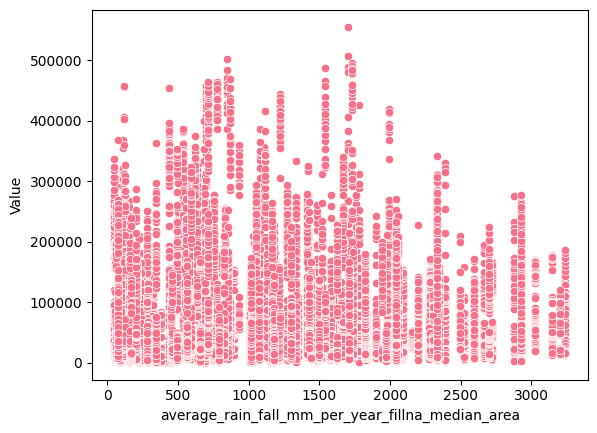

In [149]:
yield_rain_clean = yield_rain.dropna(subset=["average_rain_fall_mm_per_year_fillna_median_area"])
sns.scatterplot(data = yield_rain_clean, x = "average_rain_fall_mm_per_year_fillna_median_area", y = "Value")

No parece haber una relacion directa entre la caida de lluvia y la produccion. Ademas la lluvia es constante en cada pais, no aporta informacion a lo largo del tiempo.

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

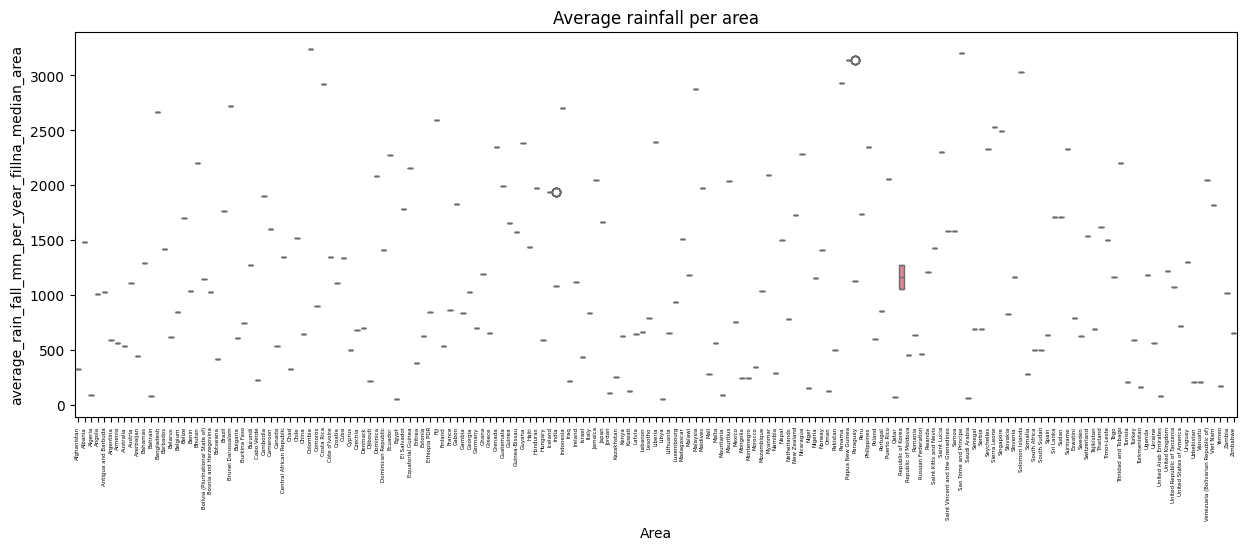

In [150]:
plt.figure(figsize=(15, 5))
sns.boxplot(data = yield_rain_clean, x = "Area", y = "average_rain_fall_mm_per_year_fillna_median_area")
plt.title("Average rainfall per area")
plt.xticks(rotation = 90, size = 4)

In [151]:
yield_rain_by_area = yield_rain_clean.groupby("Area")[["average_rain_fall_mm_per_year_fillna_median_area", "Value"]].mean().reset_index()

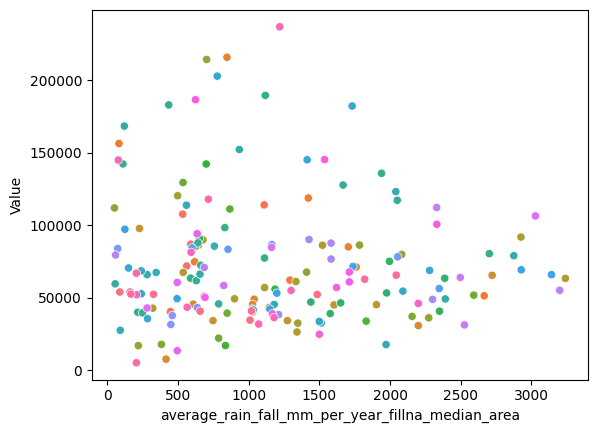

In [152]:
sns.scatterplot(data = yield_rain_by_area , x = "average_rain_fall_mm_per_year_fillna_median_area", y = "Value", hue= "Area")
plt.legend().remove()

In [153]:
r, p = pearsonr(yield_rain_by_area["average_rain_fall_mm_per_year_fillna_median_area"], yield_rain_by_area["Value"])
print(f"Pearson Corr: {r}, P value: {p}")

Pearson Corr: -0.06262154625153107, P value: 0.4103505583061807


Obtenemos una correlacion negativa, pero el p_value no es significativo. Del grafico pareciera que hubiesen dos tendencias.

In [154]:
yield_rain_by_area_and_temp = yield_rain_by_area.merge(temp.groupby("Area").Value.mean().reset_index(), on= "Area", how = "left", suffixes=["", "_temp"])

<Axes: xlabel='average_rain_fall_mm_per_year_fillna_median_area', ylabel='Value'>

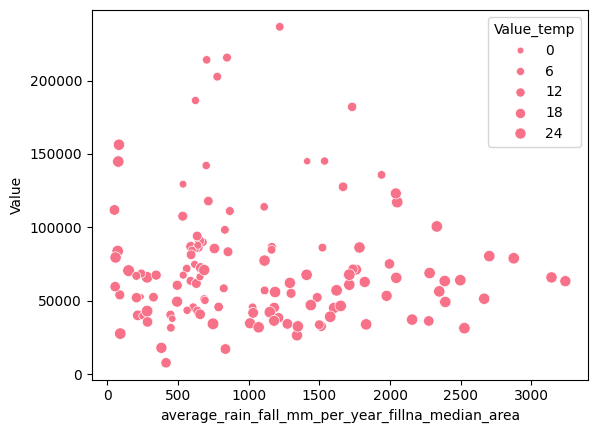

In [155]:
sns.scatterplot(data=yield_rain_by_area_and_temp, x =  "average_rain_fall_mm_per_year_fillna_median_area", y = "Value", size = "Value_temp")

Pareciera que paises frios donde llueve poco tienen mayor produccion. Paises donde llueve mucho requieren necesariamente climas calidos

In [156]:
yield_rain_by_area_and_temp

Area  \
0                           Afghanistan   
1                               Albania   
2                               Algeria   
3                                Angola   
4                   Antigua and Barbuda   
..                                  ...   
170  Venezuela (Bolivarian Republic of)   
171                            Viet Nam   
172                               Yemen   
173                              Zambia   
174                            Zimbabwe   

     average_rain_fall_mm_per_year_fillna_median_area         Value  \
0                                               327.0  52408.732759   
1                                              1485.0  52243.518797   
2                                                89.0  53967.215278   
3                                              1010.0  34617.163366   
4                                              1030.0  40315.431034   
..                                                ...           ...   
170                                            2044.0  65589.297578   
171                                            1821.0  62793.568966   
172                                             167.0  52519.020979   
173                                            1020.0  40961.086207   
174                                             657.0  40767.538793   

     Value_temp  
0     14.360950  
1     15.498202  
2     16.433218  
3     23.693649  
4           NaN  
..          ...  
170   25.765400  
171   24.370776  
172         NaN  
173         NaN  
174   20.202183  

[175 rows x 4 columns]

<Axes: xlabel='average_rain_fall_mm_per_year_fillna_median_area', ylabel='Value'>

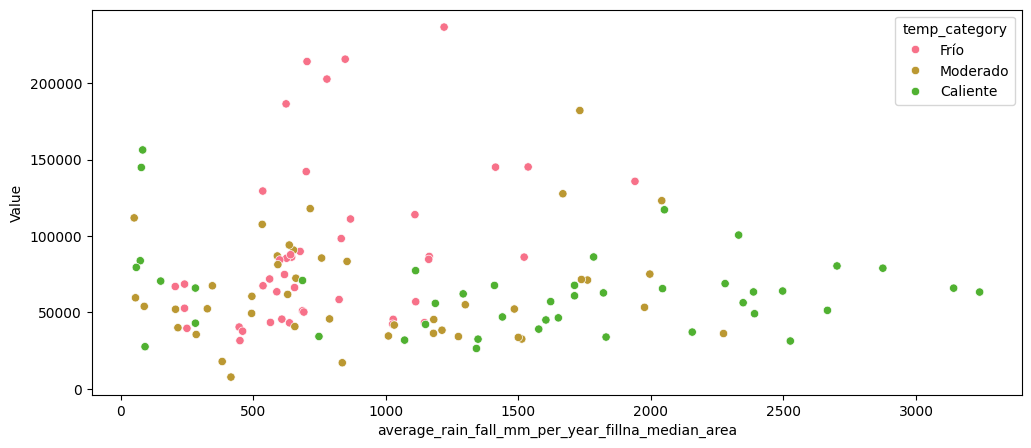

In [158]:
plt.figure(figsize = (12, 5))
cut_points = np.linspace(0, 1,4)
quantile_values = yield_rain_by_area_and_temp["Value_temp"].dropna().quantile(cut_points)
labels = ['Frío'
          , 'Moderado'
           , 'Caliente']
          #, "Muy Caliente"]
yield_rain_by_area_and_temp["temp_category"] = pd.cut(
    yield_rain_by_area_and_temp["Value_temp"], 
    bins=quantile_values, 
    labels=labels, 
    include_lowest=True
)
sns.scatterplot(
    data=yield_rain_by_area_and_temp, 
    x="average_rain_fall_mm_per_year_fillna_median_area", 
    y="Value", 
    hue="temp_category"
)

In [159]:
correlations = []

for category in yield_rain_by_area_and_temp.temp_category.unique():
    data=yield_rain_by_area_and_temp[yield_rain_by_area_and_temp.temp_category == category].dropna()
    if len(data) > 2:
        r, p = pearsonr(data.average_rain_fall_mm_per_year_fillna_median_area, data.Value)
        correlations.append(
            {
                "category": category,
                "corr": r,
                "p_value": p
            }
        )
correlations_df = pd.DataFrame(correlations)
correlations_df


category      corr   p_value
0  Moderado  0.151500  0.332152
1      Frío  0.347226  0.022530
2  Caliente -0.163040  0.296194

In [362]:
Existe una clara interaccion entre las temperaturas frias, la lluvia y la produccion. Essto puede ser util para un modelo

Area  \
0                           Afghanistan   
1                               Albania   
2                               Algeria   
3                                Angola   
4                   Antigua and Barbuda   
..                                  ...   
170  Venezuela (Bolivarian Republic of)   
171                            Viet Nam   
172                               Yemen   
173                              Zambia   
174                            Zimbabwe   

     average_rain_fall_mm_per_year_fillna_median_area         Value  \
0                                               327.0  52408.732759   
1                                              1485.0  52243.518797   
2                                                89.0  53967.215278   
3                                              1010.0  34617.163366   
4                                              1030.0  40315.431034   
..                                                ...           ...   
170                                            2044.0  65589.297578   
171                                            1821.0  62793.568966   
172                                             167.0  52519.020979   
173                                            1020.0  40961.086207   
174                                             657.0  40767.538793   

     Value_temp  temperaturas_altas  
0     14.360950                True  
1     15.498202                True  
2     16.433218                True  
3     23.693649                True  
4           NaN               False  
..          ...                 ...  
170         NaN               False  
171   24.370776                True  
172         NaN               False  
173         NaN               False  
174   20.202183                True  

[175 rows x 5 columns]

# Modelo

Hemos explorado todas los datos disponibles. Ahora haremos una union de todo lo que tenemos, crearemos  nuevos features basandonos en lo estudiado hasta este punto e implementaremos un modelo.

In [156]:
path = 'data/archive'
pesticides = pd.read_csv(f'{path}/pesticides.csv')
rainfall = pd.read_csv(f'{path}/rainfall.csv', na_values=['..'])
temp = pd.read_csv(f'{path}/temp.csv')
yield_df = pd.read_csv(f'{path}/yield.csv')
#yield_df2 = pd.read_csv(f'{path}/yield_df.csv')  


In [157]:

pesticides = pesticides[['Area', 'Year', 'Value']]
rainfall.rename(columns={' Area': 'Area',"average_rain_fall_mm_per_year": "Value" }, inplace=True)
#rainfall['Value'] = rainfall.groupby('Year')['Value'].transform(lambda x: x.fillna(x.median()))
temp = temp.rename(columns={"country": "Area", "year": "Year", 'avg_temp': 'Value'})
yield_df = yield_df[["Area", "Year", "Item", "Value"]]


In [158]:

temp        = temp.groupby(['Area', 'Year'])['Value'].mean().reset_index()
rainfall    = rainfall.groupby(['Area', 'Year'])['Value'].mean().reset_index()
pesticides  = pesticides.groupby(['Area', 'Year'])['Value'].mean().reset_index()
yield_df     = yield_df.groupby(['Area', 'Item', 'Year'])['Value'].mean().reset_index()


Number of rows: 29367


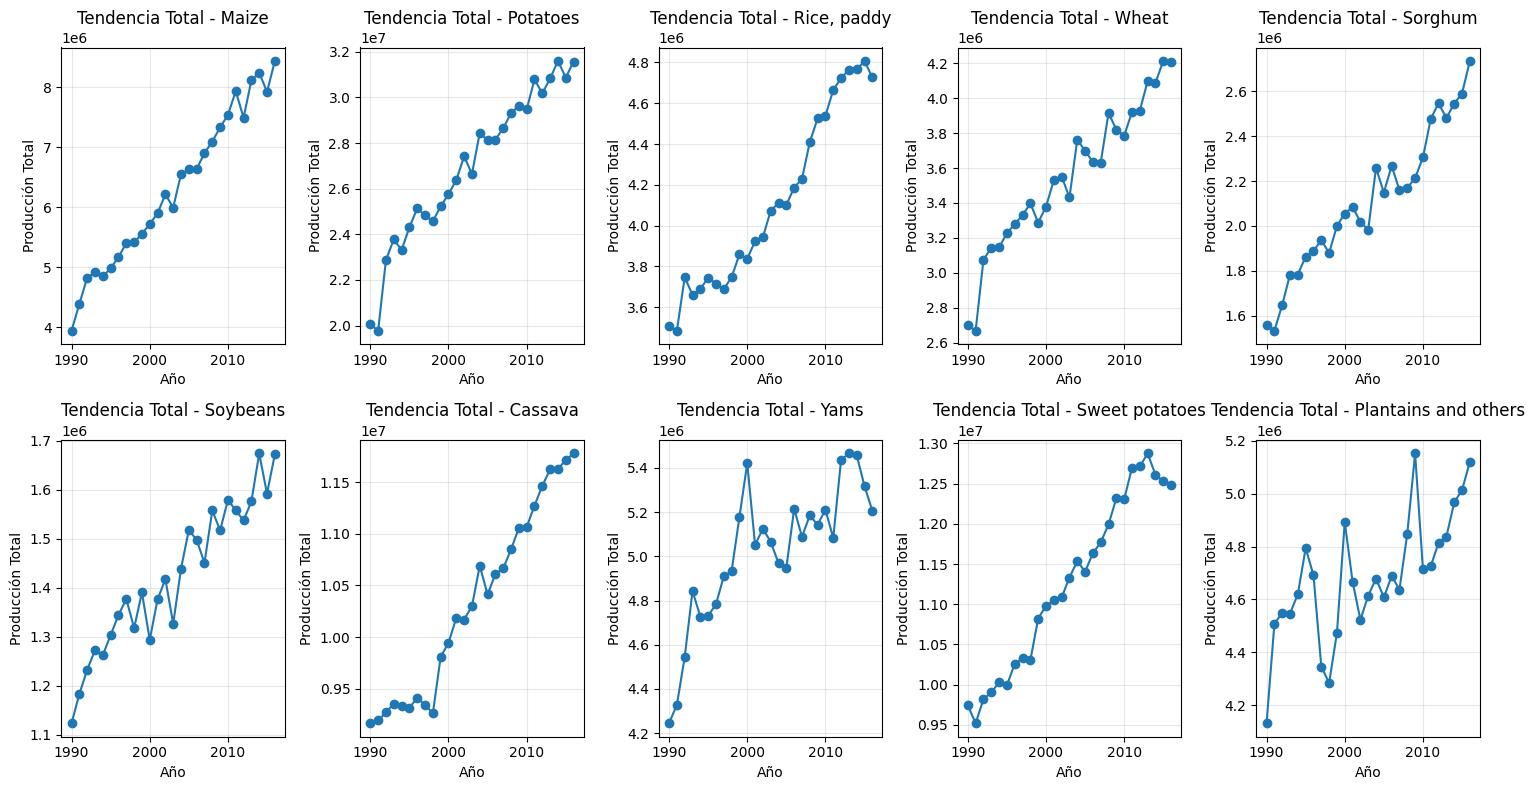

In [159]:

def plot_global_production(df, year_min = None, year_max = None):
    plt.figure(figsize=(15, 8))
    if not year_min is None:
        df = df[df.Year >= year_min]
    if not year_max is None:
        df = df[df.Year <= year_max]

    print(f'Number of rows: {df.shape[0]}')
    for i, cultivo in enumerate(df['Item'].unique()):
        plt.subplot(2, 5, i+1)
        data_cultivo = df[df['Item'] == cultivo]
        tendencia_anual = data_cultivo.groupby('Year')['Value'].sum()
        
        plt.plot(tendencia_anual.index, tendencia_anual.values, marker='o')
        plt.title(f'Tendencia Total - {cultivo}')
        plt.xlabel('Año')
        plt.ylabel('Producción Total')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

plot_global_production(yield_df, 1990, 2016)

----Processing Rainfall df---
Iniciando process_field con suffix: _rainfall
Filas df1: 56717, Filas df2: 6727
df2 después de limpiar duplicados: 6727
Filas después del merge: 56717
Filas después de drop_duplicates: 56717
filtering by year in: 1985 <= year <= 2016
Filas después del filtro de años: 34232
Paises sin datos en Value_rainfall: 51
Paises disponibles en df2: 217
Matches encontrados: 24
Países encontrados: 24
Países no encontrados: 27
Renombrando 23 países en df2:
  American Samoa -> American Samoa
  Bermuda -> Bermuda
  Bolivia -> Bolivia (Plurinational State of)
  Cayman Islands -> Cayman Islands
  Czech Republic -> Czechia
  Cote d'Ivoire -> Côte d'Ivoire
  Ethiopia -> Ethiopia PDR
  Faroe Islands -> Faroe Islands
  French Polynesia -> French Polynesia
  Guam -> Guam
  New Caledonia -> New Caledonia
  South Korea  -> Republic of Korea
  Moldova -> Republic of Moldova
  Russia -> Russian Federation
  St. Kitts and Nevis -> Saint Kitts and Nevis
  St. Lucia -> Saint Lucia
  St

C:\Users\legutierrezf\AppData\Local\Temp\ipykernel_30652\2251558333.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_areas_renamed[f'Value{suffix}'] = df_areas_renamed.groupby("Year")[f'Value{suffix}'].transform(
C:\Users\legutierrezf\AppData\Local\Temp\ipykernel_30652\2251558333.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_areas_renamed[f'Value{suffix}'] = df_areas_renamed.groupby("Year")[f'Value{suffix}'].transform(


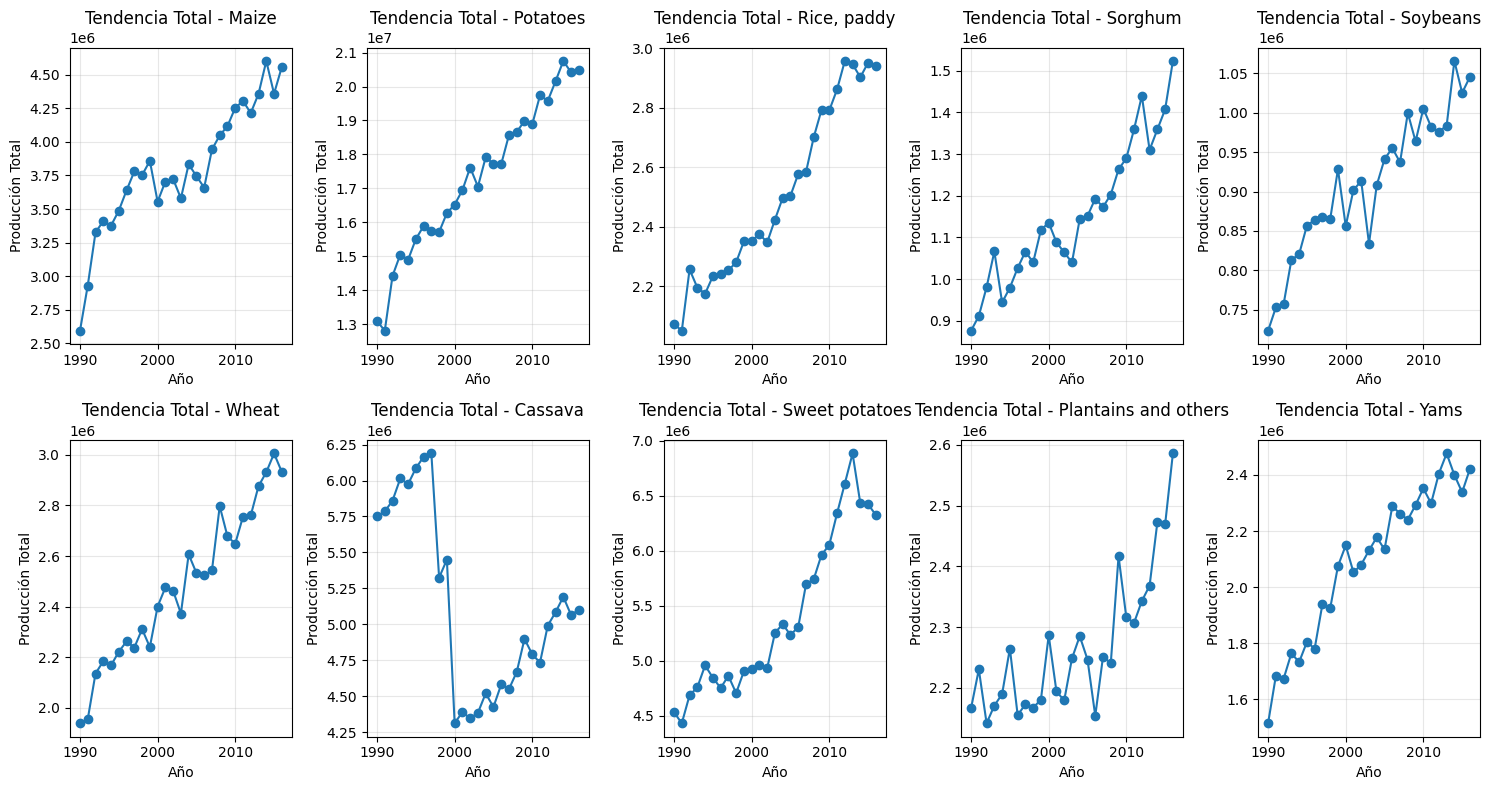

In [160]:



def find_best_fuzzy_matches(df1, df2, field_na):
    lista_no_found = list(df1[df1[field_na].isna()].Area.unique())
    list_area_df2 = list(df2.Area.unique())

    print(f"Paises sin datos en {field_na}: {len(lista_no_found)}")
    print(f"Paises disponibles en df2: {len(list_area_df2)}")

    def normalizar_nombre_pais(nombre):
        nombre = str(nombre).strip().lower()
        nombre = re.sub(r'[^\w\s]', ' ', nombre)
        nombre = ' '.join(nombre.split())

        reemplazos = {
            'united states of america': 'united states',
            'united states': 'usa',
            'united kingdom': 'uk',
            'republic of korea': 'south korea',
            'korea, republic of': 'south korea',
            'china mainland': 'china',
            "venezuela bolivarian republic of": "venezuela",
            "bolivia plurinational state of": "bolivia",
            "democratic people's republic of korea": "north korea",
            "united republic of tanzania": "tanzania",
            ' republic': '',
            ' federation': '',
            ' democratic': '',
            ' peoples': '',
            ' socialist': '',
            'republic of ': '',
            'democratic republic of ': '',
            ' rep ': ' republic ',
            ' dem ': ' democratic ',
            ' fed ': ' federation '
        }
        
        for buscar, reemplazar in reemplazos.items():
            nombre = nombre.replace(buscar, reemplazar)
        nombre = ' '.join(nombre.split())
        return nombre
    
    lista_df1_norm = {pais: normalizar_nombre_pais(pais) for pais in lista_no_found}
    lista_df2_norm = {pais: normalizar_nombre_pais(pais) for pais in list_area_df2}

    asignaciones = {}
    no_encontrados = []

    for pais_df1_orig, pais_df1_norm in lista_df1_norm.items():
        mejor_match = process.extractOne(pais_df1_norm, list(lista_df2_norm.values()), scorer=fuzz.ratio)

        if mejor_match and mejor_match[1] >= 80:
                # Encontrar el país original correspondiente
                pais_df2_match = [k for k, v in lista_df2_norm.items() if v == mejor_match[0]][0]
                asignaciones[pais_df1_orig] = pais_df2_match
        else:
            no_encontrados.append(pais_df1_orig)
    print(f"Matches encontrados: {len(asignaciones)}")

    return asignaciones, no_encontrados

def rename_areas_using_fuzzy_matching(df2, asignaciones):
     # Removemos algunos paises que no son correctos. Sacamos China porque en temp esta China y CHina mainland a la vez
    asignaciones_invertidas = {v: k for k, v in asignaciones.items()}
    to_drop = ["Nigeria","Iceland", "Gambia", "Czechia", "Dominican Republic", "China", "Dominica"] 
    for pais in to_drop:
        asignaciones_invertidas.pop(pais, None)
    print(f"Renombrando {len(asignaciones_invertidas)} países en df2:")
    for original, nuevo in asignaciones_invertidas.items():
        print(f"  {original} -> {nuevo}")

    df_renamed = df2.copy()
    df_renamed["Area"] = df_renamed.Area.apply(lambda x: asignaciones_invertidas.get(x, x))
    return df_renamed

def join_dfs(df1, df2, suffix):
     return df1.merge(df2, on=['Area', 'Year'], how='left', suffixes=('', suffix))

def filter_by_years(df, min_year, max_year):
    df_filtered = df[df.Year >= min_year]
    print(f"filtering by year in: {min_year} <= year <= {max_year}")
    df_filtered = df_filtered[df_filtered.Year <= max_year] 
    return df_filtered

def fill_na_with_last_n_means(df, col,  n = 5):
    result = df.copy()
    rolling_mean = df[col].rolling(
         window = n,
         min_periods = 1
    ).mean()

    result[col] = df[col].fillna(rolling_mean)
    return result
              
def process_field(df1, df2, suffix):
    print(f"Iniciando process_field con suffix: {suffix}")
    print(f"Filas df1: {len(df1)}, Filas df2: {len(df2)}")
    
    # Asegurar que df2 no tenga duplicados Area-Year
    df2_clean = df2.groupby(['Area', 'Year'])['Value'].mean().reset_index()
    print(f"df2 después de limpiar duplicados: {len(df2_clean)}")
    
    df = join_dfs(df1, df2_clean, suffix=suffix)
    print(f"Filas después del merge: {len(df)}")
    
    df = fill_na_with_last_n_means(df, col=f'Value{suffix}', n=10)
    df = df.drop_duplicates()
    print(f"Filas después de drop_duplicates: {len(df)}")
    
    min_year = np.max([df1.Year.min(), df2.Year.min()])
    max_year = df1.Year.max()
    
    df = filter_by_years(df, min_year=min_year, max_year=max_year)
    print(f"Filas después del filtro de años: {len(df)}")
    
    df = fill_na_with_last_n_means(df, col=f'Value{suffix}', n=5)
    
    df_no_na = df[~df[f'Value{suffix}'].isna()]
    asignaciones, no_encontrados = find_best_fuzzy_matches(df, df2_clean, f"Value{suffix}")
    
    print(f'Países encontrados: {len(asignaciones)}')
    print(f'Países no encontrados: {len(no_encontrados)}')
    
    if asignaciones:
        df_na_areas_renamed = rename_areas_using_fuzzy_matching(
            df2_clean[df2_clean.Area.isin(asignaciones.keys())], 
            asignaciones
        )
        
        df_na_areas_renamed_rejoined = df.drop(columns=[f'Value{suffix}'])[
            df.Area.isin(asignaciones.values())
        ].merge(df_na_areas_renamed, on=["Area", "Year"], suffixes=["", suffix])
        
        if len(df_na_areas_renamed_rejoined) > 0:
            df_areas_renamed = pd.concat([df_no_na, df_na_areas_renamed_rejoined])
            df_areas_renamed = df_areas_renamed.drop_duplicates()  # Asegurar no duplicados
        else:
            df_areas_renamed = df_no_na
    else:
        df_areas_renamed = df_no_na
        
    df_areas_renamed[f'Value{suffix}'] = df_areas_renamed.groupby("Year")[f'Value{suffix}'].transform(
        lambda x: x.fillna(x.median())
    )
    print(f'Filas finales: {len(df_areas_renamed)}')
    print('Years considered:[', df_areas_renamed.Year.min(), ',', df_areas_renamed.Year.max(), ']')
    return df_areas_renamed

def process_all_df(df: pd.DataFrame, dfs_dict: dict) -> pd.DataFrame:

    print('----Processing Rainfall df---')
    df_rainfall = dfs_dict['rainfall']
    df_final = process_field(df, df_rainfall, '_rainfall')

    print('----Processing Pesticides df---')
    df_pesticides = dfs_dict['pesticides']
    df_final = process_field(df_final, df_pesticides, '_pesticides')

    print('----Processing Temperature df---')
    df_temp = dfs_dict['temperature']
    df_final = process_field(df_final, df_temp, '_temperature')

    return df_final

dfs_dict = {
    'rainfall': rainfall,
    'pesticides': pesticides,
    'temperature': temp      
}
df = process_all_df(yield_df, dfs_dict)
plot_global_production(df)

Tenemos datos completos, hay algunos paises donde se tuvo que hacer fuzzy matching, otros donde no se encontro y se completo con la mediana. Ademas de que para los periodos del 2013 hasta el 2016 se hizo un moving average para temp y pesticides por no encontrarse la data.

## Feature Generation
Voy a realizar los features pensando en hacer un train test split en 2008. Esta fecha es totalmente arbitraria. Pero me parece que teiene sentido hacer forward predict y necesito hacer un split en algun punto

In [185]:
df.shape

(15954, 7)

In [162]:
def generate_temporal_features(df):
    df = df.copy()
    reference_year = df.Year.min()
    df['years_since_start'] = df.Year - reference_year


    return df

def generate_tasa_crecimiento(df):
    df = df.copy()
    df.sort_values(['Area', 'Item', 'Year'], inplace = True)
    ultimos_n_years = 5
    
    grouped =  df.groupby(['Area', 'Item'])
    for name, group in grouped:
        idx = group.index
        df.loc[idx, f'tasa_crecimiento_promedio{ultimos_n_years}anios'] = group['Value']\
                                                                        .pct_change()\
                                                                        .rolling(
                                                                            window = ultimos_n_years,
                                                                            min_periods = 1
                                                                        ).mean()

        df.loc[idx, f'volatilidad_promedio{ultimos_n_years}anios'] = group['Value']\
                                                                        .rolling(
                                                                            window = ultimos_n_years,
                                                                            min_periods = 1
                                                                        ).std()

    df['Value_lag1'] = grouped['Value'].shift(1)
    df['Value_lag2'] = grouped['Value'].shift(2)

    grouped =  df.groupby(['Item'])
    df['tasa_crecimiento_global'] =  grouped['Value'].pct_change()

    return df

def create_cross_crop_features(df, n_years=3):
    """
    Crea features basados en correlaciones entre cultivos.
    Funcion Hecha con IA, no logre implementarla yo de manera eficiente
    """
    df_cross = df.copy()
    df_cross = df_cross.sort_values(['Area', 'Item', 'Year'])
    
    # Crear matriz de cultivos por año y área
    pivot_data = df_cross.pivot_table(
        values='Value', 
        index=['Area', 'Year'], 
        columns='Item', 
        fill_value=np.nan
    )
    
    # Para cada área, calcular correlaciones móviles entre cultivos
    for area in df_cross['Area'].unique():
        area_data = pivot_data.loc[area]
        crops = area_data.columns.tolist()
        
        for i, crop1 in enumerate(crops):
            for j, crop2 in enumerate(crops[i+1:], i+1):
                # Correlación móvil entre cultivos
                corr_col = f'corr_{crop1}_{crop2}_{n_years}y'
                rolling_corr = area_data[crop1].rolling(
                    window=n_years, min_periods=1
                ).corr(area_data[crop2])
                
                # Mapear de vuelta al DataFrame original
                for year in area_data.index:
                    if year in rolling_corr.index and not pd.isna(rolling_corr[year]):
                        mask1 = (df_cross['Area'] == area) & (df_cross['Year'] == year) & (df_cross['Item'] == crop1)
                        mask2 = (df_cross['Area'] == area) & (df_cross['Year'] == year) & (df_cross['Item'] == crop2)
                        
                        df_cross.loc[mask1, corr_col] = rolling_corr[year]
                        df_cross.loc[mask2, corr_col] = rolling_corr[year]
    
    return df_cross

#Genero features locales porque del analisis observo que a nivel global el valor de pesticidas no afecta la produccion
def generate_pesticide_local_features(df, n_years = 3):
    df = df.copy()
    df = df.sort_values(['Area', 'Item', 'Year'])

    for (area, item), group in df.groupby(['Area', "Item"]):
        idx = group.index

        if len(group) >= n_years:
            local_corr = group.Value.rolling(
                window = n_years,
                min_periods = 1).corr(group.Value_pesticides)
            df.loc[idx, f'local_pest_prod_corr{n_years}'] = local_corr

        # % cambio prod / % cambio pesticides
        pest_pct_change = group['Value_pesticides'].pct_change()
        prod_pct_change = group['Value'].pct_change()

        for i in range(n_years, len(group)):
            pest_change = pest_pct_change.iloc[i - n_years +1: i + 1]
            prod_change = prod_pct_change.iloc[i - n_years +1: i + 1]
            data = pd.DataFrame(
                {
                    'pest': pest_change,
                    'prod': prod_change
                }
            )

            if len(data) > 1 and data.pest.std() > 0:
                tasa = data['prod'].std() / data['pest'].std()
                df.loc[idx[i], f'pest_prod_elasticity_{n_years}'] = tasa
    return df


def generate_pesticides_quartiles(df):
    df = df.copy()
    global_quartiles = df.Value_pesticides.quantile([0.25, 0.5, 0.75])

    df['pesticide_quartile_global'] = pd.cut(
            df['Value_pesticides'],
            bins=[-np.inf, global_quartiles[0.25], global_quartiles[0.5], 
                  global_quartiles[0.75], np.inf],
            labels=['Q1', 'Q2', 'Q3', 'Q4']
        )
    return df

def generate_pesticide_efficiency_feature(df, n_years = 3):
    df = df.copy()
    df = df.sort_values(['Area', 'Item', 'Year'])
    df['pesticide_efficiency'] = df.Value/(df.Value_pesticides + 1)
    df[f'pesticide_efficiency_{n_years}'] = df.groupby(['Area', 'Item'])['pesticide_efficiency'].transform(
            lambda x: x.rolling(window=n_years, min_periods=1).mean()
        )
    return df

def generate_climate_features(df):
    df = df.copy()
    crop_profiles = {
            'Maize': {'optimal_temp': 25, 'temp_tolerance': 5, 'water_intensive': True, 'tech_responsive': True},
            'Wheat': {'optimal_temp': 18, 'temp_tolerance': 7, 'water_intensive': False, 'tech_responsive': True},
            'Rice': {'optimal_temp': 28, 'temp_tolerance': 4, 'water_intensive': True, 'tech_responsive': True},
            'Soybeans': {'optimal_temp': 23, 'temp_tolerance': 6, 'water_intensive': False, 'tech_responsive': True},
            'Barley': {'optimal_temp': 16, 'temp_tolerance': 8, 'water_intensive': False, 'tech_responsive': False},
            'Cassava': {'optimal_temp': 30, 'temp_tolerance': 3, 'water_intensive': False, 'tech_responsive': False},
            'Potatoes': {'optimal_temp': 20, 'temp_tolerance': 5, 'water_intensive': True, 'tech_responsive': True},
            'Sugar cane': {'optimal_temp': 32, 'temp_tolerance': 4, 'water_intensive': True, 'tech_responsive': False},
        }
    def get_crop_profile(crop_name, attribute, default=25):
        for crop, profile in crop_profiles.items():
            if crop.lower() in crop_name.lower():
                return profile.get(attribute, default)
        return default
    
    df["optimal_temp"] = df.Item.apply(lambda x: get_crop_profile(x, "optimal_temp", 25))
    df["temp_tolerance"] = df.Item.apply(lambda x: get_crop_profile(x, "temp_tolerance", 4))

    df["temp_stress"] = (df["Value_temperature"] - df["optimal_temp"])**2
    df["temp_dentro_optimo"] = np.abs((df["Value_temperature"] - df["optimal_temp"]) <= df["temp_tolerance"]).astype(int)

    for lag in [1,2]:
        df[f"temp_lag{lag}"] = df.Value_temperature.shift(lag)

    df['stress_category'] = pd.cut(df['temp_stress'], 
                bins=[0, 1, 5, 10, float('inf')],
                labels=['Bajo', 'Moderado', 'Alto', 'Extremo'],
                include_lowest=True)
    
    cut_points = np.linspace(0, 1,4)
    quantile_values = df["Value_temperature"].dropna().quantile(cut_points)
    labels = ['Frío'
            , 'Moderado'
            , 'Caliente']
    
    df["temp_category"] = pd.cut(
        df["Value_temperature"], 
        bins=quantile_values, 
        labels=labels, 
        include_lowest=True
    )
    return df

def generate_rainfall_features(df):
    df = df.copy()

    #df['rainfall_efficiency'] = df.Value/(df.Value_rainfall + 1)
    return df

def generate_interaction_features(df):
    df = df.copy()
    df['rainfall_temp_interaction'] = df['Value_rainfall']*df['Value_temperature']
    df['rainfall_pest_interaction'] = df['Value_rainfall']*df['Value_pesticides']
    df['pest_temp_interaction'] = df['Value_pesticides']*df['Value_temperature']
    return df

def create_label_encoded_features(df):
    df = df.copy()
    area_encoder = LabelEncoder()
    df['Area_encoded'] = area_encoder.fit_transform(df.Area)

    item_encoder = LabelEncoder()
    df['Item_encoded'] = item_encoder.fit_transform(df.Item)

    df['Area_Item'] = df.Area.astype(str) + '-' + df.Item.astype(str)
    area_item_encoder = LabelEncoder()
    df['Area_Item'] = area_item_encoder.fit_transform(df.Area_Item)

    pesticides_quartile_encoder = LabelEncoder()
    df['pesticide_quartile_global'] = pesticides_quartile_encoder.fit_transform(df.pesticide_quartile_global)

    stress_encoder = LabelEncoder()
    df['stress_category'] = stress_encoder.fit_transform(df.stress_category)

    temp_category_encoder = LabelEncoder()
    df['temp_category']  = temp_category_encoder.fit_transform(df.temp_category)
    
    encoders = {
        'area_encoder': area_encoder,
        'item_encoder': item_encoder,
        'area_item_encoder': area_item_encoder,
        'pesticide_quartile_encoder': pesticides_quartile_encoder,
        'stress_category_encoder': stress_encoder,
        'temp_category_encoder': temp_category_encoder
    }

    return df, encoders

def generate_features(df):
   #df = generate_tasa_crecimiento(df)
    #df = create_cross_crop_features(df, n_years = 5)
   #df = generate_pesticide_local_features(df, n_years = 5)
    df = generate_pesticides_quartiles(df)
    df = generate_pesticide_efficiency_feature(df, n_years= 5)
    df = generate_climate_features(df)
    df = generate_rainfall_features(df)
    df, encoders = create_label_encoded_features(df)

    return df, encoders

df_features, encoders = generate_features(df)



In [163]:
df_features.describe(include='all')

Area   Item          Year          Value  Value_rainfall  \
count      15954  15954  15954.000000   15954.000000    15954.000000   
unique       151     10           NaN            NaN             NaN   
top     Cameroon  Maize           NaN            NaN             NaN   
freq         270   2577           NaN            NaN             NaN   
mean         NaN    NaN   2002.997242   72844.697631     1158.498684   
std          NaN    NaN      7.782072   80102.672349      745.910431   
min          NaN    NaN   1990.000000      50.000000       51.000000   
25%          NaN    NaN   1996.000000   18647.500000      608.000000   
50%          NaN    NaN   2003.000000   41418.000000     1083.000000   
75%          NaN    NaN   2010.000000  100000.000000     1651.000000   
max          NaN    NaN   2016.000000  540003.000000     3240.000000   

        Value_pesticides  Value_temperature  pesticide_quartile_global  \
count       15954.000000       15954.000000               15954.000000   
unique               NaN                NaN                        NaN   
top                  NaN                NaN                        NaN   
freq                 NaN                NaN                        NaN   
mean        15279.793182          19.809452                   1.498433   
std         35974.765112           6.692012                   1.118348   
min             0.000000           1.300000                   0.000000   
25%           270.780000          15.553333                   0.000000   
50%          2162.600000          20.600000                   1.000000   
75%         13335.220000          25.799091                   2.000000   
max        395646.000000          30.420000                   3.000000   

        pesticide_efficiency  pesticide_efficiency_5  ...  temp_tolerance  \
count           15954.000000            15954.000000  ...    15954.000000   
unique                   NaN                     NaN  ...             NaN   
top                      NaN                     NaN  ...             NaN   
freq                     NaN                     NaN  ...             NaN   
mean              891.723817              883.018730  ...        4.903911   
std              6246.581292             5831.356636  ...        1.114734   
min                 0.021920                0.021920  ...        3.000000   
25%                 3.396997                3.643316  ...        4.000000   
50%                19.195303               20.403995  ...        5.000000   
75%               146.340297              159.562360  ...        5.000000   
max            140243.000000           136080.769231  ...        7.000000   

         temp_stress  temp_dentro_optimo     temp_lag1     temp_lag2  \
count   15954.000000        15954.000000  15953.000000  15952.000000   
unique           NaN                 NaN           NaN           NaN   
top              NaN                 NaN           NaN           NaN   
freq             NaN                 NaN           NaN           NaN   
mean       59.391582            0.908173     19.809403     19.809353   
std        80.641073            0.288790      6.692219      6.692426   
min         0.000000            0.000000      1.300000      1.300000   
25%         5.144649            1.000000     15.553333     15.553333   
50%        24.800400            1.000000     20.600000     20.600000   
75%        79.923600            1.000000     25.799091     25.799091   
max       596.824900            1.000000     30.420000     30.420000   

        stress_category  temp_category  Area_encoded  Item_encoded  \
count      15954.000000   15954.000000  15954.000000  15954.000000   
unique              NaN            NaN           NaN           NaN   
top                 NaN            NaN           NaN           NaN   
freq                NaN            NaN           NaN           NaN   
mean           1.787326       1.002068     74.429610      4.200075   
std            0.802249       0.816328     43.25

## Metricas
Definiremos ahora las metricas de nuestro modelo

In [164]:
def model_metrics(y_true, y_pred, train = True):
    if train:
        prefix = 'train_'
    else:
        prefix = 'test_'
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true-y_pred)/(y_true+ 1e-8)))*100
    bias = np.mean(y_pred - y_true)
    metrics = {
        f'{prefix}MAE':mae,
        f'{prefix}RMSE': rmse,
        f'{prefix}R2': r2,
        f'{prefix}MAPE': mape,
        f'{prefix}Bias': bias
    }
    return metrics

## Train test split
Defino ahora las estrategias de train test split.

La opcion de splitear aleatoriamente los anios no tiene sentido. Buscamos predecir, asique ponemos un corte en alguna fecha. Aca tambien buscamos validar nuestro modelo. Por lo que hacemos un train-val-test split



In [165]:
def train_test_split_year(df, test_years, validation_years):
    df = df.copy()
    df = df.sort_values(['Area', 'Item', 'Year'])
    years = sorted(df.Year.unique())
    max_year = max(years)
    min_year = min(years) + 3 # Por lags y otros features que vienen de tiempos

    test_start = max_year - test_years +1
    val_start = test_start - validation_years

    train_mask = (df.Year < val_start) & (df.Year >= min_year)
    val_mask = (df.Year >= val_start) & (df.Year < test_start)
    test_mask = df.Year >= test_start

    return train_mask, val_mask, test_mask


In [166]:
## Label encodig y manejro de infs

In [167]:

def preprocess_features(df, target_col = 'Value'):
    df = df.copy()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    exclude_cols = [target_col, 'Year']
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    # for col in categorical_cols:
    #     df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.replace([np.inf, -np.inf], np.nan)
    return df


In [168]:
def prepare_model_data(df):
    df = df.copy()
    feature_cols = [col for col in df.columns if not col in ['Value', 'Year', 'Area', 'Item']]
    print('Features:', feature_cols)
    
    X = df.copy()
    y = df['Value'].copy()

    meta_info = X[['Year', 'Area', 'Item']].copy()

    X = X[feature_cols].copy()
    X = X.fillna(X.median())


    return X, y, meta_info

X, y, meta_info = prepare_model_data(df_features)


Features: ['Value_rainfall', 'Value_pesticides', 'Value_temperature', 'pesticide_quartile_global', 'pesticide_efficiency', 'pesticide_efficiency_5', 'optimal_temp', 'temp_tolerance', 'temp_stress', 'temp_dentro_optimo', 'temp_lag1', 'temp_lag2', 'stress_category', 'temp_category', 'Area_encoded', 'Item_encoded', 'Area_Item']


In [169]:
X, y, meta_info = prepare_model_data(df_features)
train_mask, val_mask, test_mask = train_test_split_year(
        df_features, 
        test_years=10, 
        validation_years=5
    )

Features: ['Value_rainfall', 'Value_pesticides', 'Value_temperature', 'pesticide_quartile_global', 'pesticide_efficiency', 'pesticide_efficiency_5', 'optimal_temp', 'temp_tolerance', 'temp_stress', 'temp_dentro_optimo', 'temp_lag1', 'temp_lag2', 'stress_category', 'temp_category', 'Area_encoded', 'Item_encoded', 'Area_Item']


In [170]:
meta_info[test_mask]


Year      Area   Item
17     2007   Albania  Maize
18     2008   Albania  Maize
19     2009   Albania  Maize
20     2010   Albania  Maize
21     2011   Albania  Maize
...     ...       ...    ...
19989  2012  Zimbabwe  Wheat
19990  2013  Zimbabwe  Wheat
19991  2014  Zimbabwe  Wheat
19992  2015  Zimbabwe  Wheat
19993  2016  Zimbabwe  Wheat

[5902 rows x 3 columns]

## Modelado

In [171]:
def train_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear': LinearRegression(),
        'Ridge': Ridge(alpha = .1),
        'Lasso': Lasso(alpha = .1),
        'Random Forest': RandomForestRegressor(n_estimators = 100, random_state = 42)
    }

    scaler = RobustScaler()  # Mejor para datos con outliers
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    results = {}

    for name, model in models.items():
        if name in ['Linear Regression', 'Ridge', 'Lasso']:
            model.fit(X_train_scaled, y_train)
            y_pred_train = model.predict(X_train_scaled)
            y_pred_test = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)

        train_metrics = model_metrics(y_train, y_pred_train, train= True)
        test_metrics  = model_metrics(y_test, y_pred_test, train= False)

        ## HECHO CON IA (un poco)
        # Combinar métricas

        all_metrics = {**train_metrics, **test_metrics}
        
        
        if name in ['Linear Regression', 'Ridge', 'Lasso']:
            results[name] = {
                'model': model,
                'metrics': all_metrics,
                'y_pred_train': y_pred_train,
                'y_pred_test': y_pred_test,
                'X_train': X_train_scaled,
                'X_test': X_test_scaled,
                'y_train': y_train,
                'y_test': y_test

            }
        else:
            results[name] = {
                'model': model,
                'metrics': all_metrics,
                'y_pred_train': y_pred_train,
                'y_pred_test': y_pred_test,
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }

    return results, scaler

## Pipeline

In [172]:
def run_pipeline(df):
    X, y, meta_info = prepare_model_data(df)
    train_mask, val_mask, test_mask = train_test_split_year(
           df, 
            test_years=10, 
            validation_years=5
        )
    # Sin validacion por ahora
    train_mask = train_mask | val_mask

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    results, scaler = train_models(X_train, X_test, y_train, y_test)
    return results, scaler, (X_train, X_test, y_train, y_test), meta_info, (train_mask, test_mask) 

results, _ , data, meta_info, mask = run_pipeline(df_features)

Features: ['Value_rainfall', 'Value_pesticides', 'Value_temperature', 'pesticide_quartile_global', 'pesticide_efficiency', 'pesticide_efficiency_5', 'optimal_temp', 'temp_tolerance', 'temp_stress', 'temp_dentro_optimo', 'temp_lag1', 'temp_lag2', 'stress_category', 'temp_category', 'Area_encoded', 'Item_encoded', 'Area_Item']


c:\Users\legutierrezf\OneDrive - Indra\Documentos\Crop Yield Prediction\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.280e+13, tolerance: 4.866e+09
  model = cd_fast.enet_coordinate_descent(


In [173]:
comparison_df = []

for model_name, result in results.items():
    metrics = result['metrics']
    comparison_df.append({
        'Model': model_name,
        'Train_R2': metrics['train_R2'],
        'Test_R2': metrics['test_R2'],
        'Test_RMSE': metrics['test_RMSE'],
        'Test_MAPE': metrics['test_MAPE'],
        'Bias_pct': metrics['test_Bias'],
    })

comparison_df = pd.DataFrame(comparison_df)
comparison_df

Model  Train_R2   Test_R2     Test_RMSE   Test_MAPE      Bias_pct
0         Linear  0.465958  0.464365  63954.141381  166.574758 -10316.003336
1          Ridge  0.465955  0.464359  63954.531699  166.538231 -10317.469999
2          Lasso  0.465882  0.464345  63955.353686  166.401606 -10324.215008
3  Random Forest  0.996475  0.908356  26453.660556   20.382941  -8824.554810

## Graficos

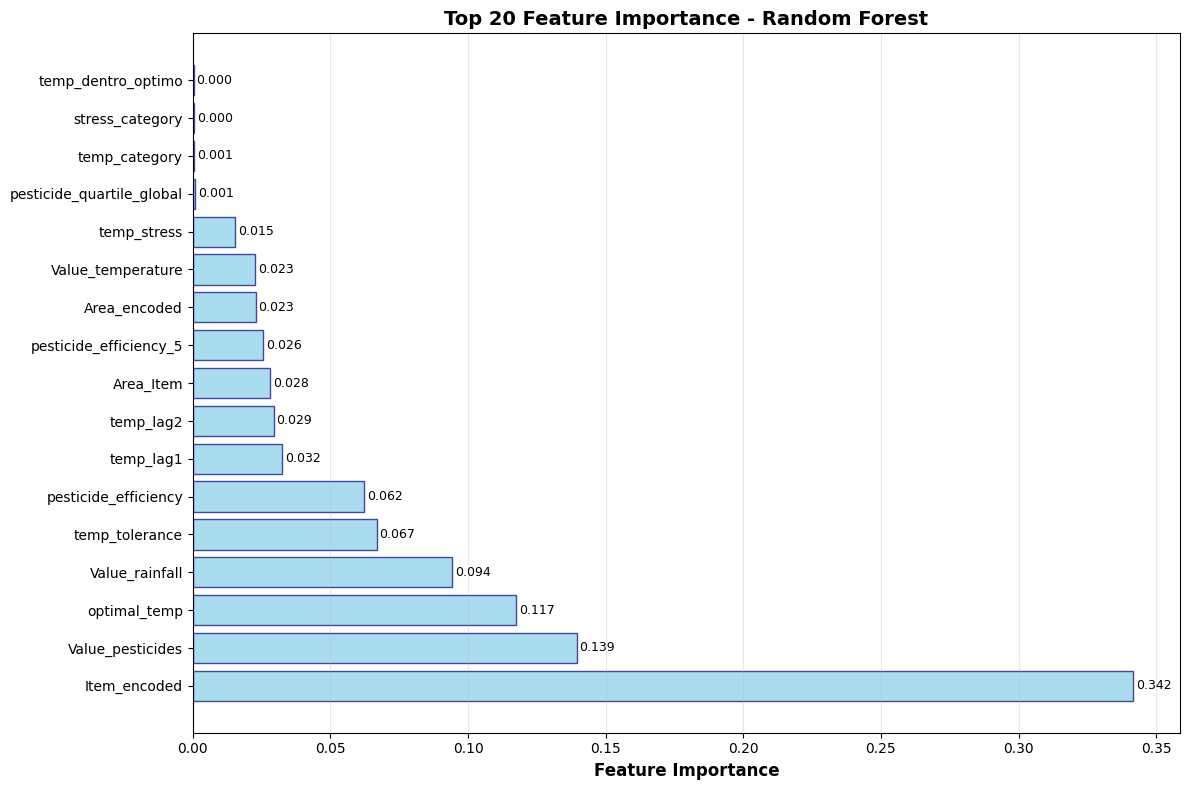

In [174]:
model = results['Random Forest']['model']
feature_names = data[0].columns


# Plot featue importance, hecho con Ia

def plot_feature_importance(model, feature_names, top_n=20, figsize=(12, 8)):
    """
    Plot básico de feature importance
    """

    # Crear DataFrame de importancia
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot
    plt.figure(figsize=figsize)
    
    # Top N features
    top_features = feature_importance.head(top_n)
    
    bars = plt.barh(range(len(top_features)), top_features['importance'], 
                    color='skyblue', edgecolor='navy', alpha=0.7)
    
    # Customización
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Feature Importance - Random Forest', 
              fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Añadir valores en las barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance

# Ejecutar plot básico
feature_imp = plot_feature_importance(model, feature_names, top_n=20)

El modelo de rf performa estupendamente, los otros modelos tampoco lo hacen tan mal. Pero son modelos lineales incapaces de capturar comportamientos no lineales. 

Veamos como predicen por cultivo. Hecho con IA

✓ Verificación exitosa:
  Train: 8339 meta rows = 8339 X rows
  Test: 5902 meta rows = 5902 X rows


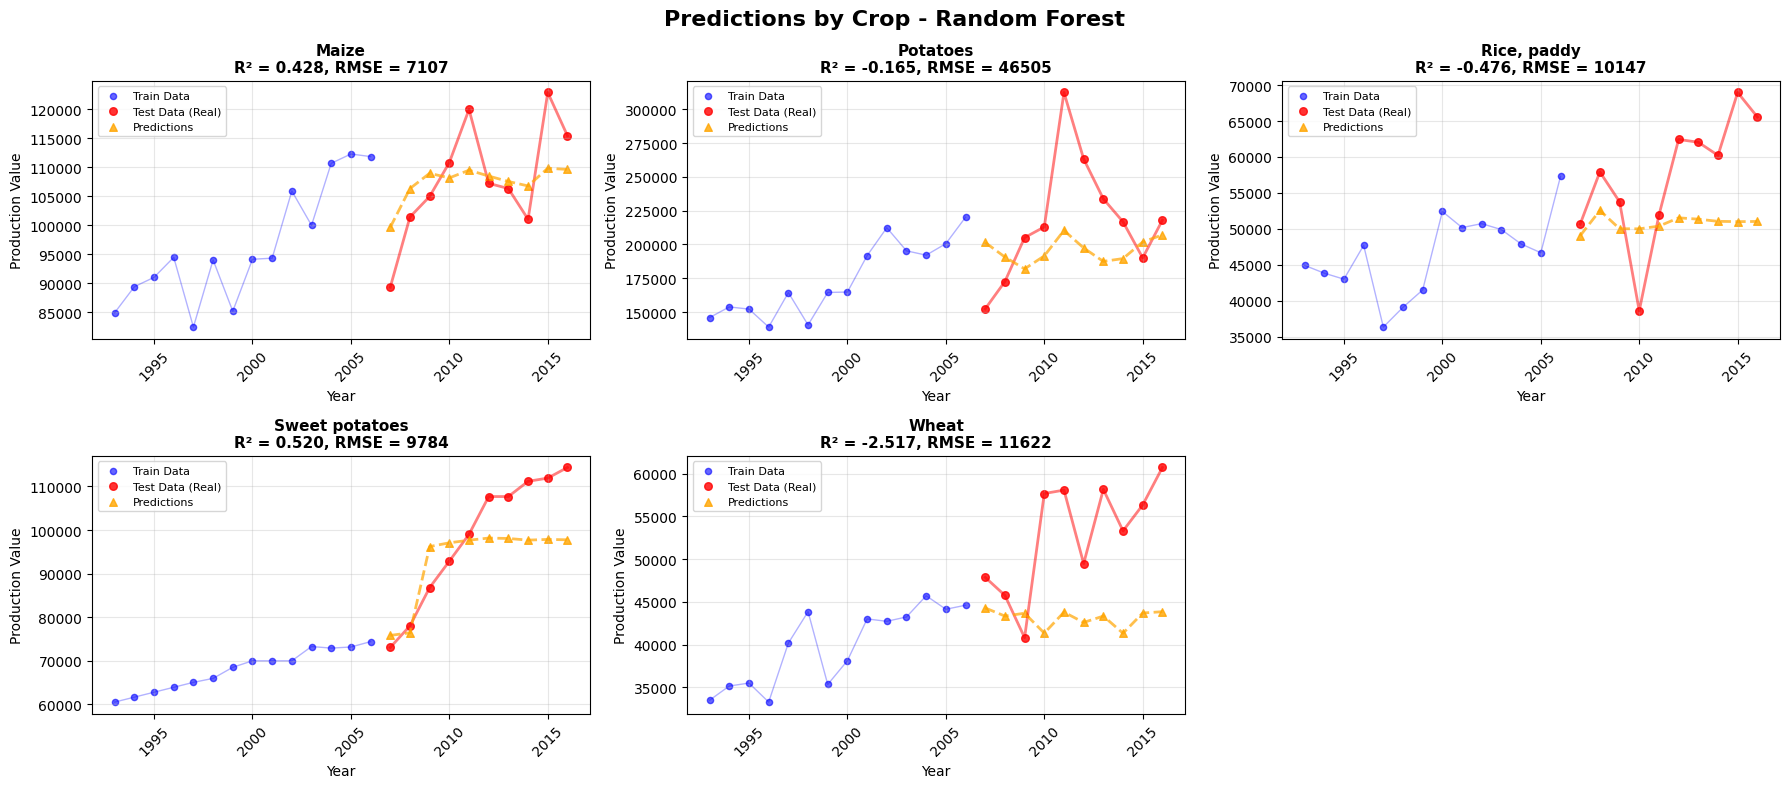

In [175]:
def create_crop_prediction_plots(model_results,
                                     meta_info, encoders, train_mask, test_mask, 
                                     model_name='Random Forest', country = None):
    
    X_train = model_results[model_name]['X_train']
    X_test = model_results[model_name]['X_test']
    y_train = model_results[model_name]['y_train']
    y_test = model_results[model_name]['y_test']



    # Usar las máscaras originales para separar meta_info correctamente
    train_meta = meta_info[train_mask].copy()
    test_meta = meta_info[test_mask].copy()
    
    # Verificar que las longitudes coincidan
    assert len(train_meta) == len(X_train), f"Train meta length {len(train_meta)} != X_train length {len(X_train)}"
    assert len(test_meta) == len(X_test), f"Test meta length {len(test_meta)} != X_test length {len(X_test)}"
    
    print(f"✓ Verificación exitosa:")
    print(f"  Train: {len(train_meta)} meta rows = {len(X_train)} X rows")
    print(f"  Test: {len(test_meta)} meta rows = {len(X_test)} X rows")
    
    # Ahora sí podemos asignar safely
    train_meta['actual'] = y_train.values
    train_meta['type'] = 'train'
    train_meta['predicted'] = np.nan
    
    test_meta['actual'] = y_test.values
    test_meta['type'] = 'test'
    test_meta['predicted'] = model_results[model_name][ 'y_pred_test']
    
    full_data = pd.concat([train_meta, test_meta], ignore_index=True)
    
    # Decodificar Item si está encoded
    if 'Item' in encoders and 'Item' in full_data.columns:
        item_codes = full_data['Item'].astype(int)
        full_data['Item_decoded'] = encoders['Item'].inverse_transform(item_codes)
        item_col = 'Item_decoded'
    else:
        item_col = 'Item'
    
    if not country is None:
        full_data = full_data.loc[full_data.Area == country]
    unique_crops = full_data[item_col].unique()
    n_crops = len(unique_crops)
    
    n_cols = min(3, n_crops)
    n_rows = (n_crops + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
    if n_crops == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, crop in enumerate(unique_crops):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        crop_data = full_data[full_data[item_col] == crop].copy()
        crop_data = crop_data.sort_values('Year')
        
        train_data = crop_data[crop_data['type'] == 'train']
        test_data = crop_data[crop_data['type'] == 'test']
        
        # Plot
        ax.scatter(train_data['Year'], train_data['actual'], 
                  color='blue', alpha=0.6, s=20, label='Train Data')
        ax.scatter(test_data['Year'], test_data['actual'], 
                  color='red', alpha=0.8, s=30, label='Test Data (Real)')
        ax.scatter(test_data['Year'], test_data['predicted'], 
                  color='orange', alpha=0.8, s=30, marker='^', label='Predictions')
        
        if len(train_data) > 1:
            ax.plot(train_data['Year'], train_data['actual'], 
                   color='blue', alpha=0.3, linewidth=1)
        if len(test_data) > 1:
            ax.plot(test_data['Year'], test_data['actual'], 
                   color='red', alpha=0.5, linewidth=2)
            ax.plot(test_data['Year'], test_data['predicted'], 
                   color='orange', alpha=0.7, linewidth=2, linestyle='--')
        
        if len(test_data) > 0:
            crop_r2 = r2_score(test_data['actual'], test_data['predicted'])
            crop_rmse = np.sqrt(mean_squared_error(test_data['actual'], test_data['predicted']))
            ax.set_title(f'{crop}\nR² = {crop_r2:.3f}, RMSE = {crop_rmse:.0f}', 
                        fontsize=11, fontweight='bold')
        else:
            ax.set_title(f'{crop}\n(No test data)', fontsize=11)
        
        ax.set_xlabel('Year')
        ax.set_ylabel('Production Value')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        
        if len(crop_data['Year'].unique()) > 10:
            ax.tick_params(axis='x', rotation=45)
    
    # Ocultar subplots vacíos
    for i in range(n_crops, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if n_rows > 1:
            axes[row, col].set_visible(False)
        elif n_cols > 1:
            axes[col].set_visible(False)
    
    plt.suptitle(f'Predictions by Crop - {model_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return full_data

# Ejecutar comparación
comparison_data = create_crop_prediction_plots(results,
                                     meta_info, encoders, mask[0], mask[1], 
                                     model_name='Random Forest', country= 'Chile')

In [176]:
X_train = results[model_name]['X_train']
X_test = results[model_name]['X_test']
y_train = results[model_name]['y_train']
y_test = results[model_name]['y_test']

# Usar las máscaras originales
train_meta = meta_info[mask[0]].copy()
test_meta = meta_info[mask[1]].copy()

# Verificar longitudes
assert len(train_meta) == len(X_train), f"Train meta length {len(train_meta)} != X_train length {len(X_train)}"
assert len(test_meta) == len(X_test), f"Test meta length {len(test_meta)} != X_test length {len(X_test)}"

# Asignar datos
train_meta['actual'] = y_train.values
train_meta['type'] = 'train'
train_meta['predicted'] = np.nan

test_meta['actual'] = y_test.values
test_meta['type'] = 'test'
test_meta['predicted'] = results[model_name]['y_pred_test']



In [177]:
full_data

Year      Area   Item  actual   type  predicted
0      1993   Albania  Maize   24185  train        NaN
1      1994   Albania  Maize   25848  train        NaN
2      1995   Albania  Maize   31300  train        NaN
3      1996   Albania  Maize   32604  train        NaN
4      1997   Albania  Maize   31862  train        NaN
...     ...       ...    ...     ...    ...        ...
43698  2012  Zimbabwe  Wheat   24420   test   34503.14
43699  2013  Zimbabwe  Wheat   22888   test   36942.22
43700  2014  Zimbabwe  Wheat   21357   test   37175.83
43701  2015  Zimbabwe  Wheat   19826   test   37153.98
43702  2016  Zimbabwe  Wheat   18294   test   37357.72

[43703 rows x 6 columns]

### Overall plot

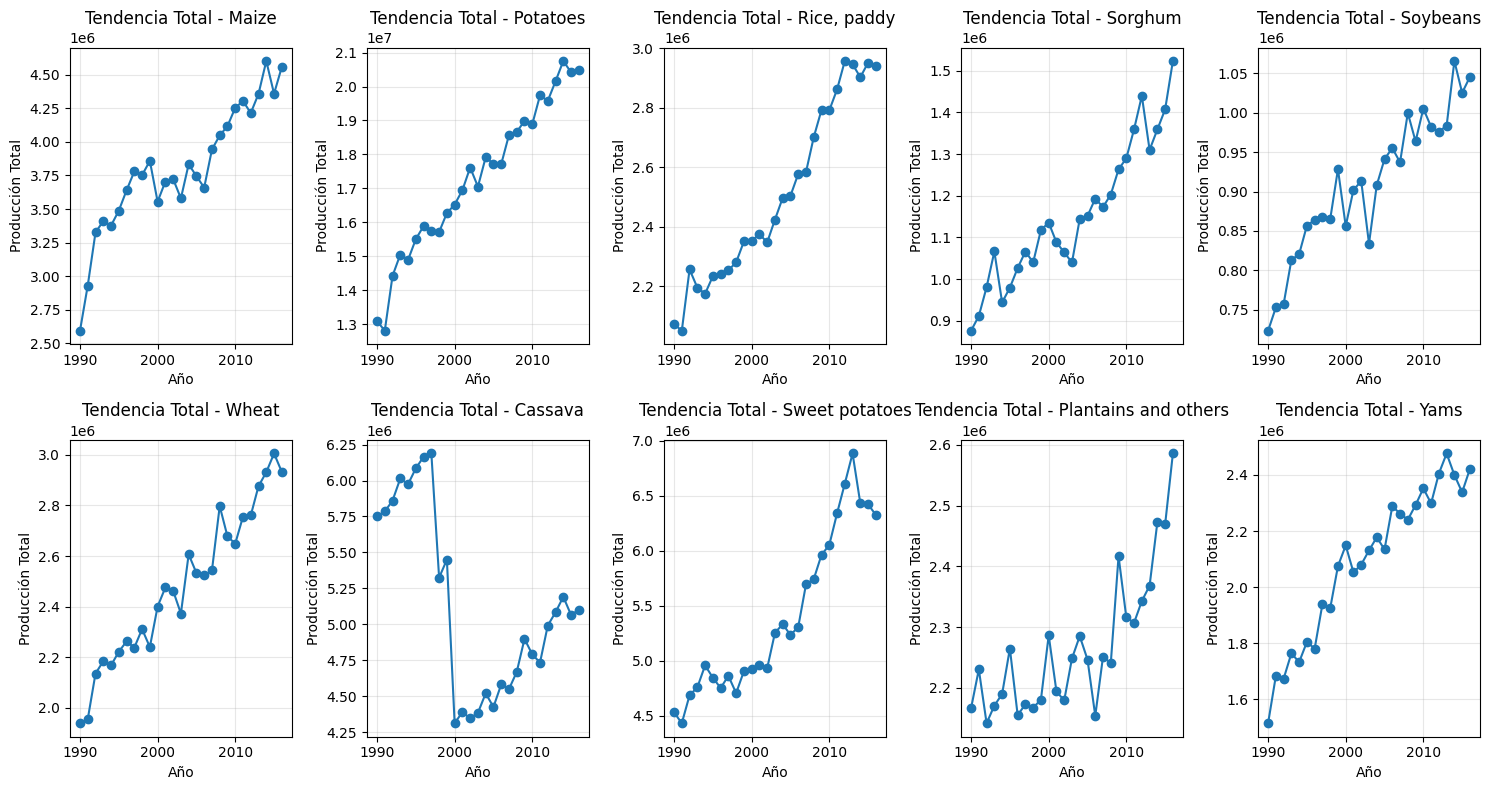

In [178]:

plt.figure(figsize=(15, 8))
for i, cultivo in enumerate(df_features['Item'].unique()):
    plt.subplot(2, 5, i+1)
    data_cultivo = df_features[df_features['Item'] == cultivo]
    tendencia_anual = data_cultivo.groupby('Year')['Value'].sum()
    
    plt.plot(tendencia_anual.index, tendencia_anual.values, marker='o')
    plt.title(f'Tendencia Total - {cultivo}')
    plt.xlabel('Año')
    plt.ylabel('Producción Total')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

In [179]:
full_data.shape

(43703, 6)

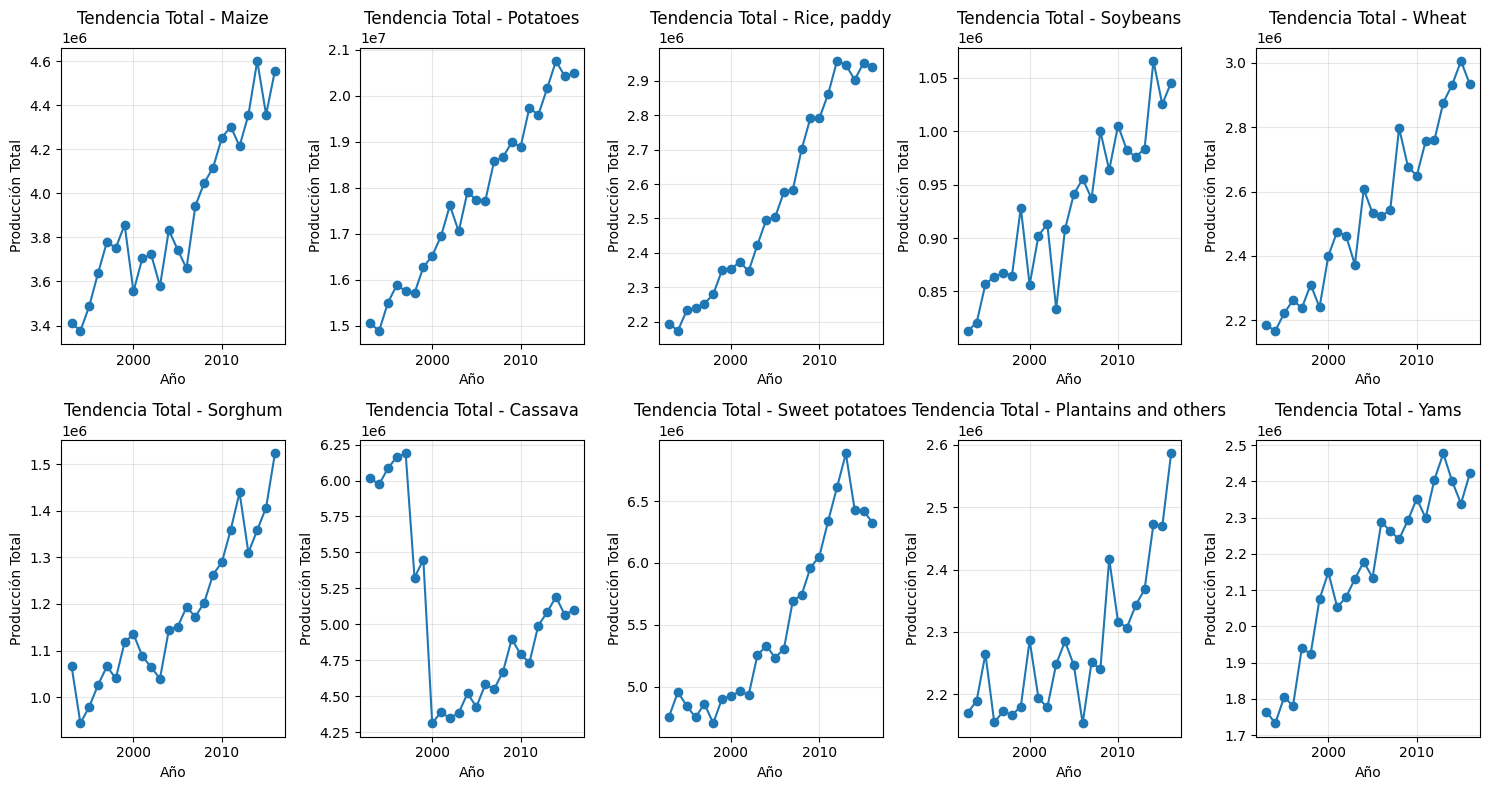

In [180]:
full_data = pd.concat([train_meta, test_meta], ignore_index=True)
full_data.sort_values(['Area', 'Item', 'Year'], inplace= True)
plt.figure(figsize=(15, 8))
for i, cultivo in enumerate(full_data['Item'].unique()):
    plt.subplot(2, 5, i+1)
    data_cultivo = full_data[full_data['Item'] == cultivo]
    tendencia_anual = data_cultivo.groupby('Year')['actual'].sum()
    
    plt.plot(tendencia_anual.index, tendencia_anual.values, marker='o')
    plt.title(f'Tendencia Total - {cultivo}')
    plt.xlabel('Año')
    plt.ylabel('Producción Total')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()


Analizando cultivos: ['Potatoes', 'Maize', 'Wheat', 'Rice, paddy', 'Sorghum', 'Soybeans']


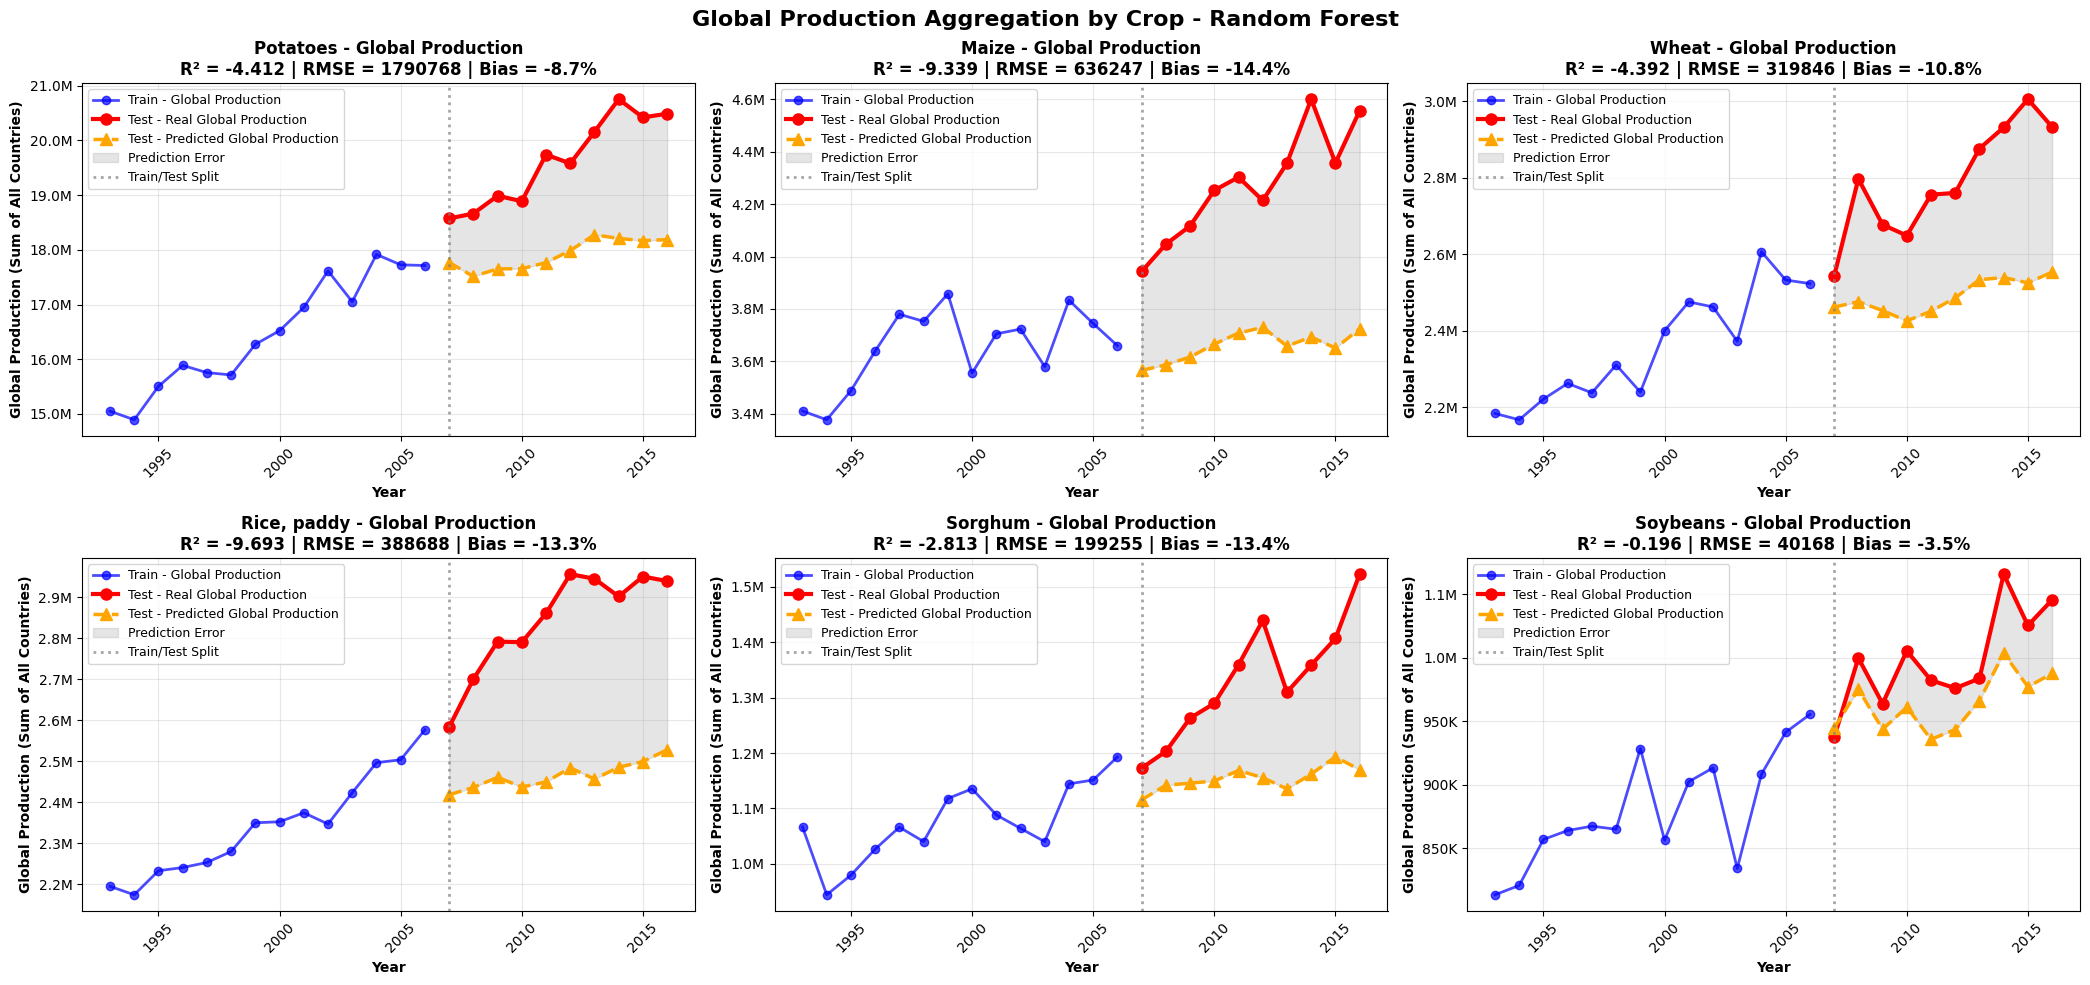


=== MÉTRICAS DE PRODUCCIÓN GLOBAL - Random Forest ===
Potatoes       : R² = -4.412 | RMSE =  1790768 | MAPE =    8.6% | Bias =   -8.7%
Maize          : R² = -9.339 | RMSE =   636247 | MAPE =   14.3% | Bias =  -14.4%
Wheat          : R² = -4.392 | RMSE =   319846 | MAPE =   10.7% | Bias =  -10.8%
Rice, paddy    : R² = -9.693 | RMSE =   388688 | MAPE =   13.1% | Bias =  -13.3%
Sorghum        : R² = -2.813 | RMSE =   199255 | MAPE =   13.0% | Bias =  -13.4%
Soybeans       : R² = -0.196 | RMSE =    40168 | MAPE =    3.6% | Bias =   -3.5%


In [181]:
def create_global_crop_production_plots(model_results,
                                       meta_info, encoders, train_mask, test_mask, 
                                       model_name='Random Forest', top_crops=None):
    """
    Gráfico de producción global agregada por cultivo y año (suma de todos los países)
    """
    
    X_train = model_results[model_name]['X_train']
    X_test = model_results[model_name]['X_test']
    y_train = model_results[model_name]['y_train']
    y_test = model_results[model_name]['y_test']
    
    # Usar las máscaras originales
    train_meta = meta_info[train_mask].copy()
    test_meta = meta_info[test_mask].copy()
    
    # Verificar longitudes
    assert len(train_meta) == len(X_train), f"Train meta length {len(train_meta)} != X_train length {len(X_train)}"
    assert len(test_meta) == len(X_test), f"Test meta length {len(test_meta)} != X_test length {len(X_test)}"
    
    # Asignar datos
    train_meta['actual'] = y_train.values
    train_meta['type'] = 'train'
    train_meta['predicted'] = np.nan
    
    test_meta['actual'] = y_test.values
    test_meta['type'] = 'test'
    test_meta['predicted'] = model_results[model_name]['y_pred_test']
    
    full_data = pd.concat([train_meta, test_meta], ignore_index=True)
    
    # Decodificar Item si está encoded
    if 'Item' in encoders and 'Item' in full_data.columns:
        item_codes = full_data['Item'].astype(int)
        full_data['Item_decoded'] = encoders['Item'].inverse_transform(item_codes)
        item_col = 'Item_decoded'
    else:
        item_col = 'Item'
    
    # Decodificar Area si está encoded (para el análisis)
    if 'Area' in encoders and 'Area' in full_data.columns:
        area_codes = full_data['Area'].astype(int)
        full_data['Area_decoded'] = encoders['Area'].inverse_transform(area_codes)
        area_col = 'Area_decoded'
    else:
        area_col = 'Area'
    
    # Seleccionar cultivos a mostrar
    if top_crops is None:
        # Tomar los cultivos con más datos de test
        crop_test_counts = full_data[full_data['type'] == 'test'][item_col].value_counts()
        top_crops = crop_test_counts.head(6).index.tolist()
    
    print(f"Analizando cultivos: {top_crops}")
    
    # Agregar datos por cultivo y año (suma global)
    aggregated_data = []
    
    for crop in top_crops:
        crop_data = full_data[full_data[item_col] == crop].copy()
        
        # Agregar por año y tipo
        for data_type in ['train', 'test']:
            type_data = crop_data[crop_data['type'] == data_type]
            
            if len(type_data) > 0:
                # Sumar producción por año (todos los países)
                yearly_sums = type_data.groupby('Year').agg({
                    'actual': 'sum',
                    'predicted': 'sum' if data_type == 'test' else lambda x: np.nan
                }).reset_index()
                
                yearly_sums['crop'] = crop
                yearly_sums['type'] = data_type
                yearly_sums['countries_count'] = type_data.groupby('Year')[area_col].nunique().values
                
                aggregated_data.append(yearly_sums)
    
    # Combinar todos los datos agregados
    agg_df = pd.concat(aggregated_data, ignore_index=True)
    
    # Crear plots
    n_crops = len(top_crops)
    n_cols = min(3, n_crops)
    n_rows = (n_crops + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 5*n_rows))
    if n_crops == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, crop in enumerate(top_crops):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        # Datos del cultivo
        crop_agg = agg_df[agg_df['crop'] == crop].copy()
        
        train_agg = crop_agg[crop_agg['type'] == 'train'].sort_values('Year')
        test_agg = crop_agg[crop_agg['type'] == 'test'].sort_values('Year')
        
        # Plot datos de entrenamiento (línea continua)
        if len(train_agg) > 0:
            ax.plot(train_agg['Year'], train_agg['actual'], 
                   'o-', color='blue', linewidth=2, markersize=6, alpha=0.7,
                   label=f'Train - Global Production')
        
        # Plot datos de test - real (línea gruesa roja)
        if len(test_agg) > 0:
            ax.plot(test_agg['Year'], test_agg['actual'], 
                   'o-', color='red', linewidth=3, markersize=8,
                   label=f'Test - Real Global Production')
            
            # Plot predicciones (línea punteada naranja)
            ax.plot(test_agg['Year'], test_agg['predicted'], 
                   '^--', color='orange', linewidth=2.5, markersize=8,
                   label=f'Test - Predicted Global Production')
            
            # Área de diferencia entre real y predicho
            ax.fill_between(test_agg['Year'], 
                           test_agg['actual'], 
                           test_agg['predicted'],
                           alpha=0.2, color='gray', label='Prediction Error')
        
        # Línea vertical separando train/test
        if len(test_agg) > 0 and len(train_agg) > 0:
            split_year = test_agg['Year'].min()
            ax.axvline(x=split_year, color='gray', linestyle=':', alpha=0.7, linewidth=2,
                      label=f'Train/Test Split')
        
        # Calcular métricas globales
        if len(test_agg) > 0:
            global_r2 = r2_score(test_agg['actual'], test_agg['predicted'])
            global_rmse = np.sqrt(mean_squared_error(test_agg['actual'], test_agg['predicted']))
            global_mape = np.mean(np.abs((test_agg['actual'] - test_agg['predicted']) / 
                                       test_agg['actual'])) * 100
            
            # Calcular sesgo total
            total_real = test_agg['actual'].sum()
            total_pred = test_agg['predicted'].sum()
            bias_pct = ((total_pred - total_real) / total_real) * 100
            
            # Título con métricas globales
            ax.set_title(f'{crop} - Global Production\nR² = {global_r2:.3f} | RMSE = {global_rmse:.0f} | Bias = {bias_pct:+.1f}%', 
                        fontsize=12, fontweight='bold')
        else:
            ax.set_title(f'{crop} - Global Production\n(No test data)', fontsize=12)
        
        ax.set_xlabel('Year', fontweight='bold')
        ax.set_ylabel('Global Production (Sum of All Countries)', fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9, loc='best')
        
        # Formatear eje Y para números grandes
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))
        
        # Rotar etiquetas de años si son muchas
        years_range = pd.concat([train_agg['Year'], test_agg['Year']]).unique() if len(train_agg) > 0 and len(test_agg) > 0 else []
        if len(years_range) > 10:
            ax.tick_params(axis='x', rotation=45)
    
    # Ocultar subplots vacíos
    for i in range(n_crops, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if n_rows > 1:
            axes[row, col].set_visible(False)
        elif n_cols > 1:
            axes[col].set_visible(False)
    
    plt.suptitle(f'Global Production Aggregation by Crop - {model_name}', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Imprimir resumen de métricas globales
    print(f"\n=== MÉTRICAS DE PRODUCCIÓN GLOBAL - {model_name} ===")
    for crop in top_crops:
        crop_test = agg_df[(agg_df['crop'] == crop) & (agg_df['type'] == 'test')]
        if len(crop_test) > 0:
            global_r2 = r2_score(crop_test['actual'], crop_test['predicted'])
            global_rmse = np.sqrt(mean_squared_error(crop_test['actual'], crop_test['predicted']))
            global_mape = np.mean(np.abs((crop_test['actual'] - crop_test['predicted']) / 
                                       crop_test['actual'])) * 100
            
            total_real = crop_test['actual'].sum()
            total_pred = crop_test['predicted'].sum()
            bias_pct = ((total_pred - total_real) / total_real) * 100
            
            print(f"{crop:15s}: R² = {global_r2:6.3f} | RMSE = {global_rmse:8.0f} | MAPE = {global_mape:6.1f}% | Bias = {bias_pct:+6.1f}%")
    
    return agg_df

global_production_data = create_global_crop_production_plots(
    results, meta_info, encoders, mask[0], mask[1], 
    model_name='Random Forest'
)

✓ Modelos disponibles: ['Linear', 'Ridge', 'Lasso', 'Random Forest']
Analizando cultivos: ['Potatoes', 'Maize', 'Wheat', 'Rice, paddy', 'Sorghum', 'Soybeans']


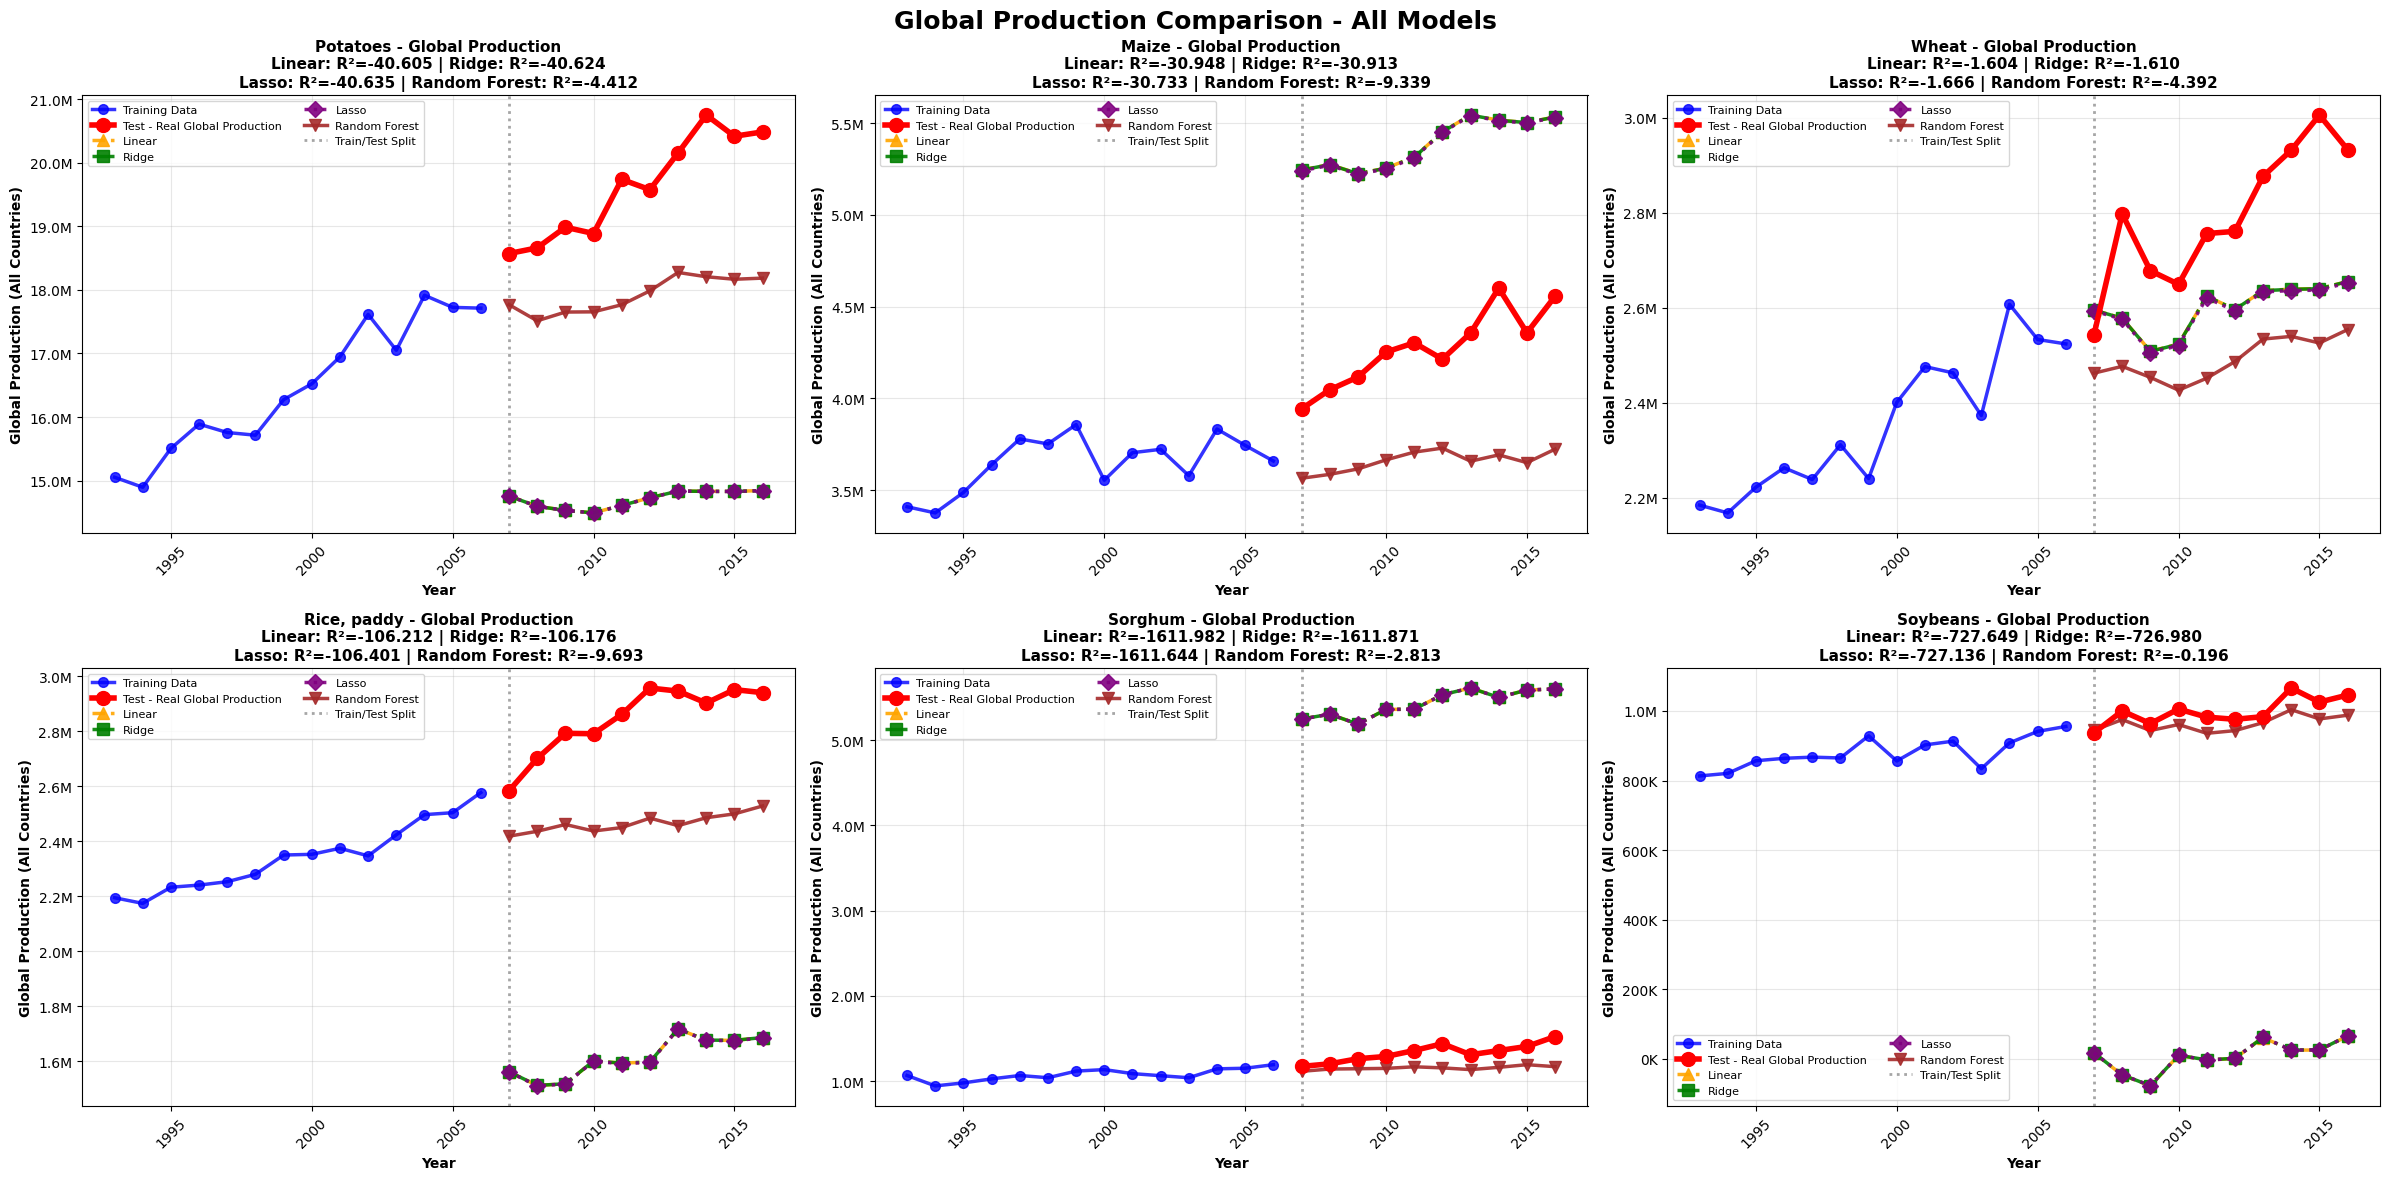


=== COMPARACIÓN DE MÉTRICAS GLOBALES - TODOS LOS MODELOS ===

R² por modelo y cultivo:
       Crop  Linear_R2  Ridge_R2  Lasso_R2  Random Forest_R2
   Potatoes    -40.605   -40.624   -40.635            -4.412
      Maize    -30.948   -30.913   -30.733            -9.339
      Wheat     -1.604    -1.610    -1.666            -4.392
Rice, paddy   -106.212  -106.176  -106.401            -9.693
    Sorghum  -1611.982 -1611.871 -1611.644            -2.813
   Soybeans   -727.649  -726.980  -727.136            -0.196

RMSE por modelo y cultivo:
       Crop  Linear_RMSE  Ridge_RMSE  Lasso_RMSE  Random Forest_RMSE
   Potatoes    4965120.0   4966243.0   4966860.0           1790768.0
      Maize    1118401.0   1117788.0   1114646.0            636247.0
      Wheat     222267.0    222505.0    224900.0            319846.0
Rice, paddy    1230750.0   1230542.0   1231831.0            388688.0
    Sorghum    4098079.0   4097938.0   4097649.0            199255.0
   Soybeans     991432.0    990977.0    991

In [182]:
def create_global_crop_production_all_models(model_results,
                                           meta_info, encoders, train_mask, test_mask, 
                                           top_crops=None):
    """
    Gráfico de producción global agregada mostrando TODOS los modelos
    """
    
    # Obtener datos de cualquier modelo (usamos el primero para train/test data)
    first_model = list(model_results.keys())[0]
    X_train = model_results[first_model]['X_train']
    X_test = model_results[first_model]['X_test']
    y_train = model_results[first_model]['y_train']
    y_test = model_results[first_model]['y_test']
    
    # Usar las máscaras originales
    train_meta = meta_info[train_mask].copy()
    test_meta = meta_info[test_mask].copy()
    
    # Verificar longitudes
    assert len(train_meta) == len(X_train), f"Train meta length {len(train_meta)} != X_train length {len(X_train)}"
    assert len(test_meta) == len(X_test), f"Test meta length {len(test_meta)} != X_test length {len(X_test)}"
    
    print(f"✓ Modelos disponibles: {list(model_results.keys())}")
    
    # Preparar datos base
    train_meta['actual'] = y_train.values
    train_meta['type'] = 'train'
    
    test_meta['actual'] = y_test.values
    test_meta['type'] = 'test'
    
    # Añadir predicciones de TODOS los modelos
    for model_name in model_results.keys():
        test_meta[f'predicted_{model_name}'] = model_results[model_name]['y_pred_test']
    
    full_data = pd.concat([train_meta, test_meta], ignore_index=True)
    
    # Decodificar Item si está encoded
    if 'Item' in encoders and 'Item' in full_data.columns:
        item_codes = full_data['Item'].astype(int)
        full_data['Item_decoded'] = encoders['Item'].inverse_transform(item_codes)
        item_col = 'Item_decoded'
    else:
        item_col = 'Item'
    
    # Decodificar Area si está encoded
    if 'Area' in encoders and 'Area' in full_data.columns:
        area_codes = full_data['Area'].astype(int)
        full_data['Area_decoded'] = encoders['Area'].inverse_transform(area_codes)
        area_col = 'Area_decoded'
    else:
        area_col = 'Area'
    
    # Seleccionar cultivos a mostrar
    if top_crops is None:
        crop_test_counts = full_data[full_data['type'] == 'test'][item_col].value_counts()
        top_crops = crop_test_counts.head(6).index.tolist()
    
    print(f"Analizando cultivos: {top_crops}")
    
    # Configurar colores y estilos para cada modelo
    model_names = list(model_results.keys())
    colors = ['orange', 'green', 'purple', 'brown', 'pink', 'cyan']
    markers = ['^', 's', 'D', 'v', 'o', 'p']
    linestyles = ['--', '-.', ':', '-', '--', '-.']
    
    model_styles = {}
    for i, model in enumerate(model_names):
        model_styles[model] = {
            'color': colors[i % len(colors)],
            'marker': markers[i % len(markers)],
            'linestyle': linestyles[i % len(linestyles)]
        }
    
    # Agregar datos por cultivo y año (suma global)
    aggregated_data = []
    
    for crop in top_crops:
        crop_data = full_data[full_data[item_col] == crop].copy()
        
        # Datos de entrenamiento
        train_crop = crop_data[crop_data['type'] == 'train']
        if len(train_crop) > 0:
            train_yearly = train_crop.groupby('Year').agg({
                'actual': 'sum'
            }).reset_index()
            train_yearly['crop'] = crop
            train_yearly['type'] = 'train'
            aggregated_data.append(train_yearly)
        
        # Datos de test
        test_crop = crop_data[crop_data['type'] == 'test']
        if len(test_crop) > 0:
            # Crear diccionario para aggregation
            agg_dict = {'actual': 'sum'}
            for model_name in model_names:
                agg_dict[f'predicted_{model_name}'] = 'sum'
            
            test_yearly = test_crop.groupby('Year').agg(agg_dict).reset_index()
            test_yearly['crop'] = crop
            test_yearly['type'] = 'test'
            test_yearly['countries_count'] = test_crop.groupby('Year')[area_col].nunique().values
            aggregated_data.append(test_yearly)
    
    # Combinar todos los datos agregados
    agg_df = pd.concat(aggregated_data, ignore_index=True)
    
    # Crear plots
    n_crops = len(top_crops)
    n_cols = min(3, n_crops)
    n_rows = (n_crops + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 6*n_rows))
    if n_crops == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, crop in enumerate(top_crops):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        # Datos del cultivo
        crop_agg = agg_df[agg_df['crop'] == crop].copy()
        
        train_agg = crop_agg[crop_agg['type'] == 'train'].sort_values('Year')
        test_agg = crop_agg[crop_agg['type'] == 'test'].sort_values('Year')
        
        # Plot datos de entrenamiento (línea continua azul)
        if len(train_agg) > 0:
            ax.plot(train_agg['Year'], train_agg['actual'], 
                   'o-', color='blue', linewidth=2.5, markersize=7, alpha=0.8,
                   label='Training Data', zorder=5)
        
        # Plot datos de test - real (línea gruesa roja)
        if len(test_agg) > 0:
            ax.plot(test_agg['Year'], test_agg['actual'], 
                   'o-', color='red', linewidth=4, markersize=10,
                   label='Test - Real Global Production', zorder=10)
            
            # Plot predicciones de TODOS los modelos
            for model_name in model_names:
                style = model_styles[model_name]
                pred_col = f'predicted_{model_name}'
                
                if pred_col in test_agg.columns:
                    ax.plot(test_agg['Year'], test_agg[pred_col], 
                           marker=style['marker'], linestyle=style['linestyle'],
                           color=style['color'], linewidth=2.5, markersize=8, alpha=0.9,
                           label=f'{model_name}', zorder=7)
        
        # Línea vertical separando train/test
        if len(test_agg) > 0 and len(train_agg) > 0:
            split_year = test_agg['Year'].min()
            ax.axvline(x=split_year, color='gray', linestyle=':', alpha=0.7, linewidth=2,
                      label='Train/Test Split', zorder=1)
        
        # Calcular métricas para cada modelo
        metrics_text = []
        if len(test_agg) > 0:
            for model_name in model_names:
                pred_col = f'predicted_{model_name}'
                if pred_col in test_agg.columns:
                    model_r2 = r2_score(test_agg['actual'], test_agg[pred_col])
                    model_rmse = np.sqrt(mean_squared_error(test_agg['actual'], test_agg[pred_col]))
                    metrics_text.append(f'{model_name}: R²={model_r2:.3f}')
            
            # Título con métricas de todos los modelos
            title_text = f'{crop} - Global Production\n' + ' | '.join(metrics_text[:2])
            if len(metrics_text) > 2:
                title_text += f'\n{" | ".join(metrics_text[2:])}'
                
            ax.set_title(title_text, fontsize=11, fontweight='bold')
        else:
            ax.set_title(f'{crop} - Global Production\n(No test data)', fontsize=11)
        
        ax.set_xlabel('Year', fontweight='bold')
        ax.set_ylabel('Global Production (All Countries)', fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Leyenda más compacta
        ax.legend(fontsize=8, loc='best', ncol=2 if len(model_names) > 3 else 1)
        
        # Formatear eje Y para números grandes
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))
        
        # Rotar etiquetas de años si son muchas
        years_range = pd.concat([train_agg['Year'], test_agg['Year']]).unique() if len(train_agg) > 0 and len(test_agg) > 0 else []
        if len(years_range) > 8:
            ax.tick_params(axis='x', rotation=45)
    
    # Ocultar subplots vacíos
    for i in range(n_crops, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if n_rows > 1:
            axes[row, col].set_visible(False)
        elif n_cols > 1:
            axes[col].set_visible(False)
    
    plt.suptitle(f'Global Production Comparison - All Models', 
                fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Imprimir tabla de comparación de métricas globales
    print(f"\n=== COMPARACIÓN DE MÉTRICAS GLOBALES - TODOS LOS MODELOS ===")
    comparison_data = []
    
    for crop in top_crops:
        crop_test = agg_df[(agg_df['crop'] == crop) & (agg_df['type'] == 'test')]
        if len(crop_test) > 0:
            row_data = {'Crop': crop}
            
            for model_name in model_names:
                pred_col = f'predicted_{model_name}'
                if pred_col in crop_test.columns:
                    model_r2 = r2_score(crop_test['actual'], crop_test[pred_col])
                    model_rmse = np.sqrt(mean_squared_error(crop_test['actual'], crop_test[pred_col]))
                    
                    total_real = crop_test['actual'].sum()
                    total_pred = crop_test[pred_col].sum()
                    bias_pct = ((total_pred - total_real) / total_real) * 100
                    
                    row_data[f'{model_name}_R2'] = model_r2
                    row_data[f'{model_name}_RMSE'] = model_rmse
                    row_data[f'{model_name}_Bias%'] = bias_pct
            
            comparison_data.append(row_data)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Mostrar tabla formateada
    if not comparison_df.empty:
        print("\nR² por modelo y cultivo:")
        r2_cols = [col for col in comparison_df.columns if '_R2' in col]
        r2_table = comparison_df[['Crop'] + r2_cols].round(3)
        print(r2_table.to_string(index=False))
        
        print("\nRMSE por modelo y cultivo:")
        rmse_cols = [col for col in comparison_df.columns if '_RMSE' in col]
        rmse_table = comparison_df[['Crop'] + rmse_cols].round(0)
        print(rmse_table.to_string(index=False))
        
        print("\nBias (%) por modelo y cultivo:")
        bias_cols = [col for col in comparison_df.columns if '_Bias%' in col]
        bias_table = comparison_df[['Crop'] + bias_cols].round(1)
        print(bias_table.to_string(index=False))
    
    return agg_df, comparison_df

# Ejecutar el gráfico con todos los modelos
global_all_models_data, metrics_comparison = create_global_crop_production_all_models(
    results, meta_info, encoders, mask[0], mask[1]
)